# Debug

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

from sklearn import  metrics
from math import sqrt
import tqdm
import time


# custom utils
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  mlp_fit_log_alg
            
from holidayList import hol_list

from params import xgb_params,cbr_params,lgb_params,mlp_params

LOGNUMBER = 'cb_lgb_adaptive_baseline_wo_ar'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

target = 'Value'
numeric_features = ['dow','hour','temp_diff','Temperature','is_day_off']
ar_features1 = ['Value1','Value2','Value3','Value4','Value5','Value10','dValue1','T1','T5','T10']
forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))

pd.set_option('mode.chained_assignment', None)

stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',         
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')



Starting the ETL process
Time taken to complete the ETL process 174.8567717075348
LGB params : {'n_estimators': 700, 'random_state': 27, 'n_jobs': 10, 'approx_on_full_history': True, 'boosting_type': 'gbdt', 'objective': 'regression', 'silent': True, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 10}
CB  params : {'n_estimators': 700, 'random_state': 27, 'loss_function': 'RMSE', 'approx_on_full_history': True, 'l2_leaf_reg': 500, 'has_time': True, 'verbose': False, 'learning_rate': 0.1, 'thread_count': 10}


In [32]:
stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',         
            ]
stat_df = pd.DataFrame(columns=stat_cols)

In [11]:
from params import xgb_params,cbr_params,lgb_params,mlp_params

In [40]:
lgb_params = {
    'boosting_type':'gbdt',
    'random_state':27, 
    'learning_rate':0.1, 
    'max_depth':10,
    'num_leaves':512,
    'n_estimators':700, 
    'objective':'regression', 
    'n_jobs':10,
    "verbose": -1
}

In [41]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        # try:
        
        forecast_id = 555
        
        temp_df = df_train[(df_train.ForecastId == forecast_id)
                            &(pd.notnull(df_train.Value))]

        # add test set data
        temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])

        temp_df = produce_ar_features(temp_df)
        temp_df = temp_df.reset_index()

        # test forests
        all_hols = temp_df[hol_list].sum()>0
        non_zero_hols = list(all_hols.index[all_hols == True])

        val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
        train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
        test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]

        predictors = numeric_features + non_zero_hols
        cbr = CatBoostRegressor(**cbr_params)

        print(lgb_params)

        lgb = LGBMRegressor(**lgb_params)

        start_time = time.time()

        cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                 temp_df.filter(items=train_ind,axis=0),
                 temp_df.filter(items=val_ind,axis=0),                
                 predictors)

        lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                 temp_df.filter(items=train_ind,axis=0),
                 temp_df.filter(items=val_ind,axis=0),                
                 predictors)            

        # simple voting rule
        # choose the regressor with better score
        if cb_rmse_val<lgb_rmse_val:
            # print('CB chosen')
            temp_df['Value'] = cbr.predict(temp_df[predictors])
        else:
            # print('LGB chosen')
            temp_df['Value'] = lgb.predict(temp_df[predictors])

        # set the predictions in the prediction df
        obs_ids = list(temp_df.loc[test_ind].obs_id)
        predictions = list(temp_df.loc[test_ind].Value)
        submission_df.loc[obs_ids,'Value'] = predictions        

        elapsed_time = time.time() - start_time 

        stat_df_temp = pd.DataFrame(columns=stat_cols)
        stat_df_temp['forecast_id'] = [forecast_id]

        stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
        stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
        stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
        stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
        stat_df_temp['cb_scores'] = [cb_scores]

        stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
        stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
        stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
        stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
        stat_df_temp['lgb_scores'] = [lgb_scores]

        stat_df_temp['time_taken'] = [elapsed_time]            

        stat_df = stat_df.append(stat_df_temp)            

        if i%500 == 1:
            stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
            submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
            print('Iteration {}, logs saved'.format(i))
        pbar.update(1)
        """
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions
         """
        break
       
# stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
# submission_df['Value'] = submission_df['Value'].fillna(value=0)
# submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

  0%|          | 0/6974 [00:00<?, ?it/s]

{'n_estimators': 700, 'random_state': 27, 'n_jobs': 10, 'boosting_type': 'gbdt', 'objective': 'regression', 'learning_rate': 0.1, 'verbose': -1, 'num_leaves': 512, 'max_depth': 10}


  0%|          | 1/6974 [00:01<2:57:59,  1.53s/it]


In [42]:
stat_df

cb_r2_score_train  cb_r2_score_val  cb_rmse_train   cb_rmse_val  \
0           0.466459        -3.562889   1.916683e+06  3.442972e+06   
0           0.466459        -3.562889   1.916683e+06  3.442972e+06   
0           0.746992         0.193014   1.179216e+03  4.347984e+03   
0           0.746992         0.193014   1.179216e+03  4.347984e+03   

                                           cb_scores forecast_id  \
0  {'hol_Veterans Day': 1.6211698723871644, 'temp...           1   
0  {'hol_Veterans Day': 1.6211698723871644, 'temp...           1   
0  {'hour': 45.6881996122895, 'temp_diff': 8.9566...         555   
0  {'hour': 45.6881996122895, 'temp_diff': 8.9566...         555   

   lgb_r2_score_train  lgb_r2_score_val  lgb_rmse_train  lgb_rmse_val  \
0            0.029502         -1.462098    2.585018e+06  2.529101e+06   
0            0.029502         -1.462098    2.585018e+06  2.529101e+06   
0            0.896543          0.373142    7.540605e+02  3.832124e+03   
0            0.896731          0.374436    7.533739e+02  3.828165e+03   

                                          lgb_scores  time_taken  
0  {'hol_Veterans Day': 0, 'temp_diff': 2800, 'ho...    1.299043  
0  {'hol_Veterans Day': 0, 'temp_diff': 2800, 'ho...    1.374753  
0  {'hour': 8560, 'temp_diff': 7123, 'is_day_off'...    1.360113  
0  {'hour': 8755, 'temp_diff': 7473, 'is_day_off'...    1.497753

In [28]:
lgb

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=10, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=700,
       n_jobs=10, num_leaves=31, objective='regression', random_state=27,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1, verbose=-1)

In [10]:
test_ind

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59]

In [9]:
train_ind


[33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 21

In [11]:
temp_df

obs_id  SiteId            Timestamp  ForecastId         Value         ts  \
0    744519       1  2014-09-03 00:00:00           1  9.096555e+05 2014-09-03   
1   7627564       1  2014-09-04 00:00:00           1  1.748273e+06 2014-09-04   
5   3625268       1  2014-09-08 00:00:00           1  1.964878e+06 2014-09-08   
6   6038546       1  2014-09-09 00:00:00           1  3.266904e+06 2014-09-09   
7   4114748       1  2014-09-10 00:00:00           1  2.926094e+06 2014-09-10   
8   2572804       1  2014-09-11 00:00:00           1  1.720502e+06 2014-09-11   
9   2078763       1  2014-09-12 00:00:00           1  1.136248e+06 2014-09-12   
10  2088236       1  2014-09-13 00:00:00           1  1.040529e+06 2014-09-13   
11   330448       1  2014-09-14 00:00:00           1  1.030668e+06 2014-09-14   
12  1085235       1  2014-09-15 00:00:00           1  1.226753e+06 2014-09-15   
13  2629496       1  2014-09-16 00:00:00           1  1.228874e+06 2014-09-16   
14  3828297       1  2014-09-17 00:00:00           1  1.169026e+06 2014-09-17   
15  7855117       1  2014-09-18 00:00:00           1  1.513722e+06 2014-09-18   
16   882799       1  2014-09-19 00:00:00           1  2.015528e+06 2014-09-19   
17  3046848       1  2014-09-20 00:00:00           1  2.548943e+06 2014-09-20   
18   829135       1  2014-09-21 00:00:00           1  4.235358e+06 2014-09-21   
19  4339052       1  2014-09-22 00:00:00           1  5.538000e+06 2014-09-22   
20  4210177       1  2014-09-23 00:00:00           1  6.145531e+06 2014-09-23   
21  7684808       1  2014-09-24 00:00:00           1  5.536844e+06 2014-09-24   
22  6224650       1  2014-09-25 00:00:00           1  4.212580e+06 2014-09-25   
23  5327620       1  2014-09-26 00:00:00           1  4.778401e+06 2014-09-26   
24  1541431       1  2014-09-27 00:00:00           1  5.907855e+06 2014-09-27   
25  3513640       1  2014-09-28 00:00:00           1  4.677118e+06 2014-09-28   
26   720788       1  2014-09-29 00:00:00           1  2.470595e+06 2014-09-29   
27  6135591       1  2014-09-30 00:00:00           1  2.676795e+06 2014-09-30   
28  4289315       1  2014-10-01 00:00:00           1  2.445638e+06 2014-10-01   
29  5427741       1  2014-10-02 00:00:00           1  2.358238e+06 2014-10-02   
30   396625       1  2014-10-03 00:00:00           1  1.987666e+06 2014-10-03   
31  6827250       1  2014-10-04 00:00:00           1  1.377485e+06 2014-10-04   
32  2372286       1  2014-10-05 00:00:00           1  1.372104e+06 2014-10-05   
..      ...     ...                  ...         ...           ...        ...   
30  5740740       1  2015-09-28 00:00:00           1  0.000000e+00 2015-09-28   
31  5981476       1  2015-09-29 00:00:00           1  0.000000e+00 2015-09-29   
32  2105930       1  2015-09-30 00:00:00           1  0.000000e+00 2015-09-30   
33  1475785       1  2015-10-01 00:00:00           1  0.000000e+00 2015-10-01   
34  1818900       1  2015-10-02 00:00:00           1  0.000000e+00 2015-10-02   
35  3888488       1  2015-10-03 00:00:00           1  0.000000e+00 2015-10-03   
36  4440954       1  2015-10-04 00:00:00           1  0.000000e+00 2015-10-04   
37  6041962       1  2015-10-05 00:00:00           1  0.000000e+00 2015-10-05   
38  2354244       1  2015-10-06 00:00:00           1  0.000000e+00 2015-10-06   
39   894912       1  2015-10-07 00:00:00           1  0.000000e+00 2015-10-07   
40   597739       1  2015-10-08 00:00:00           1  0.000000e+00 2015-10-08   
41  2233331       1  2015-10-09 00:00:00           1  0.000000e+00 2015-10-09   
42  4262062       1  2015-10-10 00:00:00           1  0.000000e+00 2015-10-10   
43   810903       1  2015-10-11 00:00:00           1  0.000000e+00 2015-10-11   
44  5349515       1  2015-10-12 00:00:00           1  0.000000e+00 2015-10-12   
45   979930       1  2015-10-13 00:00:00           1  0.000000e+00 2015-10-13   
46  7319749       1  2015-10-14 00:00:00           1  0.000000e+00 2015-10-14   
47  6147024       1  2015-10-15 00:0

In [13]:
temp_df.index

Int64Index([ 0,  1,  5,  6,  7,  8,  9, 10, 11, 12,
            ...
            50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
           dtype='int64', length=412)

In [14]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        try:
            a = 1/0
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]

            # add test set data
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])

            temp_df = produce_ar_features(temp_df)
            temp_df = temp_df.reset_index()

            # test forests
            all_hols = temp_df[hol_list].sum()>0
            non_zero_hols = list(all_hols.index[all_hols == True])

            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]

            predictors = numeric_features + non_zero_hols
            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)

            start_time = time.time()

            cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)

            lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)            

            # simple voting rule
            # choose the regressor with better score
            if cb_rmse_val<lgb_rmse_val:
                # print('CB chosen')
                temp_df['Value'] = cbr.predict(temp_df[predictors])
            else:
                # print('LGB chosen')
                temp_df['Value'] = lgb.predict(temp_df[predictors])

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].Value)
            submission_df.loc[obs_ids,'Value'] = predictions        

            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['time_taken'] = [elapsed_time]            

            stat_df = stat_df.append(stat_df_temp)            

            if i%500 == 1:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions
        break

# stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
# submission_df['Value'] = submission_df['Value'].fillna(value=0)
# submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

  0%|          | 0/6974 [00:00<?, ?it/s]

Error with forecast_id 1, submitting mean


In [17]:
obs_ids[0:10]

[1677832,
 5379616,
 496261,
 4567147,
 3684873,
 4698291,
 1129255,
 834539,
 3293948,
 5460161]

In [15]:
submission_df

SiteId            Timestamp  ForecastId         Value
obs_id                                                        
1677832       1  2015-08-29 00:00:00           1  8.092366e+06
5379616       1  2015-08-30 00:00:00           1  8.092366e+06
496261        1  2015-08-31 00:00:00           1  8.092366e+06
4567147       1  2015-09-01 00:00:00           1  8.092366e+06
3684873       1  2015-09-02 00:00:00           1  8.092366e+06
4698291       1  2015-09-03 00:00:00           1  8.092366e+06
1129255       1  2015-09-04 00:00:00           1  8.092366e+06
834539        1  2015-09-05 00:00:00           1  8.092366e+06
3293948       1  2015-09-06 00:00:00           1  8.092366e+06
5460161       1  2015-09-07 00:00:00           1  8.092366e+06
3542163       1  2015-09-08 00:00:00           1  8.092366e+06
2692016       1  2015-09-09 00:00:00           1  8.092366e+06
563674        1  2015-09-10 00:00:00           1  8.092366e+06
5864230       1  2015-09-11 00:00:00           1  8.092366e+06
327461        1  2015-09-12 00:00:00           1  8.092366e+06
6115353       1  2015-09-13 00:00:00           1  8.092366e+06
1821455       1  2015-09-14 00:00:00           1  8.092366e+06
5788689       1  2015-09-15 00:00:00           1  8.092366e+06
606290        1  2015-09-16 00:00:00           1  8.092366e+06
3126247       1  2015-09-17 00:00:00           1  8.092366e+06
4370287       1  2015-09-18 00:00:00           1  8.092366e+06
5371834       1  2015-09-19 00:00:00           1  8.092366e+06
139962        1  2015-09-20 00:00:00           1  8.092366e+06
2493263       1  2015-09-21 00:00:00           1  8.092366e+06
2436361       1  2015-09-22 00:00:00           1  8.092366e+06
1463285       1  2015-09-23 00:00:00           1  8.092366e+06
2740152       1  2015-09-24 00:00:00           1  8.092366e+06
7060651       1  2015-09-25 00:00:00           1  8.092366e+06
1171081       1  2015-09-26 00:00:00           1  8.092366e+06
4764092       1  2015-09-27 00:00:00           1  8.092366e+06
...         ...                  ...         ...           ...
5919256     305  2015-11-21 05:15:00        6974  0.000000e+00
1677230     305  2015-11-21 05:30:00        6974  0.000000e+00
5952505     305  2015-11-21 05:45:00        6974  0.000000e+00
7136563     305  2015-11-21 06:00:00        6974  0.000000e+00
1167817     305  2015-11-21 06:15:00        6974  0.000000e+00
109137      305  2015-11-21 06:30:00        6974  0.000000e+00
4163975     305  2015-11-21 06:45:00        6974  0.000000e+00
1489507     305  2015-11-21 07:00:00        6974  0.000000e+00
5730113     305  2015-11-21 07:15:00        6974  0.000000e+00
3039676     305  2015-11-21 07:30:00        6974  0.000000e+00
7737579     305  2015-11-21 07:45:00        6974  0.000000e+00
2912248     305  2015-11-21 08:00:00        6974  0.000000e+00
1876056     305  2015-11-21 08:15:00        6974  0.000000e+00
430888      305  2015-11-21 08:30:00        6974  0.000000e+00
214541      305  2015-11-21 08:45:00        6974  0.000000e+00
5905504     305  2015-11-21 09:00:00        6974  0.000000e+00
5051734     305  2015-11-21 09:15:00        6974  0.000000e+00
3506039     305  2015-11-21 09:30:00        6974  0.000000e+00
4535763     305  2015-11-21 09:45:00        6974  0.000000e+00
7207196     305  2015-11-21 10:00:00        6974  0.000000e+00
5380624     305  2015-11-21 10:15:00        6974  0.000000e+00
1201414     305  2015-11-21 10:30:00        6974  0.000000e+00
7771177     305  2015-11-21 10:45:00        6974  0.000000e+00
6195326     305  2015-11-21 11:00:00        6974  0.000000e+00
6386044     305  2015-11-21 11:15:00        6974  0.000000e+00
6226412     305  2015-11-21 11:30:00        6974  0.000000e+00
4466872     305  2015-11-21 11:45:00        6974  0.000000e+00
2951966     305  2015-11-21 12:00:00        6974  0.000000e+00
6044913     305  2015-11-21 12:15:00        6974  0.000000e+00
6704022     305  2015-11-21 12:30:00        6974  0.000000e+00

[1309176 rows x 4 columns]

# Baseline + adaptive time features

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

from sklearn import  metrics
from math import sqrt
import tqdm
import time


# custom utils
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  mlp_fit_log_alg
            
from holidayList import hol_list

from params import xgb_params,cbr_params,lgb_params,mlp_params

LOGNUMBER = 'cb_lgb_adaptive_baseline_wo_ar'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

ar_features1 = ['Value1','Value2','Value3','Value4','Value5','Value10','dValue1','T1','T5','T10']
forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))

pd.set_option('mode.chained_assignment', None)

stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',         
            ]
stat_df = pd.DataFrame(columns=stat_cols)

Starting the ETL process
Time taken to complete the ETL process 165.41700625419617
LGB params : {'verbose': -1, 'random_state': 27, 'max_depth': 10, 'num_leaves': 512, 'objective': 'regression', 'n_estimators': 700, 'learning_rate': 0.1, 'boosting_type': 'gbdt', 'n_jobs': 10}
CB  params : {'loss_function': 'RMSE', 'approx_on_full_history': True, 'random_state': 27, 'verbose': False, 'n_estimators': 700, 'learning_rate': 0.1, 'thread_count': 10, 'has_time': True, 'l2_leaf_reg': 500}


In [12]:
target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

In [16]:
list(df_train.columns)

['obs_id',
 'SiteId',
 'Timestamp',
 'ForecastId',
 'Value',
 'ts',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'dow',
 'ForecastId_type',
 'ts_trend',
 'Surface',
 'BaseTemperature',
 'is_day_off',
 'Temperature',
 'hol_All Saints Day',
 'hol_Annunciation',
 'hol_Armistice Day',
 'hol_Armistice of 1918',
 'hol_Ascension Thursday',
 'hol_Assumption of Mary to Heaven',
 'hol_Assunção de Nossa Senhora',
 'hol_Bastille Day',
 "hol_Berchtold's Day",
 'hol_Birthday of Martin Luther King, Jr.',
 'hol_Boxing Day',
 'hol_Cesar Chavez Day',
 'hol_Christmas Day',
 'hol_Christmas Day (Observed)',
 'hol_Christmas Day substitute',
 'hol_Christmas Eve',
 'hol_Christmas Eve (Observed)',
 'hol_Christmas Eve shift',
 'hol_Clean Monday',
 'hol_Columbus Day',
 'hol_Columbus Day / Fraternal Day / American Indian Heritage Day',
 'hol_Confederate Heroes Day',
 'hol_Confederate Heroes Day (Observed)',
 'hol_Confederate Memorial Day',
 'hol_Corpus Christi',
 'hol_Day After Christmas',
 'hol_Day

In [4]:
df_train

{1: 60,
 2: 60,
 3: 60,
 4: 58,
 5: 192,
 6: 192,
 7: 192,
 8: 192,
 9: 192,
 10: 192,
 11: 192,
 12: 192,
 13: 192,
 14: 192,
 15: 192,
 16: 192,
 17: 192,
 18: 192,
 19: 192,
 20: 192,
 21: 192,
 22: 192,
 23: 192,
 24: 192,
 25: 192,
 26: 192,
 27: 192,
 28: 192,
 29: 192,
 30: 192,
 31: 192,
 32: 192,
 33: 192,
 34: 192,
 35: 192,
 36: 192,
 37: 192,
 38: 192,
 39: 192,
 40: 191,
 41: 58,
 42: 192,
 43: 192,
 44: 192,
 45: 192,
 46: 192,
 47: 192,
 48: 192,
 49: 192,
 50: 192,
 51: 192,
 52: 192,
 53: 192,
 54: 192,
 55: 192,
 56: 192,
 57: 192,
 58: 192,
 59: 192,
 60: 192,
 61: 192,
 62: 192,
 63: 192,
 64: 192,
 65: 192,
 66: 192,
 67: 192,
 68: 192,
 69: 192,
 70: 192,
 71: 192,
 72: 192,
 73: 192,
 74: 192,
 75: 192,
 76: 192,
 77: 192,
 78: 192,
 79: 192,
 80: 192,
 81: 192,
 82: 192,
 83: 192,
 84: 192,
 85: 192,
 86: 192,
 87: 192,
 88: 192,
 89: 192,
 90: 192,
 91: 192,
 92: 192,
 93: 192,
 94: 192,
 95: 192,
 96: 192,
 97: 192,
 98: 192,
 99: 192,
 100: 192,
 101: 192,
 1

In [13]:
submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        try:
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]

            # add test set data
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])

            temp_df = produce_ar_features(temp_df)
            temp_df = temp_df.reset_index()

            # test forests
            all_hols = temp_df[hol_list].sum()>0
            non_zero_hols = list(all_hols.index[all_hols == True])

            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]

            prediction_freq = temp_df.ForecastId_type.values[0]
            if  prediction_freq == '1_day':
                predictors = numeric_features + non_zero_hols + time_features_day            
            elif prediction_freq == '1_hour':
                predictors = numeric_features + non_zero_hols + time_features_hour
            else: # 15_mins
                predictors = numeric_features + non_zero_hols + time_features_15min     

            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)

            start_time = time.time()

            cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)

            lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)            

            # simple voting rule
            # choose the regressor with better score
            if cb_rmse_val<lgb_rmse_val:
                # print('CB chosen')
                temp_df['Value'] = cbr.predict(temp_df[predictors])
            else:
                # print('LGB chosen')
                temp_df['Value'] = lgb.predict(temp_df[predictors])

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].Value)
            submission_df.loc[obs_ids,'Value'] = predictions        

            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['time_taken'] = [elapsed_time]            

            stat_df = stat_df.append(stat_df_temp)            

            if i%500 == 1:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions
        break
stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

  0%|          | 1/6974 [00:01<3:34:03,  1.84s/it]


In [14]:
stat_df_temp

forecast_id  cb_rmse_train  cb_r2_score_train   cb_rmse_val  \
0            1   1.916346e+06           0.466646  3.438870e+06   

   cb_r2_score_val                                          cb_scores  \
0        -3.552023  {'hol_Independence Day': 1.4723383934412944, '...   

   lgb_rmse_train  lgb_r2_score_train  lgb_rmse_val  lgb_r2_score_val  \
0    2.585018e+06            0.029502  2.529101e+06         -1.462098   

                                          lgb_scores  time_taken  
0  {'hol_Independence Day': 0, 'hol_Independence ...    1.809189

In [9]:
df_train.ForecastId_type.unique()

array(['1_day', '1_hour', '15_mins'], dtype=object)

In [7]:
temp_df.ForecastId_type.values[0]

'1_day'

# Try naive MLP

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

from sklearn import  metrics
from math import sqrt
import tqdm
import time


# custom utils
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  mlp_fit_log_alg
            
from holidayList import hol_list

from params import xgb_params,cbr_params,lgb_params,mlp_params

LOGNUMBER = 'cb_lgb_adaptive_baseline_wo_ar'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

ar_features1 = ['Value1','Value2','Value3','Value4','Value5','Value10','dValue1','T1','T5','T10']
forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))

pd.set_option('mode.chained_assignment', None)

stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',
             'mlp_rmse_train','mlp_r2_score_train','mlp_rmse_val','mlp_r2_score_val',            
            ]

stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 270.70365142822266
LGB params : {'n_estimators': 700, 'objective': 'regression', 'boosting_type': 'gbdt', 'verbose': -1, 'random_state': 27, 'learning_rate': 0.1, 'n_jobs': 10, 'max_depth': 10, 'num_leaves': 512}
CB  params : {'has_time': True, 'loss_function': 'RMSE', 'l2_leaf_reg': 500, 'n_estimators': 700, 'verbose': False, 'random_state': 27, 'approx_on_full_history': True, 'learning_rate': 0.1, 'thread_count': 10}


In [67]:
mlp_params = {
    'activation':'relu',
    'alpha':1e-05,
    'batch_size':'auto',
    'early_stopping':False,
    'hidden_layer_sizes':(256, 256),
    'learning_rate':'constant',
    'learning_rate_init':0.001,
    'max_iter':200,
    'random_state':1,
    'shuffle':True,
    'solver':'adam',
    'validation_fraction':0.1,
    'verbose':False
    }

In [24]:
def mlp_predict(alg,
             df,
             predictors,
             scaler,
             test_ind):
    
    df.loc[test_ind,'Value'] = 0
    X_test = df.filter(items=test_ind,axis=0)[predictors]
    X_test = scaler.transform(X_test)
    df.loc[test_ind,'Value'] = alg.predict(X_test)
    return df

In [32]:
import random

In [3]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        
        # forecast_id = random.sample(forecast_ids,1)[0]
        # print(forecast_id)
        forecast_id = 3568
        try:
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]

            # add test set data
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])

            temp_df = produce_ar_features(temp_df)
            temp_df = temp_df.reset_index()

            # test forests
            all_hols = temp_df[hol_list].sum()>0
            non_zero_hols = list(all_hols.index[all_hols == True])

            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]

            prediction_freq = temp_df.ForecastId_type.values[0]
            if  prediction_freq == '1_day':
                predictors = numeric_features + non_zero_hols + time_features_day            
            elif prediction_freq == '1_hour':
                predictors = numeric_features + non_zero_hols + time_features_hour
            else: # 15_mins
                predictors = numeric_features + non_zero_hols + time_features_15min     

            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            mlp = MLPRegressor(**mlp_params)
            scaler = StandardScaler() 

            # scale values for the MLP
            X_train = temp_df.filter(items=train_ind,axis=0)[predictors].values
            X_val = temp_df.filter(items=val_ind[1:],axis=0)[predictors].values

            y_train = temp_df.filter(items=train_ind,axis=0)[target].values
            y_val = temp_df.filter(items=val_ind[1:],axis=0)[target].values             

            # Don't cheat - fit only on training data
            scaler.fit(X_train)  
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            
            start_time = time.time()

            cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)
            print('CB fitted {}'.format(time.time() - start_time))
            lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)
            print('LGB fitted {}'.format(time.time() - start_time))            
            mlp_rmse_train,mlp_r2_score_train,mlp_rmse_val,mlp_r2_score_val,mlp = mlp_fit_log_alg(mlp,
                         X_train,y_train,
                         X_val,y_val,
                         predictors)
            print('MLP fitted {}'.format(time.time() - start_time))            

            # simple voting rule
            # choose the regressor with better score
            if cb_rmse_val<lgb_rmse_val:
                # print('CB chosen')
                temp_df['Value'] = cbr.predict(temp_df[predictors])
            else:
                # print('LGB chosen')
                temp_df['Value'] = lgb.predict(temp_df[predictors])
                
            temp_df = mlp_predict(mlp,
                         temp_df,
                         predictors,
                         scaler,
                         test_ind)                

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].Value)
            submission_df.loc[obs_ids,'Value'] = predictions        

            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]
            
            stat_df_temp['mlp_rmse_train'] = [mlp_rmse_train]
            stat_df_temp['mlp_r2_score_train'] = [mlp_r2_score_train]
            stat_df_temp['mlp_rmse_val'] = [mlp_rmse_val]
            stat_df_temp['mlp_r2_score_val'] = [mlp_r2_score_val]            

            stat_df_temp['time_taken'] = [elapsed_time]            

            stat_df = stat_df.append(stat_df_temp)            

            if i%500 == 1:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions
        break

# print(stat_df_temp[['cb_rmse_val','lgb_rmse_val','mlp_rmse_val']])

  0%|          | 0/6974 [00:00<?, ?it/s]

CB fitted 1.0659441947937012
LGB fitted 1.4932384490966797
MLP fitted 5.571790933609009
Error with forecast_id 3568, submitting mean


/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



In [38]:
temp_df['Value'] = lgb.predict(temp_df[predictors])

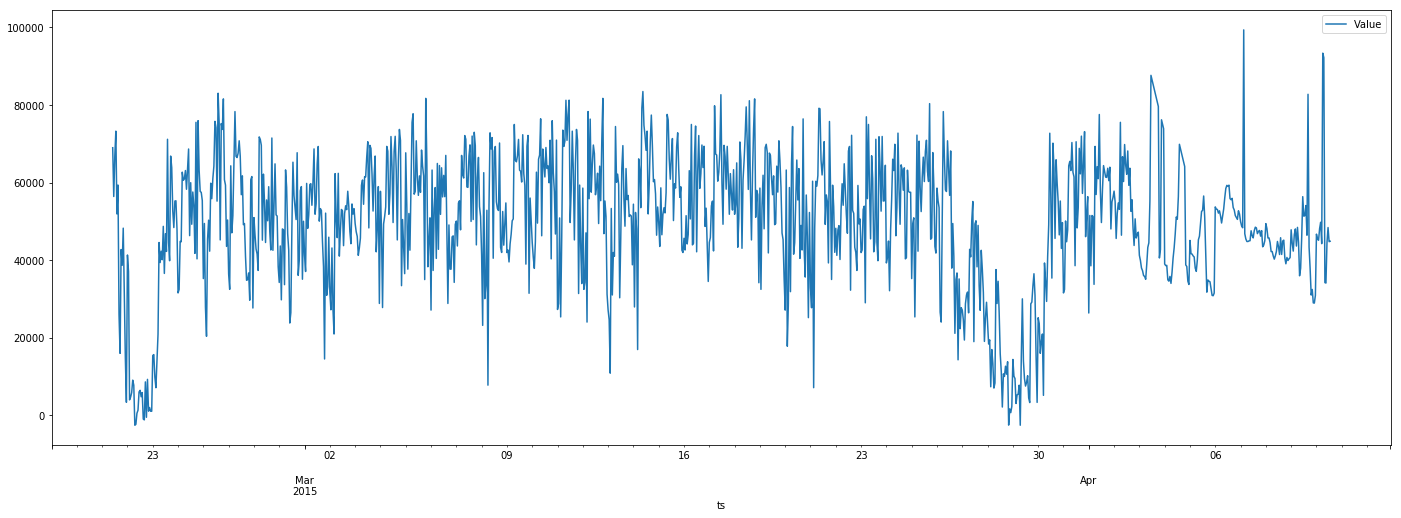

In [69]:
import matplotlib.pyplot as plt
temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

In [65]:
stat_df_temp[['cb_r2_score_val','lgb_r2_score_val','mlp_r2_score_val']]

cb_r2_score_val  lgb_r2_score_val  mlp_r2_score_val
0         0.700113           0.59661          0.270879

In [66]:
stat_df_temp[['cb_rmse_val','lgb_rmse_val','mlp_rmse_val']]

cb_rmse_val  lgb_rmse_val  mlp_rmse_val
0   578.359384    670.782587    896.990653

In [ ]:
stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

# E2E windowed MLP script

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler  

from sklearn import  metrics
from math import sqrt
import tqdm
import time
import hyperopt

# custom utils
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  mlp_fit_log_alg
            
from holidayList import hol_list

LOGNUMBER = 'windowed_mlp_baseline'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

forecast_ids = list(test_lengths.keys())

pd.set_option('mode.chained_assignment', None)

stat_cols = ['forecast_id',
             'mlp_rmse_train','mlp_r2_score_train','mlp_rmse_val','mlp_r2_score_val','time_taken', 
            ]

stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 192.79308104515076


In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,MultiStepLR
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn import Sigmoid, MSELoss

# custom classes
from EDataset import EDataset
from WindowCNN import MLPWindow,LSTMWindow,GRUWindow

import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

# dataset class
def train(train_loader, model, criterion, optimizer, epoch):
    losses = AverageMeter()
    # switch to train mode
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.float().cuda(async=True)
        target = target.float().cuda(async=True)

        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        losses.update(loss.data[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    return losses.avg

def validate(val_loader, model, criterion):
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(val_loader):
        
        input = input.float().cuda(async=True)
        target = target.float().cuda(async=True)
        
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        losses.update(loss.data[0], input.size(0))
    return losses.avg

def predict_train(model,
                 dataset):
    model.eval()

    predict_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=2000,        
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        drop_last=False)    

    scaler = dataset.scaler_y
    
    predicted_values = []
    
    with tqdm.tqdm(total=len(predict_loader)) as pbar:
        for i, (input,target) in enumerate(predict_loader):
            input = input.float().cuda(async=True)
            input_var = torch.autograd.Variable(input, volatile=True)
            output = model(input_var)
            predicted_values.append(output.data.cpu().numpy())
            pbar.update(1)            

    predicted_values = np.asarray(predicted_values)           
    predicted_values = scaler.inverse_transform(predicted_values)
    
    return predicted_values[0,:,0]

def predict_test(model,
                 dataset):
    
    model.eval()

    predict_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,        
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        drop_last=False)    

    scaler = dataset.scaler_y
    
    predicted_values = []
   
    with tqdm.tqdm(total=len(predict_loader)) as pbar:
        for i, (input) in enumerate(predict_loader):
            input = input.float().cuda(async=True)
            input_var = torch.autograd.Variable(input, volatile=True)
            output = model(input_var)
            
            dataset.insert_predict(output.data.cpu().numpy().reshape(-1),
                                   dataset.test_index[i])
            
            predicted_values.append(output.data.cpu().numpy())
            pbar.update(1)            

    predicted_values = np.asarray(predicted_values)           
    predicted_values = scaler.inverse_transform(predicted_values)
    
    return predicted_values

def save_checkpoint(state, is_best, filename, best_filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def slice_train_data(df_train,
                    forecast_id):
    target = 'Value'
    numeric_features = ['temp_diff','Temperature','is_day_off']
    time_features_day = ['dow']
    time_features_hour = ['dow','hour']
    time_features_15min = ['dow','hour','minute']    
    
    temp_df = df_train[(df_train.ForecastId == forecast_id)
                        &(pd.notnull(df_train.Value))]

    # add test set data
    temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])
    temp_df = temp_df.reset_index()
    all_hols = temp_df[hol_list].sum()>0
    non_zero_hols = list(all_hols.index[all_hols == True])
    train_ind = list(temp_df.index)[:-test_lengths[forecast_id]]
    test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]
    prediction_freq = temp_df.ForecastId_type.values[0]
    
    if  prediction_freq == '1_day':
        predictors = numeric_features + non_zero_hols + time_features_day            
    elif prediction_freq == '1_hour':
        predictors = numeric_features + non_zero_hols + time_features_hour
    else: # 15_mins
        predictors = numeric_features + non_zero_hols + time_features_15min     
    
    return temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors        

def train_one_cnn(model = None,
                 forecast_id = 1,
                 lr=1e-4,
                 start_epoch=0,
                 epochs=100,
                 cnn_type='mlp',
                 hidden_layers=256
                 ):
    global df_train
    
    temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)
    
    if model is None:
        if cnn_type=='mlp':
            model = MLPWindow(in_sequence_len = len(train_ind) // 3,
                              out_sequence_len = 1,
                              features_len = len(predictors) + 1,
                              hidden_layer_length = hidden_layers)
        elif cnn_type=='gru':
            model = GRUWindow(in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             features_len = len(predictors) + 1,
                             hidden_size = hidden_layers,
                             num_layers = 2,
                             lstm_dropout = 0.5,
                             use_bnorm = False
                             )
        elif cnn_type=='lstm':
            model = LSTMWindow(in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             features_len = len(predictors) + 1,
                             hidden_size = hidden_layers,
                             num_layers = 2,
                             lstm_dropout = 0.5,
                             use_bnorm = False
                             )
        else:
            print('Model not supported')
            
        model = model.cuda()
    else:
        pass

    
    train_dataset = EDataset(df = temp_df,
                             in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             target = 'Value',
                             predictors = predictors,
                             train_index = train_ind,
                             test_index = test_ind,
                             mode = 'train',
                             split_mode = 'left')

    val_dataset = EDataset(df = temp_df,
                         in_sequence_len = len(train_ind) // 3,
                         out_sequence_len = 1,
                         target = 'Value',
                         predictors = predictors,
                         train_index = train_ind,
                         test_index = test_ind,
                         mode = 'val',
                         split_mode = 'left')
    
    predict_dataset = EDataset(df = temp_df,
                         in_sequence_len = len(train_ind) // 3,
                         out_sequence_len = 1,
                         target = 'Value',
                         predictors = predictors,
                         train_index = train_ind,
                         test_index = test_ind,
                         mode = 'test',
                         split_mode = 'left')    

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2000,        
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        drop_last=False)

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=2000,        
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        drop_last=False)
    
    criterion = MSELoss().cuda()
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr = lr)
    
    scheduler = ReduceLROnPlateau(optimizer = optimizer,
                                              mode = 'min',
                                              factor = 0.1,
                                              patience = 4,
                                              verbose = True,
                                              threshold = 1e-3,
                                              min_lr = 1e-7
                                              )    
    
    with tqdm.tqdm(total=epochs) as pbar:
        for epoch in range(start_epoch, epochs):
            # train for one epoch
            train_loss = train(train_loader, model, criterion, optimizer, epoch)
            # evaluate on validation set
            val_loss = validate(val_loader, model, criterion)
            scheduler.step(val_loss)
            pbar.set_description('Epoch [{0}/{1}]'.format(str(epoch).zfill(3),str(epochs).zfill(3)), refresh=False)
            pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, refresh=False)
            pbar.update(1)
    
    train_preds =  predict_train(model,
                                 train_dataset)
    
    val_preds =  predict_train(model,
                                 val_dataset)  
        
    # evaluate metrics on the train dataset
    true_train_values = temp_df.loc[list(range(len(train_ind) // 3 + 1 + train_dataset.dataset_len // 4, len(train_ind) )), 'Value'].values
    
    rmse_train = sqrt(metrics.mean_squared_error(true_train_values, train_preds))
    r2_score_train = metrics.r2_score(true_train_values, train_preds)
    
    # evaluate metrics on the val dataset
    true_val_values = temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + val_dataset.dataset_len // 4)), 'Value'].values
    
    print(true_val_values.shape)
    print(val_preds.shape)
    
    rmse_val = sqrt(metrics.mean_squared_error(true_val_values, val_preds))
    r2_score_val = metrics.r2_score(true_val_values, val_preds)
    
    test_preds = predict_test(model,predict_dataset)
    
    return model,train_preds,val_preds,test_preds,rmse_train,r2_score_train,rmse_val,r2_score_val

In [17]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        # try:
        forecast_id = 6801
        
        temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)
        dataset_len = len(train_ind) - 1 - len(train_ind) // 3
           
        model,train_preds_mlp,val_preds_mlp,test_preds_mlp,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
                     forecast_id = forecast_id,
                     lr=1e-3,
                     start_epoch=0,
                     epochs=30,
                     cnn_type='mlp',
                     hidden_layers=256
                     )

        temp_df['mlp'] = 0
        temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'mlp'] = train_preds_mlp
        temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'mlp'] = val_preds_mlp
        temp_df.loc[test_ind, 'mlp'] = test_preds_mlp[:,0,0]

        # set the predictions in the prediction df
        obs_ids = list(temp_df.loc[test_ind].obs_id)
        predictions = list(temp_df.loc[test_ind].mlp)
        submission_df.loc[obs_ids,'Value'] = predictions        

        elapsed_time = time.time() - start_time 

        stat_df_temp = pd.DataFrame(columns=stat_cols)
        stat_df_temp['forecast_id'] = [forecast_id]

        stat_df_temp['mlp_rmse_train'] = [rmse_train]
        stat_df_temp['mlp_r2_score_train'] = [r2_score_train]
        stat_df_temp['mlp_rmse_val'] = [rmse_val]
        stat_df_temp['mlp_r2_score_val'] = [r2_score_val]
        stat_df_temp['time_taken'] = [elapsed_time]            

        stat_df = stat_df.append(stat_df_temp)            

        if i%500 == 1:
            stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
            submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
            print('Iteration {}, logs saved'.format(i))
        pbar.update(1)
        """
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions
        """
        break

Epoch [026/030]:  90%|█████████ | 27/30 [00:04<00:00,  5.75it/s, train_loss=0.0958, val_loss=0.235]

Epoch    26: reducing learning rate of group 0 to 1.0000e-04.



Epoch [029/030]: 100%|██████████| 30/30 [00:04<00:00,  6.39it/s, train_loss=0.0938, val_loss=0.197]

  0%|          | 0/192 [00:00<?, ?it/s]

(160,)
(160,)



  0%|          | 1/6974 [00:05<10:15:55,  5.30s/it][A


In [20]:
submission_df.loc[obs_ids] 

SiteId            Timestamp  ForecastId         Value
obs_id                                                        
2162231     302  2012-05-14 12:15:00        6801  44350.332031
7823178     302  2012-05-14 12:30:00        6801  44311.578125
3121682     302  2012-05-14 12:45:00        6801  44291.480469
814883      302  2012-05-14 13:00:00        6801  44276.488281
7026525     302  2012-05-14 13:15:00        6801  44267.109375
2633407     302  2012-05-14 13:30:00        6801  44248.683594
2989527     302  2012-05-14 13:45:00        6801  44270.105469
493978      302  2012-05-14 14:00:00        6801  44251.523438
2652978     302  2012-05-14 14:15:00        6801  44226.816406
1332841     302  2012-05-14 14:30:00        6801  44207.976562
3912642     302  2012-05-14 14:45:00        6801  44188.464844
2172898     302  2012-05-14 15:00:00        6801  44188.269531
59609       302  2012-05-14 15:15:00        6801  44190.144531
5099652     302  2012-05-14 15:30:00        6801  44183.781250
7150199     302  2012-05-14 15:45:00        6801  44156.835938
674504      302  2012-05-14 16:00:00        6801  44189.312500
6783198     302  2012-05-14 16:15:00        6801  44176.007812
6017727     302  2012-05-14 16:30:00        6801  44160.960938
3464288     302  2012-05-14 16:45:00        6801  44170.320312
6069545     302  2012-05-14 17:00:00        6801  44151.679688
981499      302  2012-05-14 17:15:00        6801  44141.945312
5460960     302  2012-05-14 17:30:00        6801  44147.300781
1898537     302  2012-05-14 17:45:00        6801  44142.187500
6500441     302  2012-05-14 18:00:00        6801  44139.656250
4522047     302  2012-05-14 18:15:00        6801  44105.292969
6219784     302  2012-05-14 18:30:00        6801  44105.613281
2614668     302  2012-05-14 18:45:00        6801  44095.507812
3650811     302  2012-05-14 19:00:00        6801  44098.621094
6984962     302  2012-05-14 19:15:00        6801  44071.406250
606045      302  2012-05-14 19:30:00        6801  44079.125000
...         ...                  ...         ...           ...
1852585     302  2012-05-16 04:45:00        6801  43727.308594
4676840     302  2012-05-16 05:00:00        6801  43719.628906
1540732     302  2012-05-16 05:15:00        6801  43749.867188
400959      302  2012-05-16 05:30:00        6801  43751.816406
4795342     302  2012-05-16 05:45:00        6801  43765.085938
5815913     302  2012-05-16 06:00:00        6801  43737.941406
7612752     302  2012-05-16 06:15:00        6801  43771.066406
5947581     302  2012-05-16 06:30:00        6801  43818.597656
6126088     302  2012-05-16 06:45:00        6801  43800.949219
6109570     302  2012-05-16 07:00:00        6801  43792.375000
1070510     302  2012-05-16 07:15:00        6801  43773.726562
6119551     302  2012-05-16 07:30:00        6801  43768.335938
6978046     302  2012-05-16 07:45:00        6801  43777.882812
4876289     302  2012-05-16 08:00:00        6801  43771.789062
1168059     302  2012-05-16 08:15:00        6801  43759.585938
4964442     302  2012-05-16 08:30:00        6801  43756.511719
7558556     302  2012-05-16 08:45:00        6801  43744.117188
3775434     302  2012-05-16 09:00:00        6801  43726.082031
5894321     302  2012-05-16 09:15:00        6801  43683.234375
5954414     302  2012-05-16 09:30:00        6801  43671.765625
4532123     302  2012-05-16 09:45:00        6801  43646.531250
7205903     302  2012-05-16 10:00:00        6801  43636.617188
7207396     302  2012-05-16 10:15:00        6801  43572.578125
5869062     302  2012-05-16 10:30:00        6801  43584.300781
7363651     302  2012-05-16 10:45:00        6801  43577.703125
3718150     302  2012-05-16 11:00:00        6801  43592.164062
3807631     302  2012-05-16 11:15:00        6801  43546.589844
6231327     302  2012-05-16 11:30:00        6801  43536.230469
3569782     302  2012-05-16 11:45:00        6801  43542.527344
6054474     302  2012-05-16 12:00:00        6801  43529.554688

[192 rows x 4 columns]

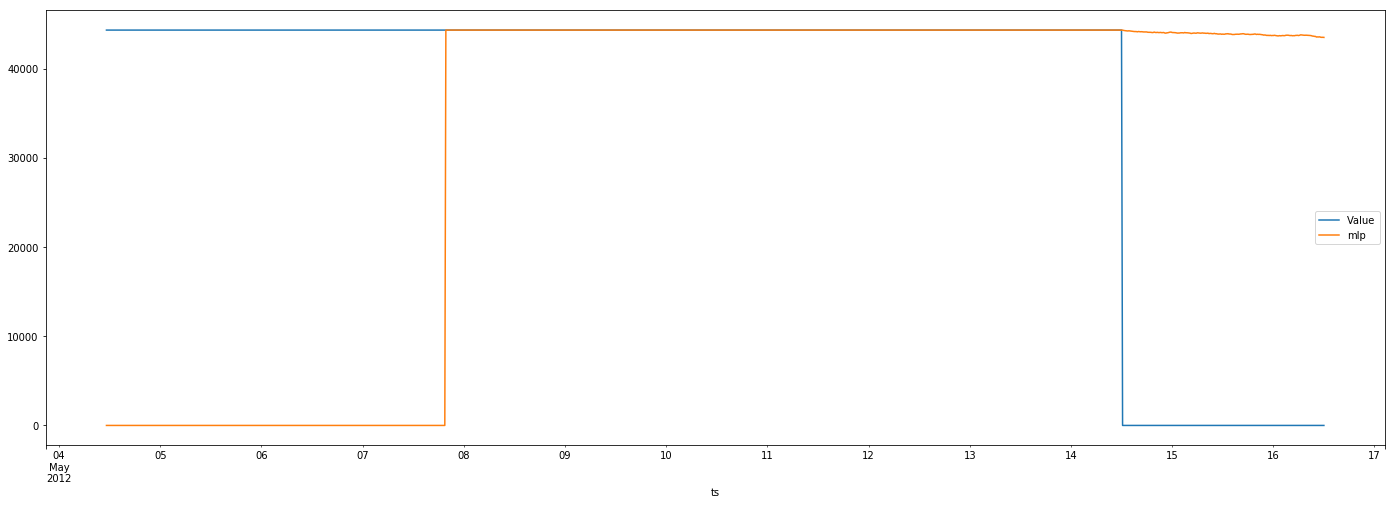

In [21]:
import matplotlib.pyplot as plt

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','mlp']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

In [ ]:
stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

# Try MLP for window data + deeper CNNs

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

from sklearn import  metrics
from math import sqrt
import tqdm
import time
import hyperopt

# custom utils
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  mlp_fit_log_alg
            
from holidayList import hol_list

from params import xgb_params,cbr_params,lgb_params,mlp_params

LOGNUMBER = 'cnn_baseline'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

forecast_ids = list(test_lengths.keys())

pd.set_option('mode.chained_assignment', None)

stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',         
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 164.98845624923706


In [31]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        forecast_id = 1500
        # try:
        temp_df = df_train[(df_train.ForecastId == forecast_id)
                            &(pd.notnull(df_train.Value))]

        # add test set data
        temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])

        temp_df = produce_ar_features(temp_df)
        temp_df = temp_df.reset_index()

        # test forests
        all_hols = temp_df[hol_list].sum()>0
        non_zero_hols = list(all_hols.index[all_hols == True])

        val_ind = list(temp_df.index)[:test_lengths[forecast_id]]
        train_ind = list(temp_df.index)[test_lengths[forecast_id]:-test_lengths[forecast_id]]
        test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]

        prediction_freq = temp_df.ForecastId_type.values[0]
        if  prediction_freq == '1_day':
            predictors = numeric_features + non_zero_hols + time_features_day            
        elif prediction_freq == '1_hour':
            predictors = numeric_features + non_zero_hols + time_features_hour
        else: # 15_mins
            predictors = numeric_features + non_zero_hols + time_features_15min     

        cbr = CatBoostRegressor(**cbr_params)
        lgb = LGBMRegressor(**lgb_params)

        start_time = time.time()

        cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                 temp_df.filter(items=train_ind,axis=0),
                 temp_df.filter(items=val_ind,axis=0),                
                 predictors)

        lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                 temp_df.filter(items=train_ind,axis=0),
                 temp_df.filter(items=val_ind,axis=0),                
                 predictors)            

        # simple voting rule
        # choose the regressor with better score
        #  if cb_rmse_val<lgb_rmse_val:
        #     # print('CB chosen')
        #     temp_df['Value'] = cbr.predict(temp_df[predictors])
        # else:
        #     # print('LGB chosen')
        #     temp_df['Value'] = lgb.predict(temp_df[predictors])

        # set the predictions in the prediction df
        obs_ids = list(temp_df.loc[test_ind].obs_id)
        predictions = list(temp_df.loc[test_ind].Value)
        submission_df.loc[obs_ids,'Value'] = predictions        

        elapsed_time = time.time() - start_time 

        stat_df_temp = pd.DataFrame(columns=stat_cols)
        stat_df_temp['forecast_id'] = [forecast_id]

        stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
        stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
        stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
        stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
        stat_df_temp['cb_scores'] = [cb_scores]

        stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
        stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
        stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
        stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
        stat_df_temp['lgb_scores'] = [lgb_scores]

        stat_df_temp['time_taken'] = [elapsed_time]            

        stat_df = stat_df.append(stat_df_temp)            

        if i%500 == 1:
            stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
            submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
            print('Iteration {}, logs saved'.format(i))
        pbar.update(1)
        """
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions
        """
        break

  0%|          | 1/6974 [00:05<10:06:56,  5.22s/it]


In [32]:
pred = cbr.predict(temp_df[predictors])
temp_df['cb_pred'] = pred
pred = lgb.predict(temp_df[predictors])
temp_df['lgb_pred'] = pred

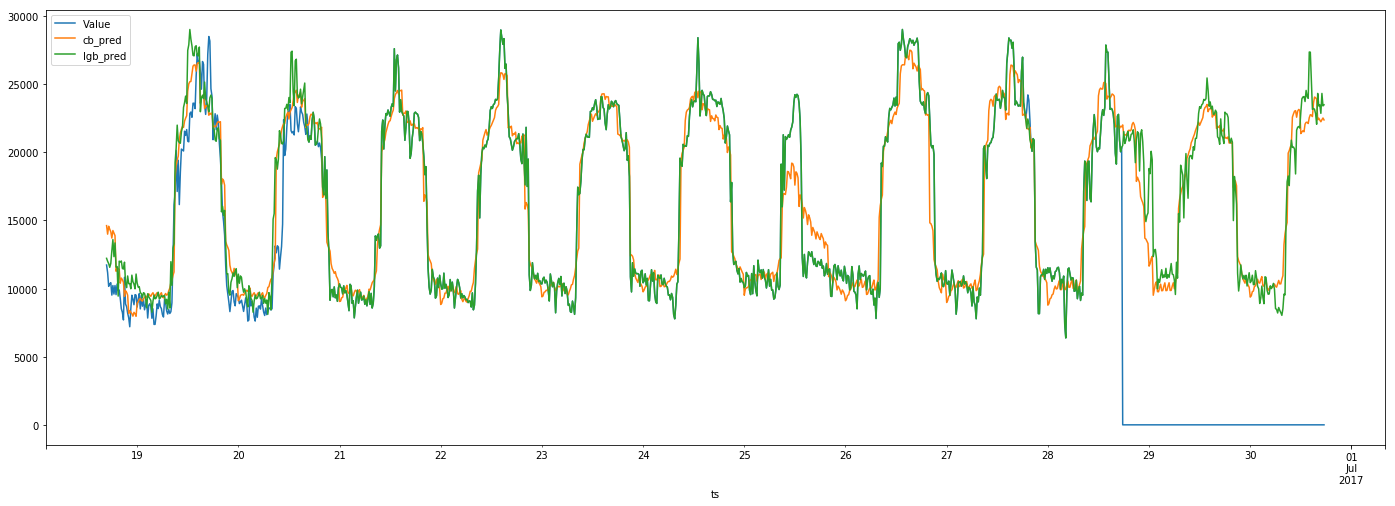

In [34]:
import matplotlib.pyplot as plt

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','cb_pred','lgb_pred']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

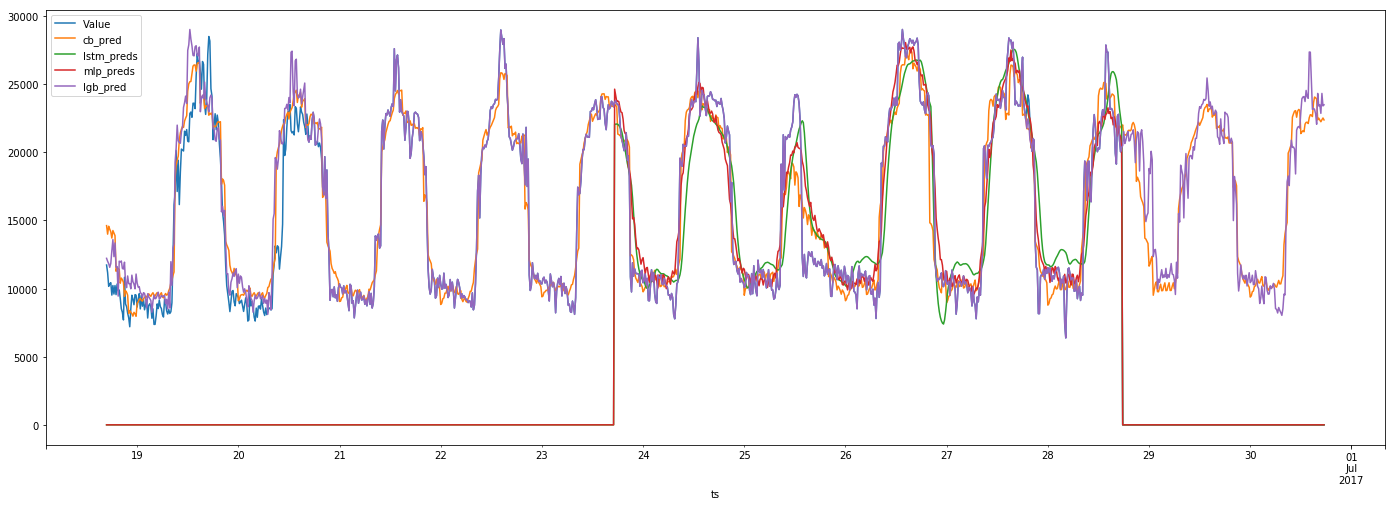

In [40]:
import matplotlib.pyplot as plt

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','cb_pred','lstm_preds','mlp_preds','lgb_pred']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

In [102]:
import argparse
import os
import shutil
import time
import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,MultiStepLR
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn import Sigmoid, MSELoss

import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics

# custom classes
# from EDataset import EDataset
from WindowCNN import MLPWindow,LSTMWindow,GRUWindow

import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

# dataset class
class EDataset(data.Dataset):
    def __init__(self,
                 df = None,
                 in_sequence_len = 192,
                 out_sequence_len = 1,
                 target = 'Value',
                 predictors = [],
                 train_index = [],
                 test_index = [],
                 mode = 'train', # train, val or test
                 split_mode = 'random', # random or left
                 ):
        
        self.mode = mode
        self.df = df
        self.train_index = train_index
        self.test_index = test_index
        self.in_sequence_len = in_sequence_len
        self.out_sequence_len = out_sequence_len
        self.values = df[predictors + [target]].values
        self.targets = df[target].values
        self.dataset_len = len(train_index) - in_sequence_len - out_sequence_len
        
        scaler = StandardScaler()
        scaler_y = StandardScaler()
        
        self.scaler = scaler.fit(df.loc[train_index,predictors+[target]].values)  
        self.scaler_y = scaler_y.fit(df.loc[train_index,target].values.reshape(-1, 1)) 
        
        if split_mode == 'random':
            train_ds_ind, val_ds_ind = train_test_split(range(0,self.dataset_len),
                                                       random_state = 42,
                                                       shuffle = True,
                                                       test_size = 0.25)
            self.train_ds_ind = train_ds_ind
            self.val_ds_ind = val_ds_ind
        elif split_mode == 'left':
            self.train_ds_ind = list(range(0,self.dataset_len))[self.dataset_len // 4 : ]
            self.val_ds_ind = list(range(0,self.dataset_len))[ : self.dataset_len // 4]        
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_ds_ind) 
        elif self.mode == 'val':
            return len(self.val_ds_ind) 
        elif self.mode == 'test':
            return len(self.test_index)
        
        
    def insert_predict(self,
                       prediction,
                       idx,
                       col=-1):
        self.values[idx,col] = prediction

    def __getitem__(self, idx):
        if self.mode == 'train':
            # print(self.train_ds_ind[idx],self.train_ds_ind[idx] + self.in_sequence_len)
            # print(self.train_ds_ind[idx] + self.in_sequence_len,self.train_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len)
            X = self.values[self.train_ds_ind[idx] : self.train_ds_ind[idx] + self.in_sequence_len]
            X = self.scaler.transform(X)
            y = self.targets [self.train_ds_ind[idx] + self.in_sequence_len : self.train_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len]
            y = self.scaler_y.transform(y.reshape(-1, 1))
            return X,y
        elif self.mode == 'val':
            # print(self.val_ds_ind[idx],self.val_ds_ind[idx] + self.in_sequence_len)
            # print(self.val_ds_ind[idx] + self.in_sequence_len,self.val_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len)            
            X = self.values[self.val_ds_ind[idx] : self.val_ds_ind[idx] + self.in_sequence_len]
            X = self.scaler.transform(X)
            y = self.targets [self.val_ds_ind[idx] + self.in_sequence_len : self.val_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len]
            y = self.scaler_y.transform(y.reshape(-1, 1))
            return X,y         
        elif self.mode == 'test':
            # print(self.test_index[idx] - self.in_sequence_len)
            # print( self.test_index[idx])
            X = self.values[self.test_index[idx] - self.in_sequence_len : self.test_index[idx]]
            X = self.scaler.transform(X)
            return X

def train(train_loader, model, criterion, optimizer, epoch):
    losses = AverageMeter()
    # switch to train mode
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.float().cuda(async=True)
        target = target.float().cuda(async=True)

        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        losses.update(loss.data[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    return losses.avg

def validate(val_loader, model, criterion):
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(val_loader):
        
        input = input.float().cuda(async=True)
        target = target.float().cuda(async=True)
        
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        losses.update(loss.data[0], input.size(0))
    return losses.avg

def predict_train(model,
                 dataset):
    model.eval()

    predict_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=2000,        
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        drop_last=False)    

    scaler = dataset.scaler_y
    
    predicted_values = []
    
    print('Running predictions')
    
    with tqdm.tqdm(total=len(predict_loader)) as pbar:
        for i, (input,target) in enumerate(predict_loader):
            input = input.float().cuda(async=True)
            input_var = torch.autograd.Variable(input, volatile=True)
            output = model(input_var)
            predicted_values.append(output.data.cpu().numpy())
            pbar.update(1)            

    print(len(predicted_values))
    predicted_values = np.asarray(predicted_values)           
    predicted_values = scaler.inverse_transform(predicted_values)
    
    return predicted_values[0,:,0]

def predict_test(model,
                 dataset):
    
    model.eval()

    predict_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,        
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        drop_last=False)    

    scaler = dataset.scaler_y
    
    predicted_values = []
    
    print('Running predictions')
    
    with tqdm.tqdm(total=len(predict_loader)) as pbar:
        for i, (input) in enumerate(predict_loader):
            input = input.float().cuda(async=True)
            input_var = torch.autograd.Variable(input, volatile=True)
            output = model(input_var)
            
            dataset.insert_predict(output.data.cpu().numpy().reshape(-1),
                                   dataset.test_index[i])
            
            predicted_values.append(output.data.cpu().numpy())
            pbar.update(1)            

    predicted_values = np.asarray(predicted_values)           
    predicted_values = scaler.inverse_transform(predicted_values)
    
    return predicted_values

def save_checkpoint(state, is_best, filename, best_filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def slice_train_data(df_train,
                    forecast_id):
    target = 'Value'
    numeric_features = ['temp_diff','Temperature','is_day_off']
    time_features_day = ['dow']
    time_features_hour = ['dow','hour']
    time_features_15min = ['dow','hour','minute']    
    
    temp_df = df_train[(df_train.ForecastId == forecast_id)
                        &(pd.notnull(df_train.Value))]

    # add test set data
    temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])
    temp_df = temp_df.reset_index()
    all_hols = temp_df[hol_list].sum()>0
    non_zero_hols = list(all_hols.index[all_hols == True])
    train_ind = list(temp_df.index)[:-test_lengths[forecast_id]]
    test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]
    prediction_freq = temp_df.ForecastId_type.values[0]
    
    if  prediction_freq == '1_day':
        predictors = numeric_features + non_zero_hols + time_features_day            
    elif prediction_freq == '1_hour':
        predictors = numeric_features + non_zero_hols + time_features_hour
    else: # 15_mins
        predictors = numeric_features + non_zero_hols + time_features_15min     
    
    return temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors        

def train_one_cnn(model = None,
                 forecast_id = 1,
                 lr=1e-4,
                 start_epoch=0,
                 epochs=100,
                 cnn_type='mlp',
                 hidden_layers=256
                 ):
    global df_train
    
    temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)
    
    if model is None:
        if cnn_type=='mlp':
            model = MLPWindow(in_sequence_len = len(train_ind) // 3,
                              out_sequence_len = 1,
                              features_len = len(predictors) + 1,
                              hidden_layer_length = hidden_layers)
        elif cnn_type=='gru':
            model = GRUWindow(in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             features_len = len(predictors) + 1,
                             hidden_size = hidden_layers,
                             num_layers = 2,
                             lstm_dropout = 0.5,
                             use_bnorm = False
                             )
        elif cnn_type=='lstm':
            model = LSTMWindow(in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             features_len = len(predictors) + 1,
                             hidden_size = hidden_layers,
                             num_layers = 2,
                             lstm_dropout = 0.5,
                             use_bnorm = False
                             )
        else:
            print('Model not supported')
            
        model = model.cuda()
    else:
        pass

    
    train_dataset = EDataset(df = temp_df,
                             in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             target = 'Value',
                             predictors = predictors,
                             train_index = train_ind,
                             test_index = test_ind,
                             mode = 'train',
                             split_mode = 'left')

    val_dataset = EDataset(df = temp_df,
                         in_sequence_len = len(train_ind) // 3,
                         out_sequence_len = 1,
                         target = 'Value',
                         predictors = predictors,
                         train_index = train_ind,
                         test_index = test_ind,
                         mode = 'val',
                         split_mode = 'left')
    
    predict_dataset = EDataset(df = temp_df,
                         in_sequence_len = len(train_ind) // 3,
                         out_sequence_len = 1,
                         target = 'Value',
                         predictors = predictors,
                         train_index = train_ind,
                         test_index = test_ind,
                         mode = 'test',
                         split_mode = 'left')    

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2000,        
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        drop_last=False)

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=2000,        
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        drop_last=False)
    
    criterion = MSELoss().cuda()
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr = lr)
    
    scheduler = ReduceLROnPlateau(optimizer = optimizer,
                                              mode = 'min',
                                              factor = 0.1,
                                              patience = 4,
                                              verbose = True,
                                              threshold = 1e-3,
                                              min_lr = 1e-7
                                              )    
    
    with tqdm.tqdm(total=epochs) as pbar:
        for epoch in range(start_epoch, epochs):
            # train for one epoch
            train_loss = train(train_loader, model, criterion, optimizer, epoch)
            # evaluate on validation set
            val_loss = validate(val_loader, model, criterion)
            scheduler.step(val_loss)
            pbar.set_description('Epoch [{0}/{1}]'.format(str(epoch).zfill(3),str(epochs).zfill(3)), refresh=False)
            pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, refresh=False)
            pbar.update(1)
    
    train_preds =  predict_train(model,
                                 train_dataset)
    
    val_preds =  predict_train(model,
                                 val_dataset)  
        
    # evaluate metrics on the train dataset
    true_train_values = temp_df.loc[list(range(len(train_ind) // 3 + 1 + train_dataset.dataset_len // 4, len(train_ind) )), 'Value'].values
    
    rmse_train = sqrt(metrics.mean_squared_error(true_train_values, train_preds))
    r2_score_train = metrics.r2_score(true_train_values, train_preds)
    
    # evaluate metrics on the val dataset
    true_val_values = temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + val_dataset.dataset_len // 4)), 'Value'].values
    
    print(true_val_values.shape)
    print(val_preds.shape)
    
    rmse_val = sqrt(metrics.mean_squared_error(true_val_values, val_preds))
    r2_score_val = metrics.r2_score(true_val_values, val_preds)
    
    test_preds = predict_test(model,predict_dataset)
    
    return model,train_preds,val_preds,test_preds,rmse_train,r2_score_train,rmse_val,r2_score_val

In [36]:
import gc

del model
gc.collect()
torch.cuda.empty_cache()


In [79]:
len(train_ind)

958

In [ ]:
forecast_id = 1500

temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)
dataset_len = len(train_ind) - 1 - len(train_ind) // 3

model,train_preds_lstm,val_preds_lstm,test_preds_lstm,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
             forecast_id = forecast_id,
             lr=1e-3,
             start_epoch=0,
             epochs=30,
             cnn_type='lstm',
             hidden_layers=256
             )
print(rmse_train,r2_score_train,rmse_val,r2_score_val)



temp_df['lstm'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'lstm'] = train_preds_lstm
temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'lstm'] = val_preds_lstm
temp_df.loc[test_ind, 'lstm'] = test_preds_lstm[:,0,0]




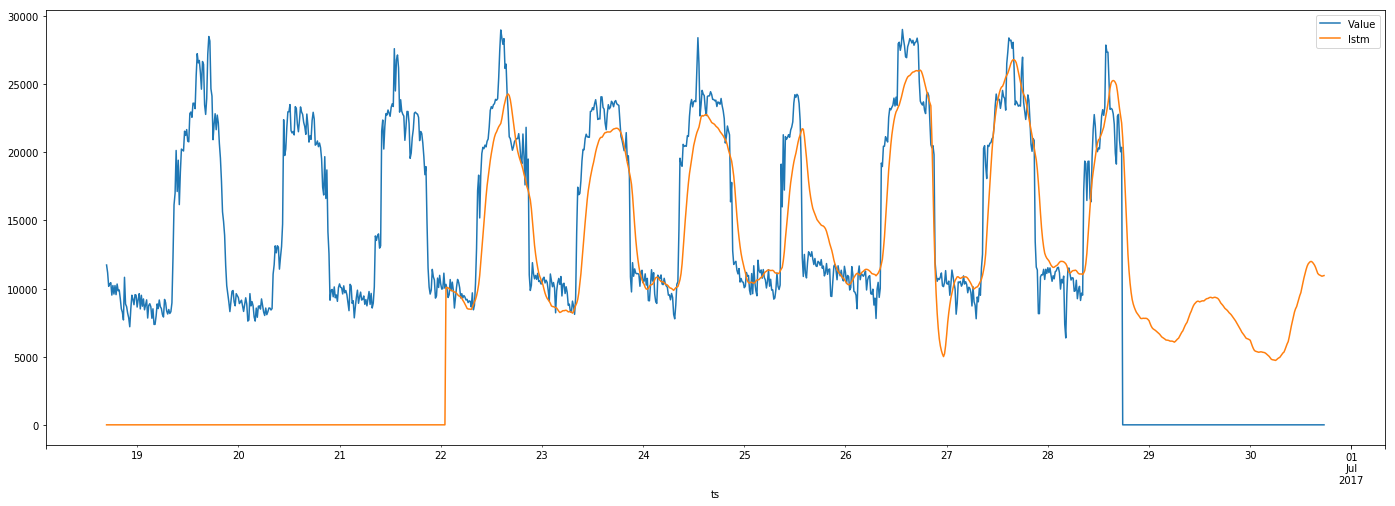

In [152]:
temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','lstm']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

Epoch [026/030]:  90%|█████████ | 27/30 [00:03<00:00,  7.11it/s, train_loss=0.108, val_loss=0.733]

Epoch    26: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/1 [00:00<?, ?it/s]

Running predictions


  0%|          | 0/1 [00:00<?, ?it/s]

1
Running predictions


  0%|          | 0/192 [00:00<?, ?it/s]

1
(153,)
(153,)
Running predictions


100%|██████████| 192/192 [00:00<00:00, 1148.51it/s]


17101.28224770819 0.8397638130994604 44023.58370459912 0.037760031777132386


Epoch [017/030]:  60%|██████    | 18/30 [00:07<00:05,  2.39it/s, train_loss=0.211, val_loss=0.308]

Epoch    17: reducing learning rate of group 0 to 1.0000e-04.


Epoch [022/030]:  77%|███████▋  | 23/30 [00:09<00:02,  2.41it/s, train_loss=0.199, val_loss=0.287]

Epoch    22: reducing learning rate of group 0 to 1.0000e-05.


Epoch [027/030]:  93%|█████████▎| 28/30 [00:11<00:00,  2.42it/s, train_loss=0.193, val_loss=0.284]

Epoch    27: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/1 [00:00<?, ?it/s]

Running predictions


  0%|          | 0/1 [00:00<?, ?it/s]

1
Running predictions


  0%|          | 0/192 [00:00<?, ?it/s]

1
(153,)
(153,)
Running predictions


  0%|          | 0/30 [00:00<?, ?it/s]

23682.953169147382 0.692691222949205 29720.590851065157 0.5614415492202258


Epoch [015/030]:  53%|█████▎    | 16/30 [00:05<00:04,  2.85it/s, train_loss=0.203, val_loss=0.275]

Epoch    15: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/1 [00:00<?, ?it/s]

Running predictions


  0%|          | 0/1 [00:00<?, ?it/s]

1
Running predictions


  0%|          | 0/192 [00:00<?, ?it/s]

1
(153,)
(153,)
Running predictions


100%|██████████| 192/192 [00:01<00:00, 119.44it/s]


22649.869132021377 0.7189169573376553 27710.28425812663 0.6187634175062529


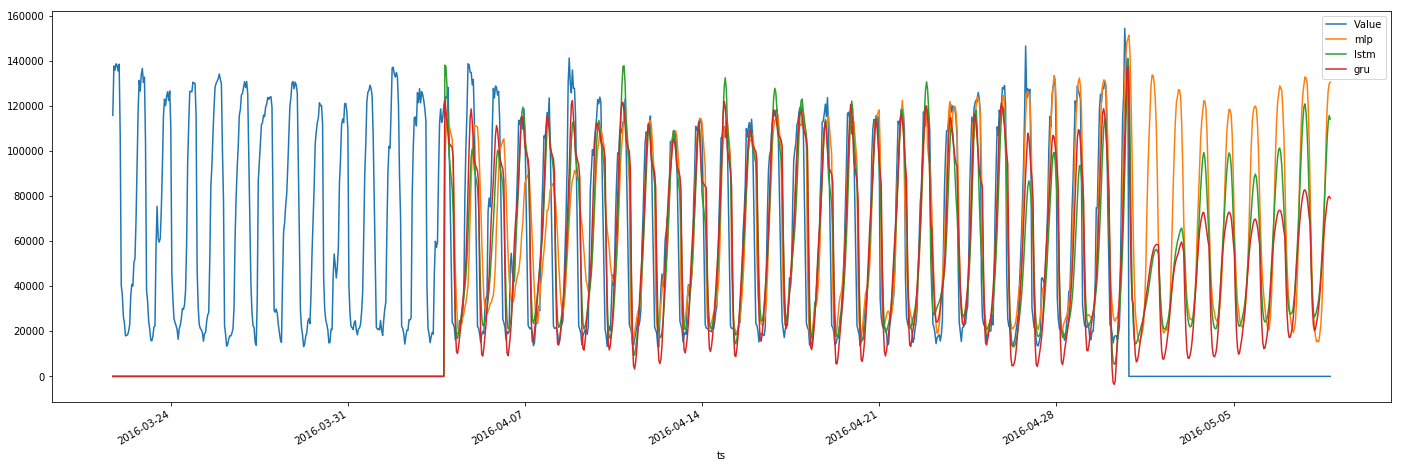

In [157]:
forecast_id = 2000

temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)
dataset_len = len(train_ind) - 1 - len(train_ind) // 3

model,train_preds_mlp,val_preds_mlp,test_preds_mlp,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
             forecast_id = forecast_id,
             lr=1e-3,
             start_epoch=0,
             epochs=30,
             cnn_type='mlp',
             hidden_layers=256
             )

print(rmse_train,r2_score_train,rmse_val,r2_score_val)

temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)

model,train_preds_lstm,val_preds_lstm,test_preds_lstm,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
             forecast_id = forecast_id,
             lr=1e-3,
             start_epoch=0,
             epochs=30,
             cnn_type='lstm',
             hidden_layers=256
             )
print(rmse_train,r2_score_train,rmse_val,r2_score_val)

temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)

model,train_preds_gru,val_preds_gru,test_preds_gru,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
             forecast_id = forecast_id,
             lr=1e-3,
             start_epoch=0,
             epochs=30,
             cnn_type='gru',
             hidden_layers=256
             )
print(rmse_train,r2_score_train,rmse_val,r2_score_val)


temp_df['lstm'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'lstm'] = train_preds_lstm
temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'lstm'] = val_preds_lstm
temp_df.loc[test_ind, 'lstm'] = test_preds_lstm[:,0,0]
temp_df['mlp'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'mlp'] = train_preds_mlp
temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'mlp'] = val_preds_mlp
temp_df.loc[test_ind, 'mlp'] = test_preds_mlp[:,0,0]
temp_df['gru'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'gru'] = train_preds_gru
temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'gru'] = val_preds_gru
temp_df.loc[test_ind, 'gru'] = test_preds_gru[:,0,0]

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','mlp','lstm','gru']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

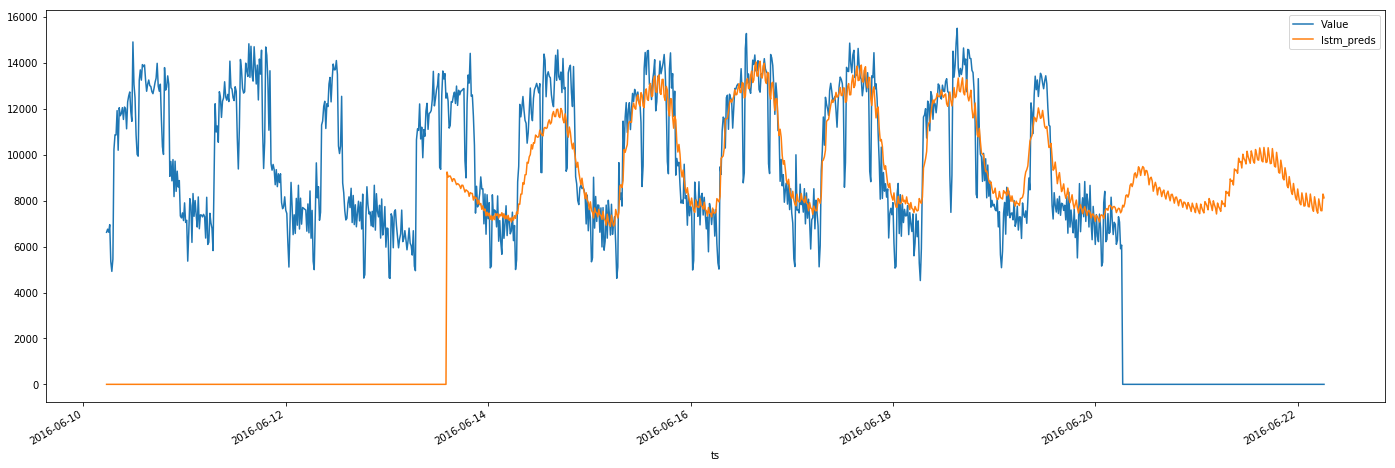

In [144]:
import matplotlib.pyplot as plt

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','lstm_preds']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

In [86]:
test_preds.shape

(192, 1, 1)

In [83]:
len(train_preds),len(val_preds),len(test_preds)

(479, 159, 192)

In [43]:
forecast_id = 6700

temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)

model,train_preds,val_preds,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
             forecast_id = forecast_id,
             lr=1e-3,
             start_epoch=0,
             epochs=30,
             cnn_type='lstm',
             hidden_layers=256
             )

print(rmse_train,r2_score_train,rmse_val,r2_score_val)

dataset_len = len(train_ind) - 1 - len(train_ind) // 3
temp_df['lstm_preds'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'lstm_preds'] = train_preds
temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'lstm_preds'] = val_preds


model,train_preds,val_preds,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
             forecast_id = forecast_id,
             lr=1e-3,
             start_epoch=0,
             epochs=30,
             cnn_type='mlp',
             hidden_layers=256
             )

print(rmse_train,r2_score_train,rmse_val,r2_score_val)

dataset_len = len(train_ind) - 1 - len(train_ind) // 3
temp_df['mlp_preds'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'mlp_preds'] = train_preds
temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'mlp_preds'] = val_preds

model,train_preds,val_preds,rmse_train,r2_score_train,rmse_val,r2_score_val = train_one_cnn(model = None,
             forecast_id = forecast_id,
             lr=1e-3,
             start_epoch=0,
             epochs=30,
             cnn_type='gru',
             hidden_layers=256
             )

print(rmse_train,r2_score_train,rmse_val,r2_score_val)

dataset_len = len(train_ind) - 1 - len(train_ind) // 3
temp_df['gru_preds'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'gru_preds'] = train_preds
temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'gru_preds'] = val_preds

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','mlp_preds','lstm_preds','gru_preds']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

Epoch [028/030]:  97%|█████████▋| 29/30 [00:14<00:00,  1.96it/s, train_loss=0.132, val_loss=0.164]

Epoch    28: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/1 [00:00<?, ?it/s]

Running predictions


  0%|          | 0/1 [00:00<?, ?it/s]

1
Running predictions


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


1
(160,)
(159,)


ValueError: Found input variables with inconsistent numbers of samples: [160, 159]

In [62]:
train_preds.shape

(1, 481, 1)

In [171]:
len(list(range(len(train_ind) // 3 + 1 +  dataset_len // 4, len(train_ind) )))

482

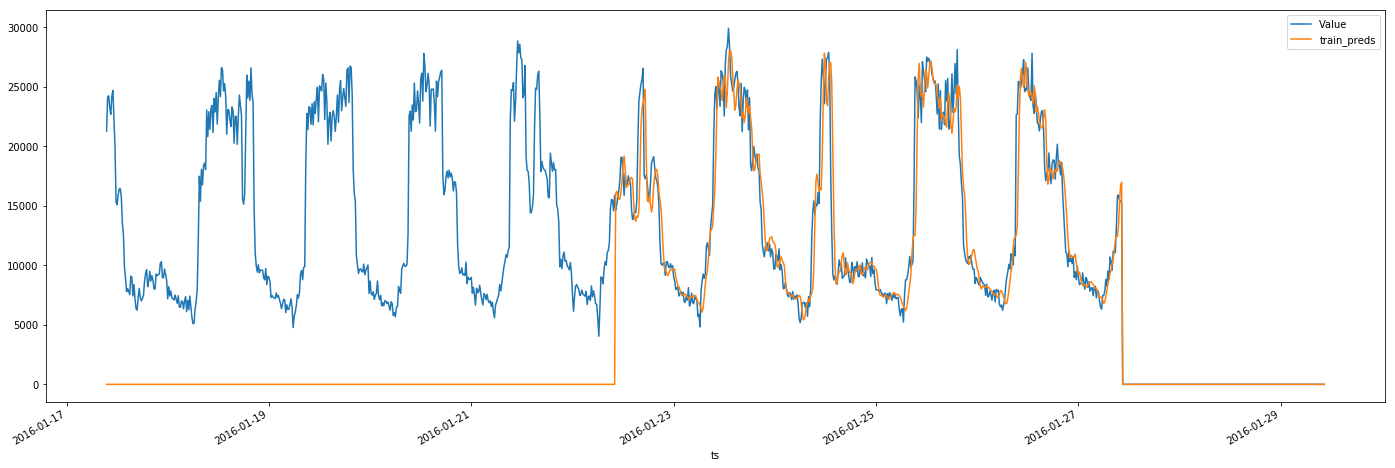

In [64]:
import matplotlib.pyplot as plt

dataset_len = len(train_ind) - 1 - len(train_ind) // 3
temp_df['train_preds'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'train_preds'] = train_preds[0,:,0]

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','train_preds']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

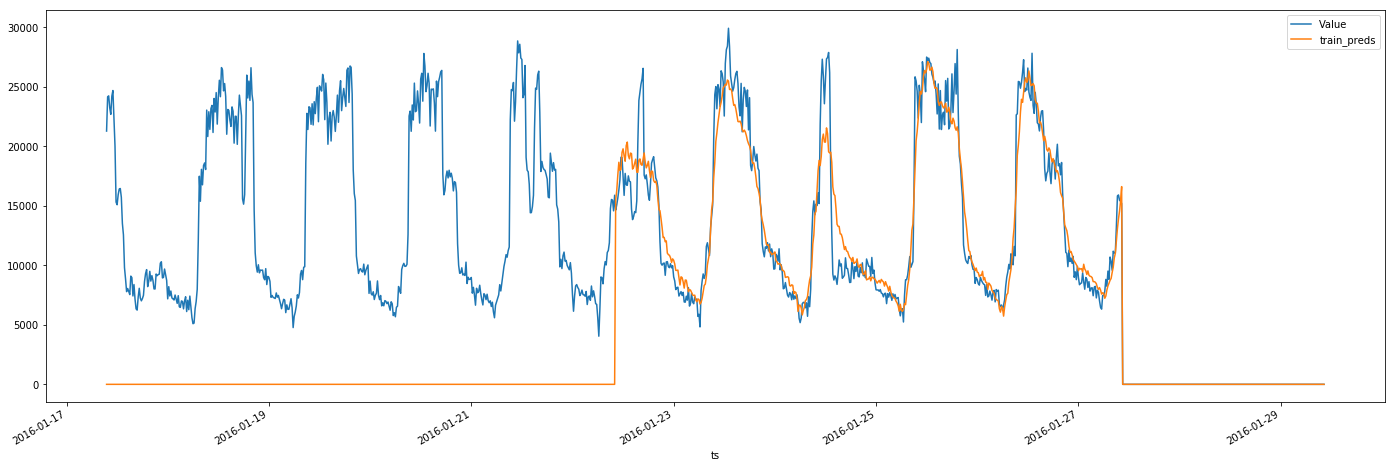

In [173]:
import matplotlib.pyplot as plt

temp_df['train_preds'] = 0
temp_df.loc[list(range(len(train_ind) // 3 + 2 + dataset_len // 4, len(train_ind) )), 'train_preds'] = train_preds[0,:,0]

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','train_preds']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

959

[479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 638,
 639,
 640,
 641,
 642,
 643,
 644,
 645

In [93]:
959 - (len(train_ind) // 3 + 1 + dataset_len // 4)

480

In [88]:
len(train_ind) - len(train_ind) // 3 - 1

639

In [83]:
dataset_len

639

In [82]:
dataset_len - 159

480

In [80]:
dataset_len // 4

159

In [ ]:
1151 

In [76]:
temp_df.shape

(1151, 131)

In [75]:
train_preds.shape

(1, 480, 1)

In [ ]:
train_one_cnn(3569,
             lr=1e-2,
             start_epoch=0,
             epochs=1000,
             cnn_type='mlp',
             hidden_layers=256
             )

In [6]:
forecast_id = 3569
temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data(df_train,forecast_id)

In [40]:
for i, (input, target) in enumerate(train_loader):
    print(input.size())
    print(target.size())

torch.Size([480, 319, 7])
torch.Size([480, 1])


In [7]:
len(train_ind)

959

# Write models and helper classes

In [93]:
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

# dataset class
class EDataset(data.Dataset):
    def __init__(self,
                 df = None,
                 in_sequence_len = 192,
                 out_sequence_len = 1,
                 target = 'Value',
                 predictors = [],
                 train_index = [],
                 test_index = [],
                 mode = 'train', # train, val or test
                 split_mode = 'random', # random or left
                 ):
        
        self.mode = mode
        self.df = df
        self.train_index = train_index
        self.test_index = test_index
        self.in_sequence_len = in_sequence_len
        self.out_sequence_len = out_sequence_len
        self.values = df[predictors + [target]].values
        self.targets = df[target].values
        self.dataset_len = len(train_index) - in_sequence_len - out_sequence_len
        
        scaler = StandardScaler()
        self.scaler = scaler.fit(df.loc[train_index,predictors+[target]].values)  

        if split_mode == 'random':
            train_ds_ind, val_ds_ind = train_test_split(range(0,self.dataset_len),
                                                       random_state = 42,
                                                       shuffle = True,
                                                       test_size = 0.25)
            self.train_ds_ind = train_ds_ind
            self.val_ds_ind = val_ds_ind
        elif split_mode == 'left':
            self.train_ds_ind = list(range(0,self.dataset_len))[self.dataset_len // 4 : ]
            self.val_ds_ind = list(range(0,self.dataset_len))[ : self.dataset_len // 4]        
    def __len__(self):
        if mode == 'train':
            return len(self.train_ds_ind) 
        elif mode == 'val':
            return len(self.val_ds_ind) 
        elif mode == 'test':
            return len(self.test_index)

    def __getitem__(self, idx):
        if self.mode == 'train':
            print(self.train_ds_ind[idx],self.train_ds_ind[idx] + self.in_sequence_len)
            print(self.train_ds_ind[idx] + self.in_sequence_len,self.train_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len)
            X = self.values[self.train_ds_ind[idx] : self.train_ds_ind[idx] + self.in_sequence_len]
            X = self.scaler.transform(X)
            y = self.targets [self.train_ds_ind[idx] + self.in_sequence_len : self.train_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len]
            return X,y
        elif self.mode == 'val':
            print(self.val_ds_ind[idx],self.val_ds_ind[idx] + self.in_sequence_len)
            print(self.val_ds_ind[idx] + self.in_sequence_len,self.val_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len)            
            X = self.values[self.val_ds_ind[idx] : self.val_ds_ind[idx] + self.in_sequence_len]
            X = self.scaler.transform(X)
            y = self.targets [self.val_ds_ind[idx] + self.in_sequence_len : self.val_ds_ind[idx] + self.in_sequence_len  + self.out_sequence_len]
            return X,y         
        elif self.mode == 'test':
            return 1

In [107]:
dataset = EDataset(df = temp_df,
                 in_sequence_len = 192,
                 out_sequence_len = 1,
                 target = 'Value',
                 predictors = predictors,
                 train_index = train_ind,
                 test_index = test_ind,
                 mode = 'train',
                 split_mode = 'left')

In [106]:
for i,_ in enumerate(dataset):
    print(_[0].shape)
    print(_[1].shape)
    
    if i>2:
        break

0 192
192 193
(192, 6)
(1,)
1 193
193 194
(192, 6)
(1,)
2 194
194 195
(192, 6)
(1,)
3 195
195 196
(192, 6)
(1,)


In [108]:
for i,_ in enumerate(dataset):
    print(_[0].shape)
    print(_[1].shape)
    
    if i>5:
        break

192 384
384 385
(192, 6)
(1,)
193 385
385 386
(192, 6)
(1,)
194 386
386 387
(192, 6)
(1,)
195 387
387 388
(192, 6)
(1,)
196 388
388 389
(192, 6)
(1,)
197 389
389 390
(192, 6)
(1,)
198 390
390 391
(192, 6)
(1,)


In [29]:
train_values.shape

(961, 5)

In [26]:
train_values.shape

(961, 5)

In [11]:
train_values.shape

(192, 5)

In [5]:
predictors

['temp_diff', 'Temperature', 'is_day_off', 'dow', 'hour']

In [78]:
df_train[df_train.ForecastId_type == '1_day'].sample(n=1).ForecastId.values[0],df_train[df_train.ForecastId_type == '1_hour'].sample(n=1).ForecastId.values[0],df_train[df_train.ForecastId_type == '15_mins'].sample(n=1).ForecastId.values[0]

(6722, 1275, 4112)

In [ ]:
df_train[df_train.ForecastId_type ]

In [79]:
df_train[df_train.ForecastId == 6722].shape,df_train[df_train.ForecastId == 1275].shape,df_train[df_train.ForecastId == 4112].shape

((360, 130), (964, 130), (964, 130))

In [81]:
df_sub[df_sub.ForecastId == 6722].shape,df_sub[df_sub.ForecastId == 1275].shape,df_sub[df_sub.ForecastId == 4112].shape

((60, 130), (191, 130), (192, 130))

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

model = MLPWindow(in_sequence_len = 192 ,
                  out_sequence_len = 1,
                  features_len = 10,
                  hidden_layer_length = 512)  

inputs = torch.autograd.Variable(torch.randn(2,192,10))
out = model(inputs)
print (out.size())

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [86]:
model = MLPWindow(in_sequence_len = 192 ,
                  out_sequence_len = 1,
                  features_len = 10,
                  hidden_layer_length = 512)  

inputs = torch.autograd.Variable(torch.randn(2,192,10))
out = model(inputs)
print (out.size())

torch.Size([2, 1])


In [102]:
model = MLPWindow(in_sequence_len = 192 ,
                  out_sequence_len = 1,
                  features_len = 10,
                  hidden_layer_length = 512)  

model = GRUWindow(in_sequence_len = 192,
                 out_sequence_len = 192,
                 features_len = 10,
                 hidden_size = 256,
                 num_layers = 2,
                 lstm_dropout = 0.5,
                 use_bnorm = False
                 )

In [103]:
inputs = torch.autograd.Variable(torch.randn(2,192,10))
out = model(inputs)
print (out.size())

torch.Size([2, 192, 192])


In [101]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class MLPWindow(nn.Module):
    def __init__(self,
                 in_sequence_len,
                 out_sequence_len,
                 features_len,
                 hidden_layer_length):
        super(MLPWindow, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_sequence_len * features_len, hidden_layer_length),
            nn.BatchNorm2d(hidden_layer_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_layer_length, hidden_layer_length),
            nn.BatchNorm2d(hidden_layer_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_layer_length, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x    
    
class LSTMWindow(nn.Module):
    def __init__(self,
                 in_sequence_len,
                 out_sequence_len,
                 features_len,
                 hidden_size,
                 num_layers,
                 lstm_dropout,
                 use_bnorm
                 ):
        
        super(LSTMWindow, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bnorm = nn.BatchNorm1d(features_len)
        self.use_bnorm = use_bnorm

        self.lstm = nn.LSTM(features_len,
                            hidden_size,
                            num_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)
        
        self.fc = nn.Linear(hidden_size, out_sequence_len)
    
    def forward(self, x):
        # Set initial states 
        
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #.cuda()) 
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #.cuda())
        
        if self.use_bnorm:
            x = x.permute(0,2,1).contiguous()
            x = self.bnorm(x)
            x = x.permute(0,2,1)

        # Forward propagate RNN
        out, _ = self.lstm(x, (h0, c0))  
        
        # weights = Variable(torch.from_numpy( np.array( [(i/self.sequence_length) for i in range(1,self.sequence_length+1)] )).float().cuda(),requires_grad=False)           
        # out = torch.stack ( [torch.matmul(weights.view(1,-1), video).view(out.size(2) ) for video in out] )
        out = self.fc(out)
        return out
    
class GRUWindow(nn.Module):
    def __init__(self,
                 in_sequence_len,
                 out_sequence_len,
                 features_len,
                 hidden_size,
                 num_layers,
                 lstm_dropout,
                 use_bnorm
                 ):
        
        super(GRUWindow, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bnorm = nn.BatchNorm1d(features_len)
        self.use_bnorm = use_bnorm

        self.gru = nn.GRU(features_len,
                            hidden_size,
                            num_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)
        
        self.fc = nn.Linear(hidden_size, out_sequence_len)
    
    def forward(self, x):
        # Set initial states 
        
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # .cuda())
        
        if self.use_bnorm:
            x = x.permute(0,2,1).contiguous()
            x = self.bnorm(x)
            x = x.permute(0,2,1)

        # Forward propagate RNN
        out, _ = self.gru(x, h0)  
        
        # weights = Variable(torch.from_numpy( np.array( [(i/self.sequence_length) for i in range(1,self.sequence_length+1)] )).float().cuda(),requires_grad=False)           
        # out = torch.stack ( [torch.matmul(weights.view(1,-1), video).view(out.size(2) ) for video in out] )
        out = self.fc(out)
        return out    

# Baseline + adaptive time features + gs

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

from sklearn import  metrics
from math import sqrt
import tqdm
import time
import hyperopt

# custom utils
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  mlp_fit_log_alg
            
from holidayList import hol_list

from params import xgb_params,cbr_params,lgb_params,mlp_params

LOGNUMBER = 'cb_lgb_adaptive_adaptive_time_wo_ar_gs30'

def cb_hyperopt_objective(params):
    amended_params = cbr_params
    # iterate through params to be amended
    for key,value in params.items():
        if key == 'l2_leaf_reg':
            amended_params[key] = int(value)
        elif key == 'n_estimators':
            amended_params[key] = int(value) 
        elif key == 'depth':
            amended_params[key] = int(value)            
        else:
            amended_params[key] = value
        
    alg = CatBoostRegressor(**amended_params) 
    alg.fit(dtrain[predictors], dtrain[target])
    dval_predictions = alg.predict(dtest[predictors])
    rmse_val = sqrt(metrics.mean_squared_error(dtest[target].values, dval_predictions))    
    return rmse_val
     
def lgb_hyperopt_objective(params):
    amended_params = lgb_params
    # iterate through params to be amended
    for key,value in params.items():
        if key == 'num_leaves':
            amended_params[key] = int(value)             
        elif key == 'n_estimators':
            amended_params[key] = int(value) 
        elif key == 'max_depth':
            amended_params[key] = int(value)            
        else:
            amended_params[key] = value
        
    alg = LGBMRegressor(**amended_params)
    alg.fit(dtrain[predictors], dtrain[target])
    dval_predictions = alg.predict(dtest[predictors])
    rmse_val = sqrt(metrics.mean_squared_error(dtest[target].values, dval_predictions))     
    return rmse_val

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

ar_features1 = ['Value1','Value2','Value3','Value4','Value5','Value10','dValue1','T1','T5','T10']
forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))

pd.set_option('mode.chained_assignment', None)

stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',         
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 164.85187792778015
LGB params : {'random_state': 27, 'verbose': -1, 'learning_rate': 0.1, 'n_estimators': 700, 'num_leaves': 512, 'objective': 'regression', 'boosting_type': 'gbdt', 'n_jobs': 10}
CB  params : {'random_state': 27, 'verbose': False, 'approx_on_full_history': True, 'learning_rate': 0.1, 'thread_count': 10, 'l2_leaf_reg': 500, 'n_estimators': 700, 'loss_function': 'RMSE', 'has_time': True}


In [62]:
def lgb_hyperopt_objective(params):
    amended_params = lgb_params
    # iterate through params to be amended
    for key,value in params.items():
        if key == 'num_leaves':
            amended_params[key] = int(value)             
        elif key == 'n_estimators':
            amended_params[key] = int(value) 
        elif key == 'max_depth':
            amended_params[key] = int(value)            
        else:
            amended_params[key] = value
        
    alg = LGBMRegressor(**amended_params)
    alg.fit(dtrain[predictors], dtrain[target])
    dval_predictions = alg.predict(dtest[predictors])
    rmse_val = sqrt(metrics.mean_squared_error(dtest[target].values, dval_predictions))     
    return rmse_val

In [61]:
lgb_params = {
    'boosting_type':'gbdt',
    'random_state':27, 
    'learning_rate':0.1, 
    'num_leaves':512,
    'n_estimators':700, 
    'objective':'regression', 
    'n_jobs':10,
    "verbose": -1,
    "min_data":1,
    "min_data_in_bin":1    
}

In [ ]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        try:
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]

            # add test set data
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])

            temp_df = produce_ar_features(temp_df)
            temp_df = temp_df.reset_index()

            # test forests
            all_hols = temp_df[hol_list].sum()>0
            non_zero_hols = list(all_hols.index[all_hols == True])

            val_ind = list(temp_df.index)[:test_lengths[forecast_id]]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]

            prediction_freq = temp_df.ForecastId_type.values[0]
            if  prediction_freq == '1_day':
                predictors = numeric_features + non_zero_hols + time_features_day            
            elif prediction_freq == '1_hour':
                predictors = numeric_features + non_zero_hols + time_features_hour
            else: # 15_mins
                predictors = numeric_features + non_zero_hols + time_features_15min     

            start_time = time.time()

            dtrain = temp_df.filter(items=train_ind,axis=0)
            dtest= temp_df.filter(items=val_ind,axis=0)

            cb_params_space = {
                'n_estimators':hyperopt.hp.qloguniform('n_estimators', 1, 7, 1),
                'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 1, 7, 1),
                'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
                'depth': hyperopt.hp.quniform('depth', 1,10,1),    
            }
            cb_trials = hyperopt.Trials()
            cb_best = hyperopt.fmin(
                cb_hyperopt_objective,
                space=cb_params_space,
                algo=hyperopt.tpe.suggest,
                max_evals=20,
                trials=cb_trials
            )            

            lgb_params_space = {
                'n_estimators':hyperopt.hp.qloguniform('n_estimators', 1, 7, 1),
                'num_leaves': hyperopt.hp.qloguniform('num_leaves', 1, 6, 1),
                'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),  
            }
            lgb_trials = hyperopt.Trials()
            lgb_best = hyperopt.fmin(
                lgb_hyperopt_objective,
                space=lgb_params_space,
                algo=hyperopt.tpe.suggest,
                max_evals=20,
                trials=lgb_trials
            )               

            amended_params = cbr_params
            # iterate through params to be amended
            for key,value in cb_best.items():
                if key == 'l2_leaf_reg':
                    amended_params[key] = int(value)
                elif key == 'n_estimators':
                    amended_params[key] = int(value) 
                elif key == 'depth':
                    amended_params[key] = int(value)            
                else:
                    amended_params[key] = value

            cbr = CatBoostRegressor(**amended_params)
            cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)            

            amended_params = lgb_params
            # iterate through params to be amended
            for key,value in lgb_best.items():
                if key == 'l2_leaf_reg':
                    amended_params[key] = int(value)
                elif key == 'num_leaves':
                    amended_params[key] = int(value)             
                elif key == 'n_estimators':
                    amended_params[key] = int(value) 
                elif key == 'max_depth':
                    amended_params[key] = int(value)            
                else:
                    amended_params[key] = value

            lgb = LGBMRegressor(**amended_params)
            lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)  

            # simple voting rule
            # choose the regressor with better score
            if cb_rmse_val<lgb_rmse_val:
                # print('CB chosen')
                temp_df['Value'] = cbr.predict(temp_df[predictors])
            else:
                # print('LGB chosen')
                temp_df['Value'] = lgb.predict(temp_df[predictors])

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].Value)
            submission_df.loc[obs_ids,'Value'] = predictions        

            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['time_taken'] = [elapsed_time]            

            stat_df = stat_df.append(stat_df_temp)            

            if i%500 == 1:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions

        break
        
stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

In [51]:
temp_df.filter(items=train_ind,axis=0)

index   obs_id  SiteId            Timestamp  ForecastId         Value  \
60    422  5142824       1  2015-12-29 00:00:00           2  8.297047e+06   
61    423  3222013       1  2015-12-30 00:00:00           2  7.483207e+06   
62    424  3342002       1  2015-12-31 00:00:00           2  4.404395e+06   
63    425  6283689       1  2016-01-01 00:00:00           2  2.120533e+06   
64    426  4233833       1  2016-01-02 00:00:00           2  2.109150e+06   
65    427  6908415       1  2016-01-03 00:00:00           2  2.148703e+06   
66    428  1759191       1  2016-01-04 00:00:00           2  4.731061e+06   
67    429  6545942       1  2016-01-05 00:00:00           2  5.913812e+06   
68    430  7087481       1  2016-01-06 00:00:00           2  6.426965e+06   
69    431  6265692       1  2016-01-07 00:00:00           2  7.667723e+06   
70    432  4887334       1  2016-01-08 00:00:00           2  7.802645e+06   
71    433  5545078       1  2016-01-09 00:00:00           2  8.014272e+06   
72    434  5141665       1  2016-01-10 00:00:00           2  8.658004e+06   
73    435  1874524       1  2016-01-11 00:00:00           2  8.969462e+06   
74    436  5018967       1  2016-01-12 00:00:00           2  9.368398e+06   
75    437  5736752       1  2016-01-13 00:00:00           2  7.502951e+06   
76    438   202268       1  2016-01-14 00:00:00           2  6.696278e+06   
77    439  6256659       1  2016-01-15 00:00:00           2  4.865314e+06   
78    440    49328       1  2016-01-16 00:00:00           2  2.852885e+06   
79    441  3150741       1  2016-01-17 00:00:00           2  2.321401e+06   
80    442  5567208       1  2016-01-18 00:00:00           2  6.416340e+06   
81    443  2956602       1  2016-01-19 00:00:00           2  8.296692e+06   
82    444  7272884       1  2016-01-20 00:00:00           2  7.280528e+06   
83    445  5023765       1  2016-01-21 00:00:00           2  8.165084e+06   
84    446  5867335       1  2016-01-22 00:00:00           2  9.113784e+06   
85    447  3038908       1  2016-01-23 00:00:00           2  7.876053e+06   
86    448  3806460       1  2016-01-24 00:00:00           2  8.792808e+06   
87    449  7539821       1  2016-01-25 00:00:00           2  6.748155e+06   

           ts  year  month  day    ...            Value1        Value2  \
60 2015-12-29  2015     12   29    ...      7.256118e+06  7.530019e+06   
61 2015-12-30  2015     12   30    ...      8.297047e+06  7.256118e+06   
62 2015-12-31  2015     12   31    ...      7.483207e+06  8.297047e+06   
63 2016-01-01  2016      1    1    ...      4.404395e+06  7.483207e+06   
64 2016-01-02  2016      1    2    ...      2.120533e+06  4.404395e+06   
65 2016-01-03  2016      1    3    ...      2.109150e+06  2.120533e+06   
66 2016-01-04  2016      1    4    ...      2.148703e+06  2.109150e+06   
67 2016-01-05  2016      1    5    ...      4.731061e+06  2.148703e+06   
68 2016-01-06  2016      1    6    ...      5.913812e+06  4.731061e+06   
69 2016-01-07  2016      1    7    ...      6.426965e+06  5.913812e+06   
70 2016-01-08  2016      1    8    ...      7.667723e+06  6.426965e+06   
71 2016-01-09  2016      1    9    ...      7.802645e+06  7.667723e+06   
72 2016-01-10  2016      1   10    ...      8.014272e+06  7.802645e+06   
73 2016-01-11  2016      1   11    ...      8.658004e+06  8.014272e+06   
74 2016-01-12  2016      1   12    ...      8.969462e+06  8.658004e+06   
75 2016-01-13  2016      1   13    ...      9.368398e+06  8.969462e+06   
76 2016-01-14  2016      1   14    ...      7.502951e+06  9.368398e+06   
77 2016-01-15  2016      1   15    ...      6.696278e+06  7.502951e+06   
78 2016-01-16  2016      1   16    ...      4.865314e+06  6.696278e+06   
79 2016-01-17  2016      1   17    ...      2.852885e+06  4.865314e+06   
80 2016-01-18  2016      1   18    ...      2.321401e+06  2.852885e+06   
81 2016-01-19  2016      1   19    ...      6.416340e+06  2.321401e+06   
82 2016-01-20  2016      1   20    ...      8.296692e+06  6.416340e+

In [46]:
temp_df.shape

(148, 132)

In [47]:
30 + 58 + 60

148

In [45]:
len(val_ind),len(train_ind),len(test_ind)

(30, 58, 60)

In [43]:
stat_df_temp

forecast_id  cb_rmse_train  cb_r2_score_train   cb_rmse_val  \
0           12   46285.788729           0.430451  62394.675694   

   cb_r2_score_val                                          cb_scores  \
0         0.361089  {'dow': 26.966741203208084, 'hour': 45.3836933...   

   lgb_rmse_train  lgb_r2_score_train  lgb_rmse_val  lgb_r2_score_val  \
0    47667.072488             0.39595  69184.031195           0.21448   

                                          lgb_scores  time_taken  
0  {'dow': 529, 'hour': 495, 'temp_diff': 484, 'T...    7.179623

In [27]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        forecast_id = 3444
        try:
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]

            # add test set data
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])

            temp_df = produce_ar_features(temp_df)
            temp_df = temp_df.reset_index()

            # test forests
            all_hols = temp_df[hol_list].sum()>0
            non_zero_hols = list(all_hols.index[all_hols == True])

            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]

            prediction_freq = temp_df.ForecastId_type.values[0]
            if  prediction_freq == '1_day':
                predictors = numeric_features + non_zero_hols + time_features_day            
            elif prediction_freq == '1_hour':
                predictors = numeric_features + non_zero_hols + time_features_hour
            else: # 15_mins
                predictors = numeric_features + non_zero_hols + time_features_15min     

            start_time = time.time()

            dtrain = temp_df.filter(items=train_ind,axis=0)
            dtest= temp_df.filter(items=val_ind,axis=0)

            cb_params_space = {
                'n_estimators':hyperopt.hp.qloguniform('n_estimators', 1, 7, 1),
                'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 1, 7, 1),
                'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
                'depth': hyperopt.hp.quniform('depth', 1,10,1),    
            }
            cb_trials = hyperopt.Trials()
            cb_best = hyperopt.fmin(
                cb_hyperopt_objective,
                space=cb_params_space,
                algo=hyperopt.tpe.suggest,
                max_evals=10,
                trials=cb_trials
            )            

            lgb_params_space = {
                'n_estimators':hyperopt.hp.qloguniform('n_estimators', 1, 7, 1),
                'num_leaves': hyperopt.hp.qloguniform('num_leaves', 1, 6, 1),
                'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
                'max_depth': hyperopt.hp.quniform('max_depth', 1,10,1),    
            }
            lgb_trials = hyperopt.Trials()
            lgb_best = hyperopt.fmin(
                lgb_hyperopt_objective,
                space=lgb_params_space,
                algo=hyperopt.tpe.suggest,
                max_evals=10,
                trials=lgb_trials
            )               


            amended_params = cbr_params
            # iterate through params to be amended
            for key,value in cb_best.items():
                if key == 'l2_leaf_reg':
                    amended_params[key] = int(value)
                elif key == 'n_estimators':
                    amended_params[key] = int(value) 
                elif key == 'depth':
                    amended_params[key] = int(value)            
                else:
                    amended_params[key] = value

            cbr = CatBoostRegressor(**amended_params)
            cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)            

            amended_params = lgb_params
            # iterate through params to be amended
            for key,value in lgb_best.items():
                if key == 'l2_leaf_reg':
                    amended_params[key] = int(value)
                elif key == 'num_leaves':
                    amended_params[key] = int(value)             
                elif key == 'n_estimators':
                    amended_params[key] = int(value) 
                elif key == 'max_depth':
                    amended_params[key] = int(value)            
                else:
                    amended_params[key] = value

            lgb = LGBMRegressor(**amended_params)
            lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                     temp_df.filter(items=train_ind,axis=0),
                     temp_df.filter(items=val_ind,axis=0),                
                     predictors)  

            # simple voting rule
            # choose the regressor with better score
            if cb_rmse_val<lgb_rmse_val:
                # print('CB chosen')
                temp_df['Value'] = cbr.predict(temp_df[predictors])
            else:
                # print('LGB chosen')
                temp_df['Value'] = lgb.predict(temp_df[predictors])

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].Value)
            submission_df.loc[obs_ids,'Value'] = predictions        

            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['time_taken'] = [elapsed_time]            

            stat_df = stat_df.append(stat_df_temp)            

            if i%500 == 1:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)
        except:
            with open('bad_forecast_ids.csv', 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
            print('Error with forecast_id {}, submitting mean'.format(forecast_id))
            
            # if model fitting and prediction fails, then just submit average values
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            val_ind = list(temp_df.index)[:test_lengths[forecast_id]//2]
            train_ind = list(temp_df.index)[test_lengths[forecast_id]//2:-test_lengths[forecast_id]]
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            submission_df.loc[obs_ids,'Value'] = predictions
        break
        
stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

  0%|          | 1/6974 [00:03<7:13:42,  3.73s/it]


In [25]:
amended_params

{'boosting_type': 'gbdt',
 'depth': 2.0,
 'l2_leaf_reg': 45,
 'learning_rate': 0.2931300883188857,
 'max_depth': 4,
 'n_estimators': 881,
 'n_jobs': 10,
 'num_leaves': 120,
 'objective': 'regression',
 'random_state': 27,
 'verbose': -1}

In [28]:
stat_df_temp

forecast_id  cb_rmse_train  cb_r2_score_train  cb_rmse_val  \
0         3444       589.4284           0.930341   900.687989   

   cb_r2_score_val                                          cb_scores  \
0         0.828378  {'is_day_off': 1.2511920610493752, 'minute': 1...   

   lgb_rmse_train  lgb_r2_score_train  lgb_rmse_val  lgb_r2_score_val  \
0      593.287125            0.929426    877.062268          0.837263   

                                          lgb_scores  time_taken  
0  {'is_day_off': 39, 'minute': 218, 'Temperature...    3.698292

In [23]:
stat_df_temp

forecast_id  cb_rmse_train  cb_r2_score_train  cb_rmse_val  \
0         3444     609.694235           0.925468   879.923912   

   cb_r2_score_val                                          cb_scores  \
0           0.8362  {'is_day_off': 1.0308014661364218, 'minute': 2...   

   lgb_rmse_train  lgb_r2_score_train  lgb_rmse_val  lgb_r2_score_val  \
0      803.491899            0.870557    915.424344          0.822716   

                                          lgb_scores  time_taken  
0  {'is_day_off': 0, 'minute': 10, 'Temperature':...   46.070671

In [12]:
stat_df_temp

forecast_id  cb_rmse_train  cb_r2_score_train  cb_rmse_val  \
0         3444     483.870947           0.953056   953.410362   

   cb_r2_score_val                                          cb_scores  \
0         0.807698  {'is_day_off': 1.5922964828359698, 'minute': 2...   

   lgb_rmse_train  lgb_r2_score_train  lgb_rmse_val  lgb_r2_score_val  \
0      520.285727            0.945725    923.851184          0.819437   

                                          lgb_scores  time_taken  
0  {'is_day_off': 287, 'minute': 1651, 'Temperatu...    2.658799

# Analyze stats

In [4]:
df = pd.read_csv('../submissions/forecast_windowed_mlp_baseline.csv')

In [18]:
df.head()

obs_id  SiteId            Timestamp  ForecastId      Value
0  1677832       1  2015-08-29 00:00:00           1  5914164.0
1  5379616       1  2015-08-30 00:00:00           1  5494766.0
2   496261       1  2015-08-31 00:00:00           1  6585638.5
3  4567147       1  2015-09-01 00:00:00           1  6232405.5
4  3684873       1  2015-09-02 00:00:00           1  5941596.0

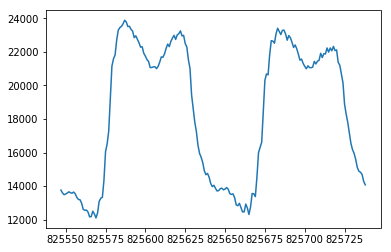

In [16]:
df[df.ForecastId == 4400].Value.plot()

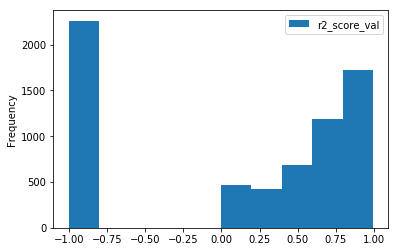

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df_cb_ar = pd.read_csv('../src/forest_stats_cb_cb_baseline_ar_value.csv')
stat_df_cb_ar.loc[stat_df_cb_ar.r2_score_val<0,'r2_score_val'] = -1

stat_df_cb_ar[['r2_score_val']].plot(kind='hist')
plt.show()

In [ ]:
import numpy as np

stat_df_cb_ar[['rmse_val']].apply(lambda x: np.log10(x+1)).plot(kind='hist', alpha = 0.5)
plt.show()

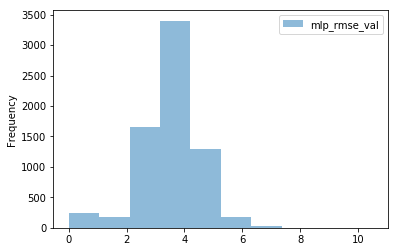

In [73]:
stat_df_mlp[['mlp_rmse_val']].apply(lambda x: np.log10(x+1)).plot(kind='hist', alpha = 0.5)
plt.show()

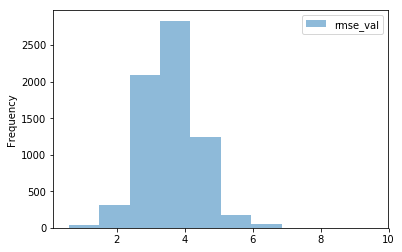

In [70]:
import numpy as np

stat_df_cb_ar[['rmse_val']].apply(lambda x: np.log10(x+1)).plot(kind='hist', alpha = 0.5)
plt.show()

In [4]:
stat_df.columns

Index(['Unnamed: 0', 'cb_r2_score_train', 'cb_r2_score_val', 'cb_rmse_train',
       'cb_rmse_val', 'cb_scores', 'cb_w_r2_score_train', 'cb_w_r2_score_val',
       'cb_w_rmse_train', 'cb_w_rmse_val', 'cb_w_scores', 'forecast_id',
       'lgb_r2_score_train', 'lgb_r2_score_val', 'lgb_rmse_train',
       'lgb_rmse_val', 'lgb_scores', 'lgb_w_r2_score_train',
       'lgb_w_r2_score_val', 'lgb_w_rmse_train', 'lgb_w_rmse_val',
       'lgb_w_scores', 'lmlp_r2_score_train', 'lmlp_w_r2_score_train',
       'mlp_r2_score_train', 'mlp_r2_score_val', 'mlp_rmse_train',
       'mlp_rmse_val', 'mlp_w_r2_score_train', 'mlp_w_r2_score_val',
       'mlp_w_rmse_train', 'mlp_w_rmse_val', 'time_taken'],
      dtype='object')

In [28]:
stat_df.shape

(1000, 34)

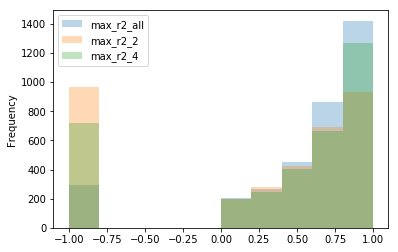

In [34]:
cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']

stat_df['max_r2_all'] = stat_df[cols].max(axis=1)
stat_df.loc[stat_df.max_r2_all<0,'max_r2'] = -1

stat_df['max_r2_2'] = stat_df[cols[0:2]].max(axis=1)
stat_df.loc[stat_df.max_r2_2<0,'max_r2'] = -1

stat_df['max_r2_4'] = stat_df[cols[0:4]].max(axis=1)
stat_df.loc[stat_df.max_r2_4<0,'max_r2'] = -1

stat_df[['max_r2_all','max_r2_2','max_r2_4']].plot(kind='hist',alpha=0.3)
plt.show()

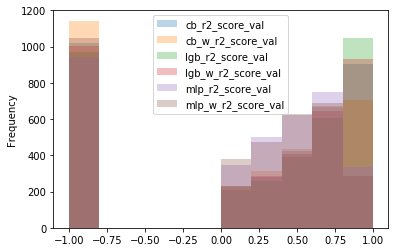

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df = pd.read_csv('../src/forest_stats_cb_cb_lgb_cbw_lgbw_mlp.csv')

cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']
for col in cols:
    stat_df.loc[stat_df[col]<0,col] = -1   

stat_df[['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']].plot(kind='hist',alpha=0.3)
plt.show()

In [21]:
stat_df[stat_df.cb_r2_score_val == -1][['max_r2','cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']]

max_r2  cb_r2_score_val  cb_w_r2_score_val  lgb_r2_score_val  \
0   -1.000000             -1.0          -1.000000         -1.000000   
2    0.022732             -1.0           0.022732         -1.000000   
3    0.060961             -1.0          -1.000000         -1.000000   
4    0.805652             -1.0          -1.000000         -1.000000   
19   0.905521             -1.0          -1.000000         -1.000000   
35   0.822171             -1.0          -1.000000         -1.000000   
41  -1.000000             -1.0          -1.000000         -1.000000   
42  -1.000000             -1.0          -1.000000         -1.000000   
43   0.792408             -1.0          -1.000000         -1.000000   
45  -1.000000             -1.0          -1.000000         -1.000000   
47   0.746672             -1.0          -1.000000          0.397557   
49  -1.000000             -1.0          -1.000000         -1.000000   
54   0.913681             -1.0          -1.000000         -1.000000   
61   0.817099             -1.0          -1.000000          0.437968   
65   0.893524             -1.0          -1.000000         -1.000000   
68   0.904509             -1.0          -1.000000         -1.000000   
71   0.090025             -1.0          -1.000000         -1.000000   
72  -1.000000             -1.0          -1.000000         -1.000000   
79   0.941910             -1.0          -1.000000         -1.000000   
83   0.925284             -1.0          -1.000000         -1.000000   
86   0.756310             -1.0          -1.000000          0.663857   
90   0.661711             -1.0          -1.000000          0.345798   
93   0.873329             -1.0          -1.000000          0.318016   
97   0.712747             -1.0          -1.000000          0.544739   
104  0.943031             -1.0          -1.000000         -1.000000   
105  0.801096             -1.0           0.785980          0.378176   
108  0.811462             -1.0          -1.000000         -1.000000   
110  0.550918             -1.0           0.132215         -1.000000   
111  0.370086             -1.0          -1.000000         -1.000000   
115  0.911544             -1.0          -1.000000         -1.000000   
..        ...              ...                ...               ...   
416 -1.000000             -1.0          -1.000000         -1.000000   
418 -1.000000             -1.0          -1.000000         -1.000000   
422  0.116338             -1.0          -1.000000          0.037663   
424  0.207614             -1.0          -1.000000          0.207614   
425 -1.000000             -1.0          -1.000000         -1.000000   
426  0.348397             -1.0          -1.000000         -1.000000   
427  0.045642             -1.0          -1.000000         -1.000000   
428  0.143639             -1.0          -1.000000         -1.000000   
429 -1.000000             -1.0          -1.000000         -1.000000   
430 -1.000000             -1.0          -1.000000         -1.000000   
431 -1.000000             -1.0          -1.000000         -1.000000   
432  0.155496             -1.0          -1.000000         -1.000000   
433 -1.000000             -1.0          -1.000000         -1.000000   
442  0.545747             -1.0          -1.000000         -1.000000   
444  0.751376             -1.0          -1.000000         -1.000000   
446  0.334150             -1.0          -1.000000         -1.000000   
450  0.493661             -1.0          -1.000000         -1.000000   
454  0.718360             -1.0          -1.000000         -1.000000   
457 -1.000000             -1.0          -1.000000         -1.000000   
463  0.036076             -1.0          -1.000000         -1.000000   
467  0.610744             -1.0          -1.000000         -1.000000   
468  0.079923             -1.0          -1.000000         -1.000000   
469  0.642805             -1.0          -1.000000         -1.000000   
476  0.654179             -1.0          -1.000000         -1.000000   
480  0.646689             -1.0 

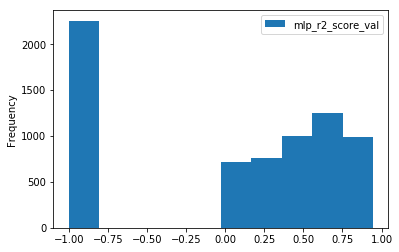

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df = pd.read_csv('../src/forest_stats_cb_windowed_mlp_baseline.csv')
stat_df.loc[stat_df.cb_r2_score_val<0,'mlp_r2_score_val'] = -1

stat_df[['mlp_r2_score_val']].plot(kind='hist')
plt.show()

In [46]:
1e9

1000000000.0

In [44]:
stat_df.cb_rmse_train.mean()

6802028.558740594

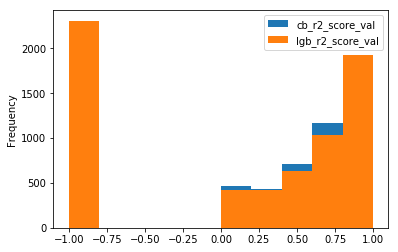

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df = pd.read_csv('../src/forest_stats_cb_cb_lgb_adaptive_adaptive_time_wo_ar.csv')
stat_df.loc[stat_df.cb_r2_score_val<0,'cb_r2_score_val'] = -1
stat_df.loc[stat_df.lgb_r2_score_val<0,'lgb_r2_score_val'] = -1

stat_df[['cb_r2_score_val','lgb_r2_score_val']].plot(kind='hist')
plt.show()

In [51]:
stat_df['cb_ar_r2_score_val'] = stat_df_cb_ar['r2_score_val']

In [22]:
stat_df['mlp_r2_score_val'] = stat_df_mlp['mlp_r2_score_val']

In [56]:
stat_df['negative_cb'] = 'pos'
stat_df.loc[stat_df.cb_r2_score_val<0,'negative_cb'] = 'neg'

stat_df['negative_lgb'] = 'pos'
stat_df.loc[stat_df.lgb_r2_score_val<0,'negative_lgb'] = 'neg'

stat_df['negative_mlp'] = 'pos'
stat_df.loc[stat_df.mlp_r2_score_val<0,'negative_mlp'] = 'neg'

stat_df['negative_cb_ar'] = 'pos'
stat_df.loc[stat_df.cb_ar_r2_score_val<0,'negative_cb_ar'] = 'neg'


In [75]:
import numpy as np
pt = pd.pivot_table(stat_df[stat_df['negative_lgb']=='pos'],
               index=['forecast_id_type','negative_cb','negative_lgb','negative_mlp','negative_cb_ar'],
               values=['cb_r2_score_val','lgb_r2_score_val','mlp_r2_score_val','cb_ar_r2_score_val'],
               aggfunc=[np.mean,len],
               fill_value=0)

pt[(pt[('mean','cb_r2_score_val')]==-1)&
   (pt[('mean','mlp_r2_score_val')]==-1)&
   (pt[('mean','cb_ar_r2_score_val')]==-1)]

mean  \
                                                                      cb_ar_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                      
15_mins          neg         pos          neg          neg                          -1.0   
1_day            neg         pos          neg          neg                          -1.0   
1_hour           neg         pos          neg          neg                          -1.0   

                                                                                       \
                                                                      cb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                   
15_mins          neg         pos          neg          neg                       -1.0   
1_day            neg         pos          neg          neg                       -1.0   
1_hour           neg         pos          neg          neg                       -1.0   

                                                                                        \
                                                                      lgb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                    
15_mins          neg         pos          neg          neg                    0.293237   
1_day            neg         pos          neg          neg                    0.136497   
1_hour           neg         pos          neg          neg                    0.195353   

                                                                                        \
                                                                      mlp_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                    
15_mins          neg         pos          neg          neg                        -1.0   
1_day            neg         pos          neg          neg                        -1.0   
1_hour           neg         pos          neg          neg                        -1.0   

                                                                                     len  \
                                                                      cb_ar_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                      
15_mins          neg         pos          neg          neg                            90   
1_day            neg         pos          neg          neg                             5   
1_hour           neg         pos          neg          neg                            11   

                                                                                       \
                                                                      cb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                   
15_mins          neg         pos          neg          neg                         90   
1_day            neg         pos          neg          neg                          5   
1_hour           neg         pos          neg          neg                         11   

                                                                                        \
                                                                      lgb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                    
15_mins          neg         pos          neg          neg                          90   
1_day            neg         pos          neg          neg                           5   
1_hour           neg         pos          neg          neg                          11   

                                                                                        
                                                                      mlp_r2_score_val  
forecast_id_type negative_cb negative_lgb negative_mlp negative_cb_ar                   
15_mins          n

In [15]:
stat_df['max_r2'] = stat_df[["cb_r2_score_val", "lgb_r2_score_val"]].max(axis=1)

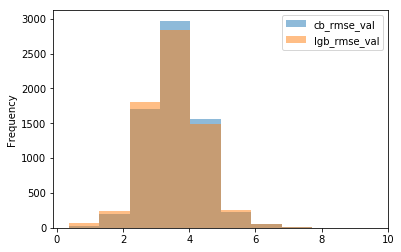

In [69]:
import numpy as np

stat_df[['cb_rmse_val','lgb_rmse_val']].apply(lambda x: np.log10(x+1)).plot(kind='hist', alpha = 0.5)
plt.show()

In [19]:
len(bad_forecast_ids),len(mediocre_forecast_ids),len(good_forecast_ids)

(1922, 2195, 2594)

In [17]:
bad_forecast_ids = list(stat_df[stat_df.max_r2<0].forecast_id.values)
mediocre_forecast_ids =  list(stat_df[(stat_df.max_r2>0)&(stat_df.max_r2<0.75)].forecast_id.values)
good_forecast_ids =  list(stat_df[(stat_df.max_r2>0.75)].forecast_id.values)

In [26]:
import pandas as pd

def parse_date(df,
               date_col,
               new_col,
               year_col=None,
               month_col=None,
               day_col=None,
               hour_col=None,
               minute_col=None,
               second_col=None,
               dow=None):
    df[new_col] = pd.to_datetime(df[date_col])
    if year_col is not None:
        df[year_col] = df[new_col].dt.year
    if month_col is not None:
        df[month_col] = df[new_col].dt.month        
    if day_col is not None:
        df[day_col] = df[new_col].dt.day
    if hour_col is not None:
        df[hour_col] = df[new_col].dt.hour
    if minute_col is not None:
        df[minute_col] = df[new_col].dt.minute        
    if second_col is not None:    
        df[second_col] = df[new_col].dt.second
    if dow is not None:    
        df[dow] = df[new_col].dt.dayofweek           
    return df

df = (pd.read_csv('../data/forecast/submission_format.csv')
    .pipe(parse_date,'Timestamp','ts','year','month','day','hour','minute','second')
    )

# understand which forecast_is has which time periodicity
f_ids = list(df.ForecastId.unique())
f_id_dict = {}

for forecast_id in f_ids:
    if len(df[df.ForecastId == forecast_id].hour.unique()) == 1:
        f_id_dict[forecast_id] = '1_day'
    elif len(df[df.ForecastId == forecast_id].minute.unique()) == 4:
        f_id_dict[forecast_id] = '15_mins'
    else:
        f_id_dict[forecast_id] = '1_hour'

In [27]:
stat_df['forecast_id_type'] = stat_df['forecast_id'].apply(lambda x: f_id_dict[x])

In [ ]:
stat_df['bad_forecast_ids'] = 0
stat_df[''] = 0
stat_df[''] = 0

In [31]:
stat_df['bad'] = stat_df['forecast_id'].isin(bad_forecast_ids)
stat_df['mediocre'] = stat_df['forecast_id'].isin(mediocre_forecast_ids)
stat_df['good'] = stat_df['forecast_id'].isin(good_forecast_ids)

In [36]:
stat_df['forecast_quality'] = 'na'

stat_df.loc[stat_df['forecast_id'].isin(bad_forecast_ids), 'forecast_quality'] = 'bad'
stat_df.loc[stat_df['forecast_id'].isin(mediocre_forecast_ids), 'forecast_quality'] = 'mediocre'
stat_df.loc[stat_df['forecast_id'].isin(good_forecast_ids), 'forecast_quality'] = 'good'

In [32]:
stat_df

Unnamed: 0  cb_r2_score_train  cb_r2_score_val  cb_rmse_train  \
0              0           0.466646        -1.000000   1.916346e+06   
1              0           0.330108        -1.000000   1.915246e+06   
2              0           0.266025         0.032961   2.564083e+06   
3              0           0.132842        -1.000000   2.638327e+06   
4              0           0.934485        -1.000000   2.065515e+04   
5              0           0.953316         0.955114   1.703039e+04   
6              0           0.905448         0.957905   2.375213e+04   
7              0           0.891968         0.965314   2.667400e+04   
8              0           0.966651         0.910739   1.399880e+04   
9              0           0.967085         0.735214   1.381922e+04   
10             0           0.902048         0.856292   2.252404e+04   
11             0           0.510683         0.560505   4.487801e+04   
12             0           0.912787         0.942790   2.400600e+04   
13             0           0.938630         0.928097   1.821372e+04   
14             0           0.842897         0.954236   2.818651e+04   
15             0           0.965109         0.697310   1.273203e+04   
16             0           0.959655         0.940499   1.196178e+04   
17             0           0.927033         0.838170   1.467796e+04   
18             0           0.899255         0.749206   1.530666e+04   
19             0           0.826851        -1.000000   1.203141e+04   
20             0           0.952774         0.965589   6.802258e+03   
21             0           0.881174         0.673853   9.164528e+03   
22             0           0.869846         0.850752   1.008835e+04   
23             0           0.931119         0.917641   7.177295e+03   
24             0           0.925577         0.904136   6.756981e+03   
25             0           0.885442         0.936618   8.199365e+03   
26             0           0.718608         0.476351   1.362964e+04   
27             0           0.897836         0.939372   8.326637e+03   
28             0           0.880600         0.921460   7.372414e+03   
29             0           0.885802         0.904078   7.334439e+03   
...          ...                ...              ...            ...   
6715           0           0.923054         0.613594   2.626547e+03   
6716           0           0.918961         0.688877   2.748175e+03   
6717           0           0.885384        -1.000000   3.465702e+03   
6718           0           0.940026         0.813483   2.229288e+03   
6719           0           0.946777         0.862930   2.225506e+03   
6720           0           0.900215         0.815705   3.125226e+03   
6721           0           0.914830        -1.000000   2.361173e+03   
6722           0           0.927494         0.760584   2.820835e+03   
6723           0           0.928873         0.766572   2.782845e+03   
6724           0           0.933264        -1.000000   2.380678e+03   
6725           0           0.906836         0.820814   2.954552e+03   
6726           0           0.910019         0.799556   3.403527e+03   
6727           0           0.841388         0.007282   4.045018e+03   
6728           0           0.923832        -1.000000   2.688878e+03   
6729           0           0.836023         0.214765   3.202807e+03   
6730           0           0.791236        -1.000000   3.515344e+03   
6731           0           0.890978         0.273550   3.059408e+03   
6732           0          -2.234433        -1.000000   5.359331e+05   
6733           0         -75.749739        -1.000000   1.352004e+06   
6734           0          -8.326250        -1.000000   5.547759e+05   
6735           0         -29.574574        -1.000000   1.009041e+06   
6736           0          -2.216741        -1.000000   6.396091e+05   
6737           0         -49.190633        -1.000000   1.025203e+06   
6738           0          -2.190162        -1.000000   6.395272e+05   
6739           0          -1.1

In [38]:
import matplotlib.pyplot as plt

pt = pd.pivot_table(stat_df,
               index=["forecast_id_type"],
               columns=['forecast_quality'],
               values=["max_r2"],
               aggfunc={"max_r2":[np.mean,len]},
               fill_value=0)

pt

max_r2                                               
                    len                    mean                       
forecast_quality    bad  good mediocre  na  bad      good  mediocre na
forecast_id_type                                                      
15_mins            1580  1963     1662  28   -1  0.881996  0.451091  0
1_day               108    21       85   2   -1  0.847849  0.335133  0
1_hour              234   610      448   4   -1  0.887115  0.433353  0

# Analyze monster model

## Analyze basic model

In [18]:
import pandas as pd
test_df = pd.read_csv('../src/forest_stats_super_monster_10_reverse_wo_mlp.csv')


In [19]:
cols = ['cb_rmse_val',
'cb_w_rmse_val',
'lgb_rmse_val',
'lgb_w_rmse_val',
's_gbr_rmse_val',
's_rfr_rmse_val',
's_gbr_w_rmse_val',
's_rfr_w_rmse_val']

In [24]:
cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','s_gbr_r2_score_val','s_rfr_r2_score_val','s_rfr_w_r2_score_val','s_rfr_w_r2_score_val']

In [22]:
test_df.columns

Index(['Unnamed: 0', 'cb_r2_score_train', 'cb_r2_score_val', 'cb_rmse_train',
       'cb_rmse_val', 'cb_scores', 'cb_w_r2_score_train', 'cb_w_r2_score_val',
       'cb_w_rmse_train', 'cb_w_rmse_val', 'cb_w_scores', 'forecast_id',
       'lgb_r2_score_train', 'lgb_r2_score_val', 'lgb_rmse_train',
       'lgb_rmse_val', 'lgb_scores', 'lgb_w_r2_score_train',
       'lgb_w_r2_score_val', 'lgb_w_rmse_train', 'lgb_w_rmse_val',
       'lgb_w_scores', 'model_chosen', 's_gbr_r2_score_train',
       's_gbr_r2_score_val', 's_gbr_rmse_train', 's_gbr_rmse_val',
       's_gbr_scores', 's_gbr_w_r2_score_train', 's_gbr_w_r2_score_val',
       's_gbr_w_rmse_train', 's_gbr_w_rmse_val', 's_gbr_w_scores',
       's_rfr_r2_score_train', 's_rfr_r2_score_val', 's_rfr_rmse_train',
       's_rfr_rmse_val', 's_rfr_scores', 's_rfr_w_r2_score_train',
       's_rfr_w_r2_score_val', 's_rfr_w_rmse_train', 's_rfr_w_rmse_val',
       's_rfr_w_scores', 'time_taken'],
      dtype='object')

In [25]:
test_df[cols]

cb_r2_score_val  cb_w_r2_score_val  lgb_r2_score_val  lgb_w_r2_score_val  \
0         0.876661           0.877293          0.830126            0.850517   

   s_gbr_r2_score_val  s_rfr_r2_score_val  s_rfr_w_r2_score_val  \
0            0.860644            0.881512              0.851628   

   s_rfr_w_r2_score_val  
0              0.851628

In [21]:
test_df['model_chosen']

0    s_rfr
Name: model_chosen, dtype: object

In [21]:
test_df_1 = pd.read_csv('../submissions/forecast_cb_lgb_cbw_lgbw_mlp_average_or_last.csv')
test_df_2 = pd.read_csv('../submissions/forecast_cb_lgb_cbw_lgbw_mlp_last_if_bad.csv')
test_df_3 = pd.read_csv('../submissions/forecast_cb_lgb_cbw_lgbw_mlp_always_best_model.csv')

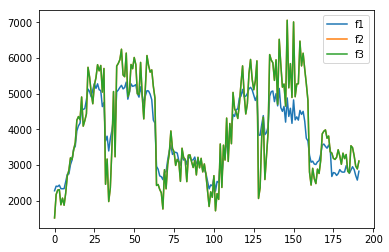

In [45]:
idx = 5300

temp_df = pd.DataFrame()
temp_df['f1'] = test_df_1[test_df.ForecastId == idx].Value.values
temp_df['f2'] = test_df_2[test_df.ForecastId == idx].Value.values
temp_df['f3'] = test_df_3[test_df.ForecastId == idx].Value.values

temp_df[['f1','f2','f3']].plot()

In [1]:
!ls -laht ../src/forest_stats_cb_cb_lgb_cbw_lgbw_mlp.csv

-rw-r--r-- 1 root root 5.5M Mar  9 11:49 ../src/forest_stats_cb_cb_lgb_cbw_lgbw_mlp.csv


In [22]:
stat_df.columns

Index(['Unnamed: 0', 'cb_r2_score_train', 'cb_r2_score_val', 'cb_rmse_train',
       'cb_rmse_val', 'cb_scores', 'cb_w_r2_score_train', 'cb_w_r2_score_val',
       'cb_w_rmse_train', 'cb_w_rmse_val', 'cb_w_scores', 'forecast_id',
       'lgb_r2_score_train', 'lgb_r2_score_val', 'lgb_rmse_train',
       'lgb_rmse_val', 'lgb_scores', 'lgb_w_r2_score_train',
       'lgb_w_r2_score_val', 'lgb_w_rmse_train', 'lgb_w_rmse_val',
       'lgb_w_scores', 'lmlp_r2_score_train', 'lmlp_w_r2_score_train',
       'mlp_r2_score_train', 'mlp_r2_score_val', 'mlp_rmse_train',
       'mlp_rmse_val', 'mlp_w_r2_score_train', 'mlp_w_r2_score_val',
       'mlp_w_rmse_train', 'mlp_w_rmse_val', 'time_taken', 'max_r2_all',
       'max_r2', 'max_r2_2', 'max_r2_4', 'forecast_id_type', 'negative_cb',
       'negative_lgb', 'negative_cb_w', 'negative_lgb_w', 'negative_mlp',
       'negative_cb_ar', 'negative_mlp_w'],
      dtype='object')

In [20]:
stat_df[stat_df.cb_r2_score_val>0.95].forecast_id

5          6
6          7
7          8
14        15
20        21
55        56
60        61
76        77
78        79
89        90
96        97
98        99
107      108
114      115
121      122
124      125
125      126
150      151
153      154
174      175
181      182
182      183
206      207
235      236
308      309
546      547
621      622
761      762
765      766
772      773
        ... 
6023    6024
6034    6035
6094    6095
6123    6124
6130    6131
6132    6133
6137    6138
6144    6145
6147    6148
6179    6180
6189    6190
6197    6198
6218    6219
6219    6220
6220    6221
6226    6227
6228    6229
6229    6230
6231    6232
6233    6234
6235    6236
6239    6240
6244    6245
6248    6249
6477    6478
6483    6484
6500    6501
6506    6507
6697    6698
6705    6706
Name: forecast_id, Length: 217, dtype: int64

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df = pd.read_csv('../src/forest_stats_super_monster_10_reverse_wo_mlp.csv')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df = pd.read_csv('../src/forest_stats_8_models_wrmse_train_val.csv')

In [5]:
!ls -laht ../src/forest_stats_super_monster_10_reverse_wo_mlp.csv

-rw-r--r-- 1 root root 9.6M Mar 11 14:28 ../src/forest_stats_super_monster_10_reverse_wo_mlp.csv


In [2]:
stat_df.columns

Index(['Unnamed: 0', 'cb_r2_score_train', 'cb_r2_score_val', 'cb_rmse_train',
       'cb_rmse_val', 'cb_scores', 'cb_w_r2_score_train', 'cb_w_r2_score_val',
       'cb_w_rmse_train', 'cb_w_rmse_val', 'cb_w_scores', 'forecast_id',
       'lgb_r2_score_train', 'lgb_r2_score_val', 'lgb_rmse_train',
       'lgb_rmse_val', 'lgb_scores', 'lgb_w_r2_score_train',
       'lgb_w_r2_score_val', 'lgb_w_rmse_train', 'lgb_w_rmse_val',
       'lgb_w_scores', 'model_chosen', 's_gbr_r2_score_train',
       's_gbr_r2_score_val', 's_gbr_rmse_train', 's_gbr_rmse_val',
       's_gbr_scores', 's_gbr_w_r2_score_train', 's_gbr_w_r2_score_val',
       's_gbr_w_rmse_train', 's_gbr_w_rmse_val', 's_gbr_w_scores',
       's_rfr_r2_score_train', 's_rfr_r2_score_val', 's_rfr_rmse_train',
       's_rfr_rmse_val', 's_rfr_scores', 's_rfr_w_r2_score_train',
       's_rfr_w_r2_score_val', 's_rfr_w_rmse_train', 's_rfr_w_rmse_val',
       's_rfr_w_scores', 'time_taken'],
      dtype='object')

In [27]:
import numpy as np



array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [37]:
stat_df.max_r2_all.min()

-5.014239660701329e+36

In [56]:
stat_df[stat_df.max_r2 < 0].max_r2.value_counts()

-1.0    2367
Name: max_r2, dtype: int64

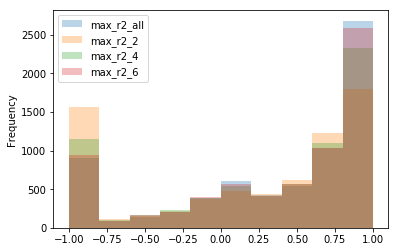

In [3]:
cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','s_gbr_r2_score_val','s_gbr_w_r2_score_val','s_rfr_r2_score_val','s_rfr_w_r2_score_val']

stat_df['max_r2_all'] = stat_df[cols].max(axis=1)
stat_df.loc[stat_df.max_r2_all<0,'max_r2'] = -1

stat_df['max_r2_2'] = stat_df[cols[0:2]].max(axis=1)
stat_df.loc[stat_df.max_r2_2<0,'max_r2'] = -1

stat_df['max_r2_4'] = stat_df[cols[0:4]].max(axis=1)
stat_df.loc[stat_df.max_r2_4<0,'max_r2'] = -1

stat_df['max_r2_6'] = stat_df[cols[0:6]].max(axis=1)
stat_df.loc[stat_df.max_r2_6<0,'max_r2'] = -1

stat_df[['max_r2_all','max_r2_2','max_r2_4','max_r2_6']].clip(-1,1).plot(kind='hist',alpha=0.3)
plt.show()

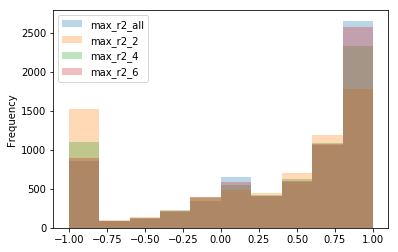

In [58]:
cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','s_gbr_r2_score_val','s_gbr_w_r2_score_val','s_rfr_r2_score_val','s_rfr_w_r2_score_val']

stat_df['max_r2_all'] = stat_df[cols].max(axis=1)
stat_df.loc[stat_df.max_r2_all<0,'max_r2'] = -1

stat_df['max_r2_2'] = stat_df[cols[0:2]].max(axis=1)
stat_df.loc[stat_df.max_r2_2<0,'max_r2'] = -1

stat_df['max_r2_4'] = stat_df[cols[0:4]].max(axis=1)
stat_df.loc[stat_df.max_r2_4<0,'max_r2'] = -1

stat_df['max_r2_6'] = stat_df[cols[0:6]].max(axis=1)
stat_df.loc[stat_df.max_r2_6<0,'max_r2'] = -1

stat_df[['max_r2_all','max_r2_2','max_r2_4','max_r2_6']].clip(-1,1).plot(kind='hist',alpha=0.3)
plt.show()

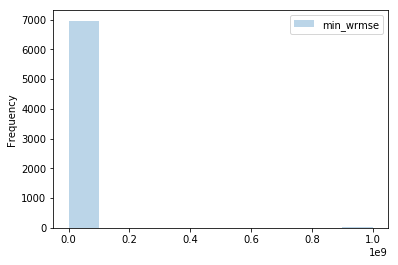

In [9]:
cols = ['cb_rmse_val','cb_w_rmse_val','lgb_rmse_val','lgb_w_rmse_val','s_gbr_rmse_val','s_rfr_rmse_val','s_gbr_w_rmse_val','s_rfr_w_rmse_val']
stat_df['min_wrmse'] = stat_df[cols].min(axis=1)
stat_df[['min_wrmse']].plot(kind='hist',alpha=0.3)
plt.show()

In [16]:
stat_df[stat_df.min_wrmse > 100000][['min_wrmse']].shape

(12, 1)

In [17]:
stat_df[stat_df.min_wrmse < 1000][['min_wrmse']].describe()

min_wrmse
count  6960.000000
mean      0.676880
std      12.086350
min       0.000000
25%       0.087150
50%       0.156274
75%       0.310045
max     814.093938

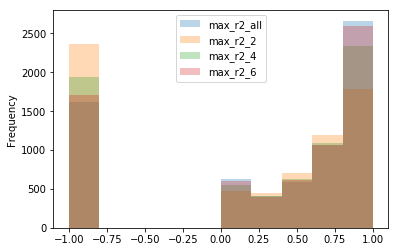

In [13]:
cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','s_gbr_r2_score_val','s_gbr_w_r2_score_val','s_rfr_r2_score_val','s_rfr_w_r2_score_val']

stat_df['max_r2_all'] = stat_df[cols].max(axis=1)
stat_df.loc[stat_df.max_r2_all<0,'max_r2'] = -1

stat_df['max_r2_2'] = stat_df[cols[0:2]].max(axis=1)
stat_df.loc[stat_df.max_r2_2<0,'max_r2'] = -1

stat_df['max_r2_4'] = stat_df[cols[0:4]].max(axis=1)
stat_df.loc[stat_df.max_r2_4<0,'max_r2'] = -1

stat_df['max_r2_6'] = stat_df[cols[0:6]].max(axis=1)
stat_df.loc[stat_df.max_r2_6<0,'max_r2'] = -1

stat_df[['max_r2_all','max_r2_2','max_r2_4','max_r2_6']].plot(kind='hist',alpha=0.3)
plt.show()

In [4]:
bad_forecast_ids = list(stat_df[stat_df.max_r2_all<0].forecast_id.values)
mediocre_forecast_ids =  list(stat_df[(stat_df.max_r2_all>0)&(stat_df.max_r2_all<0.75)].forecast_id.values)
good_forecast_ids =  list(stat_df[(stat_df.max_r2_all>0.75)].forecast_id.values)

In [6]:
predict_df = pd.read_csv('../submissions/forecast_8_models_wrmse_train_val_always_best_model.csv')
predict_df.head()

obs_id  SiteId            Timestamp  ForecastId         Value
0  1677832       1  2015-08-29 00:00:00           1  5.506235e+06
1  5379616       1  2015-08-30 00:00:00           1  6.446143e+06
2   496261       1  2015-08-31 00:00:00           1  7.576940e+06
3  4567147       1  2015-09-01 00:00:00           1  7.716872e+06
4  3684873       1  2015-09-02 00:00:00           1  7.682897e+06

In [7]:
len(bad_forecast_ids),len(mediocre_forecast_ids),len(good_forecast_ids)

(1704, 2073, 3053)

In [8]:
train_df = pd.read_csv('../data/forecast/train.csv')

In [49]:
train_df.head()

obs_id  SiteId            Timestamp  ForecastId         Value
0   744519       1  2014-09-03 00:00:00           1  9.096555e+05
1  7627564       1  2014-09-04 00:00:00           1  1.748273e+06
2  7034705       1  2014-09-05 00:00:00           1           NaN
3  5995486       1  2014-09-06 00:00:00           1           NaN
4  7326510       1  2014-09-07 00:00:00           1           NaN

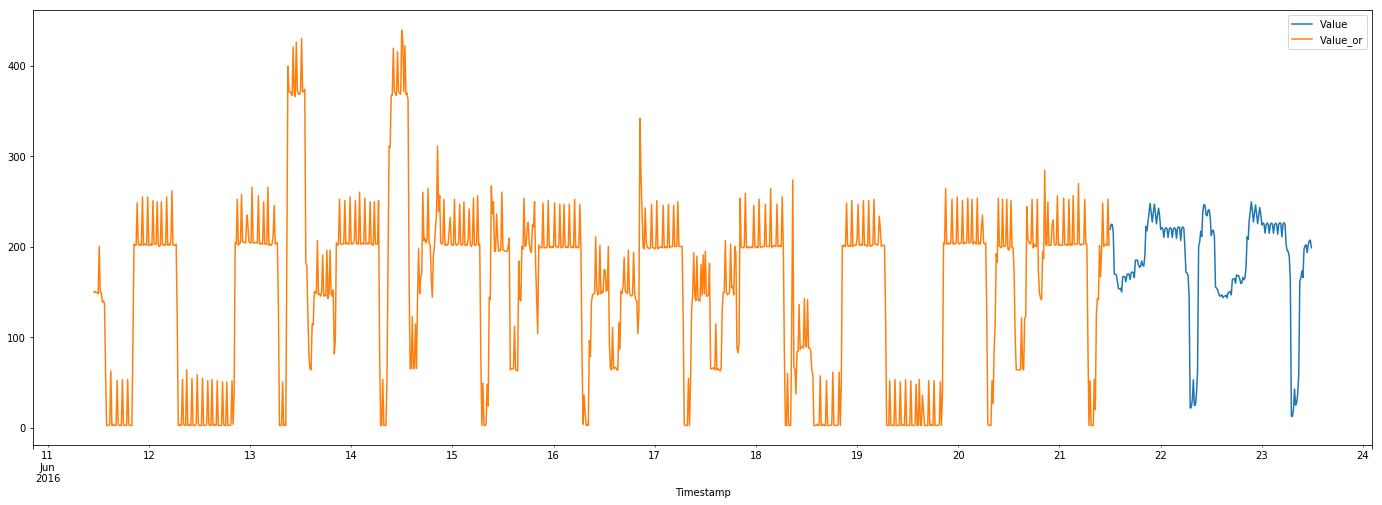

In [39]:
import random
idx = random.randint(0,len(bad_forecast_ids))
forecast_id = bad_forecast_ids[idx]

plot_df = train_df.iloc[:][train_df.ForecastId==forecast_id].sort_values(by='Timestamp',ascending=True)[['Value','Timestamp']]
plot_df.columns = ['Value_or','Timestamp']

plot_df = plot_df.append(predict_df.iloc[:][predict_df.ForecastId==forecast_id].sort_values(by='Timestamp',ascending=True)[['Value','Timestamp']])

# predict_df.iloc[:][predict_df.ForecastId==forecast_id].sort_values(by='Timestamp',ascending=True)[['Value','Timestamp']].plot(x = 'Timestamp',figsize=(24, 8 * 1))
# train_df.iloc[:][train_df.ForecastId==forecast_id].sort_values(by='Timestamp',ascending=True)[['Value','Timestamp']].plot(x = 'Timestamp',figsize=(24, 8 * 1))

plot_df['Timestamp'] = pd.to_datetime(plot_df['Timestamp'])
plot_df[['Value','Value_or','Timestamp']].plot(x = 'Timestamp',figsize=(24, 8 * 1))

plt.show()

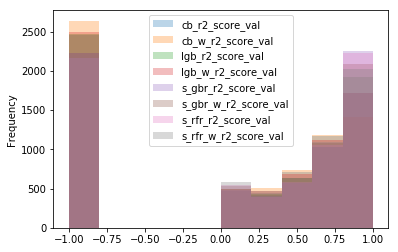

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df = pd.read_csv('../src/forest_stats_super_monster_10_wo_mlp.csv')

cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','s_gbr_r2_score_val','s_gbr_w_r2_score_val','s_rfr_r2_score_val','s_rfr_w_r2_score_val']
for col in cols:
    stat_df.loc[stat_df[col]<0,col] = -1   

stat_df[cols].plot(kind='hist',alpha=0.3)
plt.show()

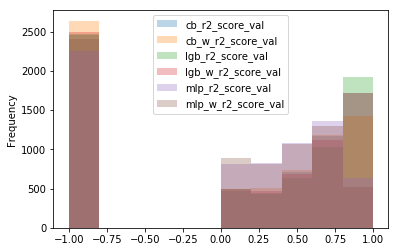

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

stat_df = pd.read_csv('../src/forest_stats_cb_cb_lgb_cbw_lgbw_mlp.csv')

cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']
for col in cols:
    stat_df.loc[stat_df[col]<0,col] = -1   

stat_df[['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']].plot(kind='hist',alpha=0.3)
plt.show()

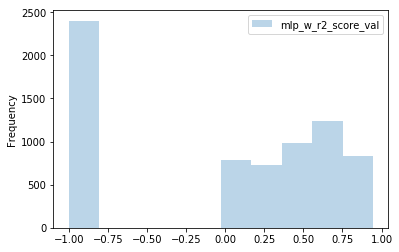

In [3]:
stat_df[['mlp_w_r2_score_val']].plot(kind='hist',alpha=0.3)
plt.show()

In [29]:
stat_df[stat_df['max_r2_all']>0.95].forecast_id

5          6
6          7
7          8
14        15
20        21
37        38
46        47
53        54
55        56
60        61
62        63
63        64
64        65
66        67
67        68
74        75
76        77
77        78
78        79
82        83
85        86
87        88
89        90
91        92
92        93
94        95
95        96
96        97
98        99
99       100
        ... 
6244    6245
6248    6249
6249    6250
6250    6251
6251    6252
6312    6313
6322    6323
6340    6341
6376    6377
6377    6378
6379    6380
6388    6389
6400    6401
6401    6402
6405    6406
6418    6419
6455    6456
6477    6478
6483    6484
6500    6501
6506    6507
6539    6540
6578    6579
6697    6698
6704    6705
6705    6706
6706    6707
6708    6709
6714    6715
0        309
Name: forecast_id, Length: 495, dtype: int64

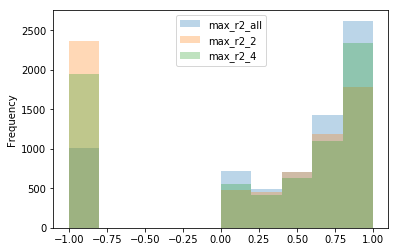

In [24]:
cols = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']

stat_df['max_r2_all'] = stat_df[cols].max(axis=1)
stat_df.loc[stat_df.max_r2_all<0,'max_r2'] = -1

stat_df['max_r2_2'] = stat_df[cols[0:2]].max(axis=1)
stat_df.loc[stat_df.max_r2_2<0,'max_r2'] = -1

stat_df['max_r2_4'] = stat_df[cols[0:4]].max(axis=1)
stat_df.loc[stat_df.max_r2_4<0,'max_r2'] = -1

stat_df[['max_r2_all','max_r2_2','max_r2_4']].plot(kind='hist',alpha=0.3)
plt.show()

In [7]:
import pandas as pd

def parse_date(df,
               date_col,
               new_col,
               year_col=None,
               month_col=None,
               day_col=None,
               hour_col=None,
               minute_col=None,
               second_col=None,
               dow=None):
    df[new_col] = pd.to_datetime(df[date_col])
    if year_col is not None:
        df[year_col] = df[new_col].dt.year
    if month_col is not None:
        df[month_col] = df[new_col].dt.month        
    if day_col is not None:
        df[day_col] = df[new_col].dt.day
    if hour_col is not None:
        df[hour_col] = df[new_col].dt.hour
    if minute_col is not None:
        df[minute_col] = df[new_col].dt.minute        
    if second_col is not None:    
        df[second_col] = df[new_col].dt.second
    if dow is not None:    
        df[dow] = df[new_col].dt.dayofweek           
    return df

df = (pd.read_csv('../data/forecast/submission_format.csv')
    .pipe(parse_date,'Timestamp','ts','year','month','day','hour','minute','second')
    )

# understand which forecast_is has which time periodicity
f_ids = list(df.ForecastId.unique())
f_id_dict = {}

for forecast_id in f_ids:
    if len(df[df.ForecastId == forecast_id].hour.unique()) == 1:
        f_id_dict[forecast_id] = '1_day'
    elif len(df[df.ForecastId == forecast_id].minute.unique()) == 4:
        f_id_dict[forecast_id] = '15_mins'
    else:
        f_id_dict[forecast_id] = '1_hour'

In [26]:
stat_df['forecast_id_type'] = stat_df['forecast_id'].apply(lambda x: f_id_dict[x])

In [47]:
stat_df[['mlp_rmse_val','']]

Index(['Unnamed: 0', 'cb_r2_score_train', 'cb_r2_score_val', 'cb_rmse_train',
       'cb_rmse_val', 'cb_scores', 'cb_w_r2_score_train', 'cb_w_r2_score_val',
       'cb_w_rmse_train', 'cb_w_rmse_val', 'cb_w_scores', 'forecast_id',
       'lgb_r2_score_train', 'lgb_r2_score_val', 'lgb_rmse_train',
       'lgb_rmse_val', 'lgb_scores', 'lgb_w_r2_score_train',
       'lgb_w_r2_score_val', 'lgb_w_rmse_train', 'lgb_w_rmse_val',
       'lgb_w_scores', 'lmlp_r2_score_train', 'lmlp_w_r2_score_train',
       'mlp_r2_score_train', 'mlp_r2_score_val', 'mlp_rmse_train',
       'mlp_rmse_val', 'mlp_w_r2_score_train', 'mlp_w_r2_score_val',
       'mlp_w_rmse_train', 'mlp_w_rmse_val', 'time_taken', 'max_r2_all',
       'max_r2', 'max_r2_2', 'max_r2_4'],
      dtype='object')

In [28]:
stat_df['negative_cb'] = 'pos'
stat_df.loc[stat_df.cb_r2_score_val<0,'negative_cb'] = 'neg'

stat_df['negative_lgb'] = 'pos'
stat_df.loc[stat_df.lgb_r2_score_val<0,'negative_lgb'] = 'neg'

stat_df['negative_cb_w'] = 'pos'
stat_df.loc[stat_df.cb_w_r2_score_val<0,'negative_cb_w'] = 'neg'

stat_df['negative_lgb_w'] = 'pos'
stat_df.loc[stat_df.lgb_w_r2_score_val<0,'negative_lgb_w'] = 'neg'

stat_df['negative_mlp'] = 'pos'
stat_df.loc[stat_df.mlp_r2_score_val<0,'negative_mlp'] = 'neg'

stat_df['negative_mlp_w'] = 'pos'
stat_df.loc[stat_df.mlp_w_r2_score_val<0,'negative_mlp_w'] = 'neg'


In [32]:
stat_df[stat_df['negative_mlp_w']=='pos'].shape

(3126, 44)

In [37]:
import numpy as np
pt = pd.pivot_table(stat_df[stat_df['negative_lgb_w']=='pos'],
               index=['forecast_id_type',
                      'negative_cb',
                      'negative_lgb',
                      'negative_cb_w','negative_lgb_w',
                      'negative_mlp',],
               values=['cb_r2_score_val','lgb_r2_score_val',
                       'cb_w_r2_score_val','lgb_w_r2_score_val',
                       'mlp_r2_score_val','negative_mlp_w'],
               aggfunc=[np.mean,len],
               fill_value=0)

pt[(pt[('mean','cb_r2_score_val')]==-1)&
   (pt[('mean','lgb_r2_score_val')]==-1)&
   (pt[('mean','cb_w_r2_score_val')]==-1)&
   # (pt[('mean','lgb_w_r2_score_val')]==-1)&
   (pt[('mean','mlp_r2_score_val')]==-1) 
  ]

mean  \
                                                                                    cb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                   
15_mins          neg         neg          neg           pos            neg                     -1.0   
1_hour           neg         neg          neg           pos            neg                     -1.0   

                                                                                                       \
                                                                                    cb_w_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                     
15_mins          neg         neg          neg           pos            neg                       -1.0   
1_hour           neg         neg          neg           pos            neg                       -1.0   

                                                                                                      \
                                                                                    lgb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                    
15_mins          neg         neg          neg           pos            neg                      -1.0   
1_hour           neg         neg          neg           pos            neg                      -1.0   

                                                                                                        \
                                                                                    lgb_w_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                      
15_mins          neg         neg          neg           pos            neg                    0.210906   
1_hour           neg         neg          neg           pos            neg                    0.165531   

                                                                                                      \
                                                                                    mlp_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                    
15_mins          neg         neg          neg           pos            neg                      -1.0   
1_hour           neg         neg          neg           pos            neg                      -1.0   

                                                                                                len  \
                                                                                    cb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                   
15_mins          neg         neg          neg           pos            neg                       22   
1_hour           neg         neg          neg           pos            neg                        3   

                                                                                                       \
                                                                                    cb_w_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                     
15_mins          neg         neg          neg           pos            neg                         22   
1_hour           neg         neg          neg           pos            neg                          3   

                                                                                                      \
                                                                                    lgb_r2_score_val   
forecast_id_type negative_cb negative_lgb negative_cb_w negative_lgb_w negative_mlp                    
15_mins          neg         neg          neg           pos            neg                        22   
1_hour           neg  

## Analyze weekly model

In [40]:
stat_df = pd.read_csv('../src/forest_stats_cb_8_models_train_site.csv')

In [48]:
import numpy as np

pt = pd.pivot_table(stat_df,
               index=['forecast_id'],
               columns = ['model'],
               values=['r2_val'],
               aggfunc=[np.mean],
               fill_value=0)

pt = pt.reset_index()
pt.columns = ['forecast_id','cb','cb_w','lgb','lgb_w','s_gbr','s_gbr_w','s_rfr','s_rfr_w']

In [49]:
pt

forecast_id         cb       cb_w        lgb      lgb_w      s_gbr  \
0               1  -2.138410  -2.073908  -1.770286  -1.770286  -4.969287   
1               2  -1.476036  -1.560152  -0.980195  -0.980195  -1.466472   
2               3  -1.348820  -1.415816  -1.319959  -1.319959  -0.748691   
3               4   0.096835   0.103643  -0.060980  -0.060980  -0.320363   
4               5   0.490680   0.493368   0.414394   0.412394   0.541597   
5               6   0.086190   0.084676   0.116100   0.128139   0.228568   
6               7   0.317344   0.303838   0.216301   0.218789   0.430344   
7               8   0.402147   0.392221   0.251282   0.183022   0.549064   
8               9   0.601177   0.604195   0.546784   0.563518   0.629789   
9              10   0.649546   0.648070   0.625756   0.636264   0.653856   
10             11   0.486757   0.514627   0.495423   0.502057   0.607561   
11             12   0.633581   0.640359   0.503738   0.479530   0.703819   
12             13   0.526644   0.539720   0.577987   0.569909   0.691726   
13             14   0.448343   0.470856   0.592981   0.576802   0.600770   
14             15   0.180645   0.211300   0.030313  -0.014856   0.153137   
15             16   0.547994   0.557124   0.499136   0.476955   0.650905   
16             17   0.751357   0.763728   0.782912   0.781421   0.802835   
17             18   0.497726   0.474238   0.517690   0.494151   0.601374   
18             19   0.794810   0.843954   0.858241   0.881476   0.887417   
19             20   0.316713   0.394261   0.515416   0.543543   0.298901   
20             21   0.620300   0.596575   0.472218   0.521383   0.015279   
21             22  -0.216194   0.037233   0.083808  -0.012806  -1.074547   
22             23   0.641965   0.655507   0.601202   0.554136  -0.477825   
23             24   0.762823   0.764606   0.625972   0.649365   0.206879   
24             25   0.473029   0.471728   0.192947   0.241525  -0.301482   
25             26   0.689585   0.704700   0.413375   0.456097   0.397101   
26             27  -2.545768  -2.545312  -2.346833  -2.258480  -3.084328   
27             28  -1.022724  -0.954450  -0.216086  -0.103556  -1.222871   
28             29  -0.202831  -0.308083  -0.727840  -0.735444  -1.309791   
29             30   0.223172   0.305714   0.307812   0.382445   0.044403   
...           ...        ...        ...        ...        ...        ...   
6316         6945  -0.426564  -0.443801  -0.007627  -0.124848  -0.503659   
6317         6946  -0.055871  -0.062277  -0.225213   0.004287  -0.097526   
6318         6947   0.209167   0.232076   0.311079   0.231529   0.243301   
6319         6948 -60.786193 -58.915113 -46.482571 -26.978079 -43.235431   
6320         6949  -0.230833  -0.218092  -0.193434  -0.259327  -0.288391   
6321         6950  -0.066920  -0.046925  -0.077738  -0.187005  -0.112220   
6322         6951   0.064792   0.041460   0.213648   0.205118  -0.013039   
6323         6952 -23.647634 -24.115922 -27.727021 -21.567235 -25.383510   
6324         6953   0.011310   0.080177  -0.126368   0.195417   0.123058   
6325         6954   0.230736   0.249437   0.286945   0.104442   0.154724   
6326         6955 -25.653101 -25.346482 -20.592059 -23.165860 -24.639277   
6327         6956   0.056781   0.025712   0.916229   0.870600   0.185546   
6328         6957  -0.012739   0.009019   0.164554   0.048566   0.031515   
6329         6958  -0.002104   0.012004   0.233810   0.277427  -0.010277   
6330         6959 -26.089745 -27.093245 -23.050196 -20.226824 -28.590331   
6331         6960  -0.195948  -0.187450  -0.118668  -0.120843  -0.160243   
6332         6961   0.207825   0.208444   0.536915   0.469850   0.237438   
6333         6962 -87.196142 -51.397032  -4.473631  -4.473631 -27.742075   
6334         6963 -37.091145 -29.733192  -1.540441  -1.564014  -3.582486   
6335         6964 -14.889405 -11.269543 -10.043335 -10.043335 -14.821431   
6336         6965  -0.276715  -0.233024  -0.155216  -0

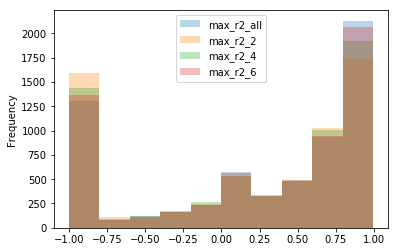

In [52]:
cols = ['cb','cb_w','lgb','lgb_w','s_gbr','s_gbr_w','s_rfr','s_rfr_w']

pt['max_r2_all'] = pt[cols].max(axis=1)
pt.loc[pt.max_r2_all<0,'max_r2'] = -1

pt['max_r2_2'] = pt[cols[0:2]].max(axis=1)
pt.loc[pt.max_r2_2<0,'max_r2'] = -1

pt['max_r2_4'] = pt[cols[0:4]].max(axis=1)
pt.loc[pt.max_r2_4<0,'max_r2'] = -1

pt['max_r2_6'] = pt[cols[0:6]].max(axis=1)
pt.loc[pt.max_r2_6<0,'max_r2'] = -1

pt[['max_r2_all','max_r2_2','max_r2_4','max_r2_6']].clip(-1,1).plot(kind='hist',alpha=0.3)
plt.show()

# Debug Monster model

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import  metrics
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

# custom utils and random forest scripts
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  slice_train_data_rf,slice_train_data_rf_weather,sk_fit_alg

# dummy variable list            
from holidayList import hol_list

# params for random forest baselines
from params import xgb_params,cbr_params,lgb_params,s_gbr_params,s_rfr_params

# windowed MLP baseline
from MLPPipeline import train,validate,predict_train,\
                        predict_test,slice_train_data_mlp,train_one_cnn,\
                        slice_train_data_mlp_weather

LOGNUMBER = 'super_monster_model'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

# use different set of time related features for each time span
target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))
print('SGBR params : {}'.format(s_gbr_params))
print('SRFR  params : {}'.format(s_rfr_params))

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

# store basic evaluation results
stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',
             'cb_w_rmse_train','cb_w_r2_score_train','cb_w_rmse_val','cb_w_r2_score_val','cb_w_scores',
             'lgb_w_rmse_train','lgb_w_r2_score_train','lgb_w_rmse_val','lgb_w_r2_score_val','lgb_w_scores',    
             
             's_gbr_rmse_train','s_gbr_r2_score_train','s_gbr_rmse_val','s_gbr_r2_score_val','s_gbr_scores',
             's_rfr_rmse_train','s_rfr_r2_score_train','s_rfr_rmse_val','s_rfr_r2_score_val','s_rfr_scores',
             's_gbr_w_rmse_train','s_gbr_w_r2_score_train','s_gbr_w_rmse_val','s_gbr_w_r2_score_val','s_gbr_w_scores',
             's_rfr_w_rmse_train','s_rfr_w_r2_score_train','s_rfr_w_rmse_val','s_rfr_w_r2_score_val','s_rfr_w_scores',

             'mlp_rmse_train','lmlp_r2_score_train','mlp_rmse_val','mlp_r2_score_val',  
             'mlp_w_rmse_train','lmlp_w_r2_score_train','mlp_w_rmse_val','mlp_w_r2_score_val',               
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

submission_df_2 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_2 = submission_df_2.set_index('obs_id')

submission_df_3 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_3 = submission_df_3.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 184.88128185272217
LGB params : {'random_state': 27, 'verbose': -1, 'objective': 'regression', 'boosting_type': 'gbdt', 'n_jobs': 10, 'learning_rate': 0.1, 'n_estimators': 700, 'num_leaves': 512}
CB  params : {'random_state': 27, 'loss_function': 'RMSE', 'verbose': False, 'thread_count': 10, 'learning_rate': 0.1, 'has_time': True, 'l2_leaf_reg': 500, 'approx_on_full_history': True, 'n_estimators': 700}


In [107]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        forecast_id = 1800
        try:
            #============ RF models ============#
            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)
            

            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf(df_train,
                                                                                                         df_sub,
                                                                                                         forecast_id,
                                                                                                         test_lengths)
            start_time = time.time()

            #============ Fit CatBoost ============#
            try:
                cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb'] = cbr.predict(temp_df[predictors])
                cb_preds = list(temp_df.loc[test_ind].preds_cb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost fitting failed due to error : {}'.format(print(str(e))))

                cb_rmse_train = 1e9
                cb_r2_score_train = -1
                cb_rmse_val = 1e9
                cb_r2_score_val = -1
                cb_scores = []
                cb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   

            #============ Fit LightGBM ============#                
            try:
                lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb'] = lgb.predict(temp_df[predictors])
                lgb_preds = list(temp_df.loc[test_ind].preds_lgb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM fitting failed due to error : {}'.format(print(str(e))))
                lgb_rmse_train = 1e9
                lgb_r2_score_train = -1
                lgb_rmse_val = 1e9
                lgb_r2_score_val = -1
                lgb_scores = []
                lgb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))  

            #============ Fit Sklearn Boosted Trees ============#
            try:
                s_gbr_rmse_train,s_gbr_r2_score_train,s_gbr_rmse_val,s_gbr_r2_score_val,s_gbr_scores,s_gbr = sk_fit_alg(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr'] = s_gbr.predict(temp_df[predictors])
                s_gbr_preds = list(temp_df.loc[test_ind].preds_s_gbr)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_rmse_train = 1e9
                s_gbr_r2_score_train = -1
                s_gbr_rmse_val = 1e9
                s_gbr_r2_score_val = -1
                s_gbr_scores = []
                s_gbr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                s_rfr_rmse_train,s_rfr_r2_score_train,s_rfr_rmse_val,s_rfr_r2_score_val,s_rfr_scores,s_rfr = sk_fit_alg(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)

                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr'] = s_rfr.predict(temp_df[predictors])
                s_rfr_preds = list(temp_df.loc[test_ind].preds_s_rfr)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_rmse_train = 1e9
                s_rfr_r2_score_train = -1
                s_rfr_rmse_val = 1e9
                s_rfr_r2_score_val = -1
                s_rfr_scores = []
                s_rfr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                   
                   
            #============ RF models + future weather ============#

            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)            

            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_weather(df_train,
                                                                                                                 df_sub,
                                                                                                                 forecast_id,
                                                                                                                 test_lengths)
            #============ Fit CatBoost + weather ============#
            try:
                cb_w_rmse_train,cb_w_r2_score_train,cb_w_rmse_val,cb_w_r2_score_val,cb_w_scores,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)

                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb_w'] = cbr.predict(temp_df[predictors])
                cb_w_preds = list(temp_df.loc[test_ind].preds_cb_w)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost with weather fitting failed due to error : {}'.format(print(str(e))))

                cb_w_rmse_train = 1e9
                cb_w_r2_score_train = -1
                cb_w_rmse_val = 1e9
                cb_w_r2_score_val = -1
                cb_w_scores = []
                cb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))

            #============ Fit LightGBM + weather ============#                
            try:
                lgb_w_rmse_train,lgb_w_r2_score_train,lgb_w_rmse_val,lgb_w_r2_score_val,lgb_w_scores,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb_w'] = lgb.predict(temp_df[predictors])
                lgb_w_preds = list(temp_df.loc[test_ind].preds_lgb_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM with weather fitting failed due to error : {}'.format(print(str(e))))
                lgb_w_rmse_train = 1e9
                lgb_w_r2_score_train = -1
                lgb_w_rmse_val = 1e9
                lgb_w_r2_score_val = -1
                lgb_w_scores = []
                lgb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))            

            #============ Fit Sklearn Boosted Trees ============#
            try:
                s_gbr_w_rmse_train,s_gbr_w_r2_score_train,s_gbr_w_rmse_val,s_gbr_w_r2_score_val,s_gbr_w_scores,s_gbr = sk_fit_alg(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr_w'] = s_gbr.predict(temp_df[predictors])
                s_gbr_w_preds = list(temp_df.loc[test_ind].preds_s_gbr_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_w_rmse_train = 1e9
                s_gbr_w_r2_score_train = -1
                s_gbr_w_rmse_val = 1e9
                s_gbr_w_r2_score_val = -1
                s_gbr_w_scores = []
                s_gbr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                s_rfr_w_rmse_train,s_rfr_w_r2_score_train,s_rfr_w_rmse_val,s_rfr_w_r2_score_val,s_rfr_w_scores,s_rfr = sk_fit_alg(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)

                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr_w'] = s_rfr.predict(temp_df[predictors])
                s_rfr_w_preds = list(temp_df.loc[test_ind].preds_s_rfr_w)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_w_rmse_train = 1e9
                s_rfr_w_r2_score_train = -1
                s_rfr_w_rmse_val = 1e9
                s_rfr_w_r2_score_val = -1
                s_rfr_w_scores = []
                s_rfr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                                   
                
                
            #============ Train Windowed MLP models ============#
            try:
                temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data_mlp(df_train,
                                                                                                      df_sub,
                                                                                                      forecast_id,
                                                                                                      test_lengths)

                dataset_len = len(train_ind) - 1 - len(train_ind) // 3

                model,train_preds_mlp,val_preds_mlp,test_preds_mlp,mlp_rmse_train,mlp_r2_score_train,mlp_rmse_val,mlp_r2_score_val = train_one_cnn(model = None,
                                                                                                                                                     lr=1e-3,
                                                                                                                                                     start_epoch=0,
                                                                                                                                                     epochs=30,
                                                                                                                                                     cnn_type='mlp',
                                                                                                                                                     hidden_layers=512,
                                                                                                                                                     temp_df = temp_df,
                                                                                                                                                     all_hols = all_hols,
                                                                                                                                                     train_ind = train_ind,
                                                                                                                                                     test_ind = test_ind,
                                                                                                                                                     prediction_freq = prediction_freq,
                                                                                                                                                     predictors = predictors
                                                                                                                                                     )
                temp_df['preds_mlp'] = 0
                temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'preds_mlp'] = train_preds_mlp
                temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'preds_mlp'] = val_preds_mlp
                temp_df.loc[test_ind, 'preds_mlp'] = test_preds_mlp[:,0,0]
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                mlp_preds = list(temp_df.loc[test_ind].preds_mlp)
            except Exception as e:
                # in case of exception - record poor scores
                print('MLP fitting failed due to error : {}'.format(print(str(e))))
                mlp_rmse_train = 1e9
                mlp_r2_score_train = -1
                mlp_rmse_val = 1e9
                mlp_r2_score_val = -1
                mlp_preds = [0] * len(list(temp_df.loc[test_ind].obs_id))    

            #============ Train Windowed MLP models + future weather ============#
            try:
                temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data_mlp_weather(df_train,
                                                                                                      df_sub,
                                                                                                      forecast_id,
                                                                                                      test_lengths)


                dataset_len = len(train_ind) - 1 - len(train_ind) // 3

                model,train_preds_mlp_w,val_preds_mlp_w,test_preds_mlp_w,mlp_rmse_train_w,mlp_r2_score_train_w,mlp_rmse_val_w,mlp_r2_score_val_w = train_one_cnn(model = None,
                                                                                                                                                     lr=1e-3,
                                                                                                                                                     start_epoch=0,
                                                                                                                                                     epochs=30,
                                                                                                                                                     cnn_type='mlp',
                                                                                                                                                     hidden_layers=512,
                                                                                                                                                     temp_df = temp_df,
                                                                                                                                                     all_hols = all_hols,
                                                                                                                                                     train_ind = train_ind,
                                                                                                                                                     test_ind = test_ind,
                                                                                                                                                     prediction_freq = prediction_freq,
                                                                                                                                                     predictors = predictors
                                                                                                                                                     )
                temp_df['preds_mlp_w'] = 0
                temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'preds_mlp_w'] = train_preds_mlp_w
                temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'preds_mlp_w'] = val_preds_mlp_w
                temp_df.loc[test_ind, 'preds_mlp_w'] = test_preds_mlp_w[:,0,0]
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                mlp_w_preds = list(temp_df.loc[test_ind].preds_mlp_w)  
            except Exception as e:
                # in case of exception - record poor scores
                print('MLP with weather fitting failed due to error : {}'.format(print(str(e))))
                mlp_rmse_train_w = 1e9
                mlp_r2_score_train_w = -1
                mlp_rmse_val_w = 1e9
                mlp_r2_score_val_w = -1
                mlp_w_preds = [0] * len(list(temp_df.loc[test_ind].obs_id))          

            #============ Record scores ============#  
            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['cb_w_rmse_train'] = [cb_w_rmse_train]
            stat_df_temp['cb_w_r2_score_train'] = [cb_w_r2_score_train]
            stat_df_temp['cb_w_rmse_val'] = [cb_w_rmse_val]
            stat_df_temp['cb_w_r2_score_val'] = [cb_w_r2_score_val]
            stat_df_temp['cb_w_scores'] = [cb_w_scores]

            stat_df_temp['lgb_w_rmse_train'] = [lgb_w_rmse_train]
            stat_df_temp['lgb_w_r2_score_train'] = [lgb_w_r2_score_train]
            stat_df_temp['lgb_w_rmse_val'] = [lgb_w_rmse_val]
            stat_df_temp['lgb_w_r2_score_val'] = [lgb_w_r2_score_val]
            stat_df_temp['lgb_w_scores'] = [lgb_w_scores]
            
            
            
            stat_df_temp['s_gbr_rmse_train'] = [s_gbr_rmse_train]
            stat_df_temp['s_gbr_r2_score_train'] = [s_gbr_r2_score_train]
            stat_df_temp['s_gbr_rmse_val'] = [s_gbr_rmse_val]
            stat_df_temp['s_gbr_r2_score_val'] = [s_gbr_r2_score_val]
            stat_df_temp['s_gbr_scores'] = [s_gbr_scores]

            stat_df_temp['s_rfr_rmse_train'] = [s_rfr_rmse_train]
            stat_df_temp['s_rfr_r2_score_train'] = [s_rfr_r2_score_train]
            stat_df_temp['s_rfr_rmse_val'] = [s_rfr_rmse_val]
            stat_df_temp['s_rfr_r2_score_val'] = [s_rfr_r2_score_val]
            stat_df_temp['s_rfr_scores'] = [s_rfr_scores]

            stat_df_temp['s_gbr_w_rmse_train'] = [s_gbr_w_rmse_train]
            stat_df_temp['s_gbr_w_r2_score_train'] = [s_gbr_w_r2_score_train]
            stat_df_temp['s_gbr_w_rmse_val'] = [s_gbr_w_rmse_val]
            stat_df_temp['s_gbr_w_r2_score_val'] = [s_gbr_w_r2_score_val]
            stat_df_temp['s_gbr_w_scores'] = [s_gbr_w_scores]
            
            stat_df_temp['s_rfr_w_rmse_train'] = [s_rfr_w_rmse_train]
            stat_df_temp['s_rfr_w_r2_score_train'] = [s_rfr_w_r2_score_train]
            stat_df_temp['s_rfr_w_rmse_val'] = [s_rfr_w_rmse_val]
            stat_df_temp['s_rfr_w_r2_score_val'] = [s_rfr_w_r2_score_val]
            stat_df_temp['s_rfr_w_scores'] = [s_rfr_w_scores] 
            
           
            
            stat_df_temp['mlp_rmse_train'] = [mlp_rmse_train]
            stat_df_temp['mlp_r2_score_train'] = [mlp_r2_score_train]
            stat_df_temp['mlp_rmse_val'] = [mlp_rmse_val]
            stat_df_temp['mlp_r2_score_val'] = [mlp_r2_score_val]

            stat_df_temp['mlp_w_rmse_train'] = [mlp_rmse_train_w]
            stat_df_temp['mlp_w_r2_score_train'] = [mlp_r2_score_train_w]
            stat_df_temp['mlp_w_rmse_val'] = [mlp_rmse_val_w]
            stat_df_temp['mlp_w_r2_score_val'] = [mlp_r2_score_val_w]        

            #============ Finish recording scores ============#  
            # record scores even if they are bad
            stat_df_temp['time_taken'] = [elapsed_time]              
            stat_df = stat_df.append(stat_df_temp)     

            # log every 500 iterations
            if (i+1)%500 == 0:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
                submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
                submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)            

            #============ Choose the best model ============# 

            best_model_idx = np.asarray([cb_rmse_val,lgb_rmse_val,cb_w_rmse_val,lgb_w_rmse_val,s_gbr_rmse_val,s_rfr_rmse_val,s_gbr_w_rmse_val,s_rfr_w_rmse_val,mlp_rmse_val,mlp_rmse_val_w]).argmin() 
            best_model_r2 = np.asarray([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val,mlp_r2_score_val,mlp_r2_score_val_w]).max()
            
            if sum([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val,mlp_r2_score_val,mlp_r2_score_val_w]) == -10:
                # all the models failed / produce crap
                raise ValueError('All the models failed - submit last value to both dataframes')
            else:
                # save best result in the first dataframe anyway
                if best_model_idx == 0:
                    submission_df.loc[obs_ids,'Value'] = cb_preds
                elif best_model_idx == 1:
                    submission_df.loc[obs_ids,'Value'] = lgb_preds
                elif best_model_idx == 2:
                    submission_df.loc[obs_ids,'Value'] = cb_w_preds
                elif best_model_idx == 3:
                    submission_df.loc[obs_ids,'Value'] = lgb_w_preds

                elif best_model_idx == 4:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_preds
                elif best_model_idx == 5:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_preds
                elif best_model_idx == 6:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_w_preds
                elif best_model_idx == 7:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_w_preds
                    
                elif best_model_idx == 8:
                    submission_df.loc[obs_ids,'Value'] = mlp_preds
                elif best_model_idx == 9:
                    submission_df.loc[obs_ids,'Value'] = mlp_w_preds
                
                # if no model failed
                if -1 not in [cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val,mlp_r2_score_val,mlp_r2_score_val_w]:
                    # save averages to the third dataframe                
                    arr = np.vstack((cb_preds,lgb_preds,cb_w_preds,lgb_w_preds,s_gbr_preds,s_rfr_preds,s_gbr_w_preds,s_rfr_w_preds,mlp_preds,mlp_w_preds))
                    average_preds = list(arr.mean(axis=0))
                    submission_df_3.loc[obs_ids,'Value'] = average_preds
                else:
                    # if any of the models failed - just submit the best model instead of average
                    if best_model_idx == 0:
                        submission_df_3.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_3.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_w_preds

                    elif best_model_idx == 8:
                        submission_df_3.loc[obs_ids,'Value'] = mlp_preds
                    elif best_model_idx == 9:
                        submission_df_3.loc[obs_ids,'Value'] = mlp_w_preds
                    
                # if there is no proper model, submit the last ts value to the second dataframe
                # otherwise save proper values to the second dataframe
                if best_model_r2 < 0:
                    try:
                        train_mean = temp_df.Value.iloc[-1]
                    except:
                        print('Bad train data sample, submitting 0')
                        train_mean = 0
                    submission_df_2.loc[obs_ids,'Value'] = [train_mean] * len(obs_ids)
                    
                    with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                        the_file.write(str(forecast_id)+'\n')
                
                else:
                    # save the best model to the second dataframe
                    if best_model_idx == 0:
                        submission_df_2.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_2.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_w_preds

                    elif best_model_idx == 8:
                        submission_df_2.loc[obs_ids,'Value'] = mlp_preds
                    elif best_model_idx == 9:
                        submission_df_2.loc[obs_ids,'Value'] = mlp_w_preds           
              
        except Exception as e:
            
            with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
                        
                        
            # if model fitting and prediction fails, then just submit average values            
            print('Error {}. Forecast_id {}, submitting mean'.format(str(e),forecast_id))
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            
            # save last value or 0 to both dataframes
            submission_df.loc[obs_ids,'Value'] = predictions
            submission_df_2.loc[obs_ids,'Value'] = predictions
            submission_df_3.loc[obs_ids,'Value'] = predictions

        break

  0%|          | 1/6974 [00:22<43:44:07, 22.58s/it]


In [109]:
best_model_idx,best_model_r2

(5, 0.7616691197949753)

In [111]:
cols = ['cb_rmse_val',
        'lgb_rmse_val',
        'cb_w_rmse_val',
        'lgb_w_rmse_val',
        's_gbr_rmse_val',
        's_rfr_rmse_val',
        's_gbr_w_rmse_val',
        's_rfr_w_rmse_val',
        'mlp_rmse_val',
        'mlp_w_rmse_val']

stat_df_temp[cols]

cb_rmse_val  lgb_rmse_val  cb_w_rmse_val  lgb_w_rmse_val  s_gbr_rmse_val  \
0  1112.039131   1025.027035     1300.89997      1007.04412     1026.926762   

   s_rfr_rmse_val  s_gbr_w_rmse_val  s_rfr_w_rmse_val  mlp_rmse_val  \
0      922.086532       1078.776481        989.409356   1129.805996   

   mlp_w_rmse_val  
0     1369.429331

In [112]:
cols = ['cb_r2_score_val',
        'lgb_r2_score_val',
        'cb_w_r2_score_val',
        'lgb_w_r2_score_val',
        's_gbr_r2_score_val',
        's_rfr_r2_score_val',
        's_gbr_w_r2_score_val',
        's_rfr_w_r2_score_val',
        'mlp_r2_score_val',
        'mlp_w_r2_score_val']

stat_df_temp[cols]

cb_r2_score_val  lgb_r2_score_val  cb_w_r2_score_val  lgb_w_r2_score_val  \
0         0.653361          0.705485           0.525622            0.715728   

   s_gbr_r2_score_val  s_rfr_r2_score_val  s_gbr_w_r2_score_val  \
0            0.704392            0.761669              0.673788   

   s_rfr_w_r2_score_val  mlp_r2_score_val  mlp_w_r2_score_val  
0              0.725597          0.151502           -0.246586

In [92]:
s_gbr_rmse_train,s_gbr_r2_score_train,s_gbr_rmse_val,s_gbr_r2_score_val

(8236.477435191615, 0.9865851497943183, 25346.682454794918, 0.8975412223092478)

In [93]:
s_rfr_rmse_train,s_rfr_r2_score_train,s_rfr_rmse_val,s_rfr_r2_score_val

(24455.378378661324,
 0.8817362692761168,
 15391.106429042085,
 0.9622213351576012)

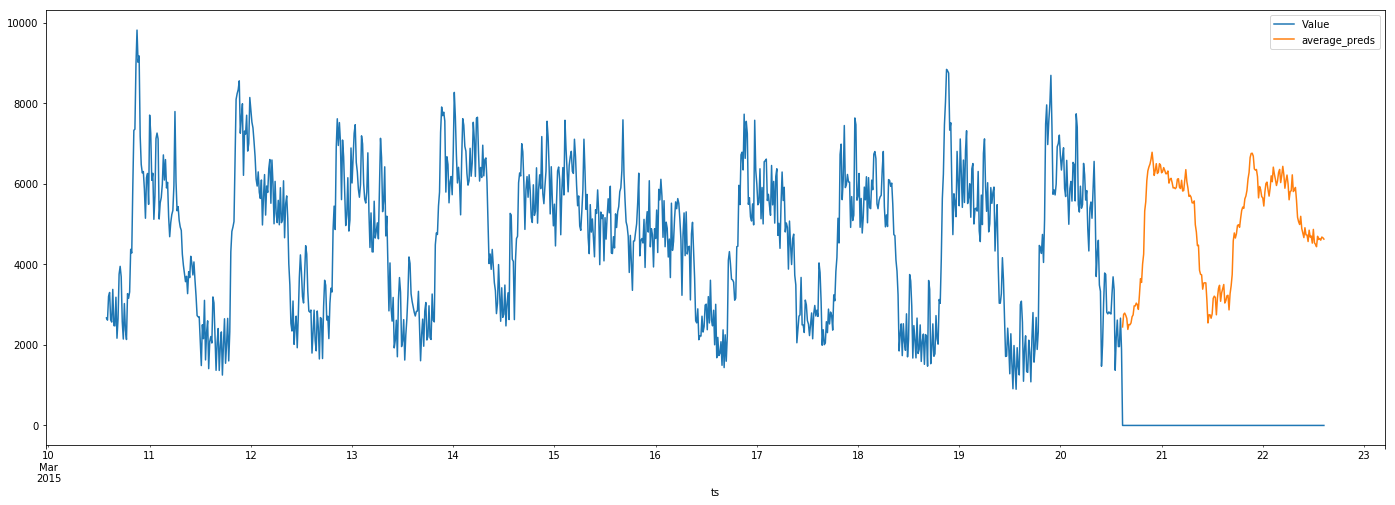

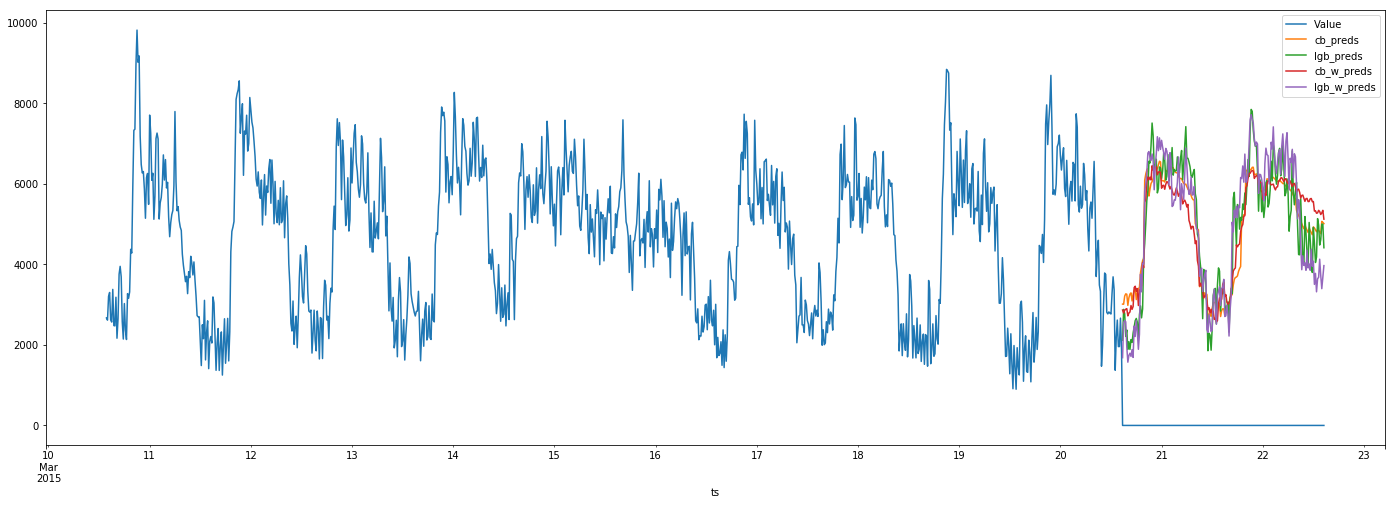

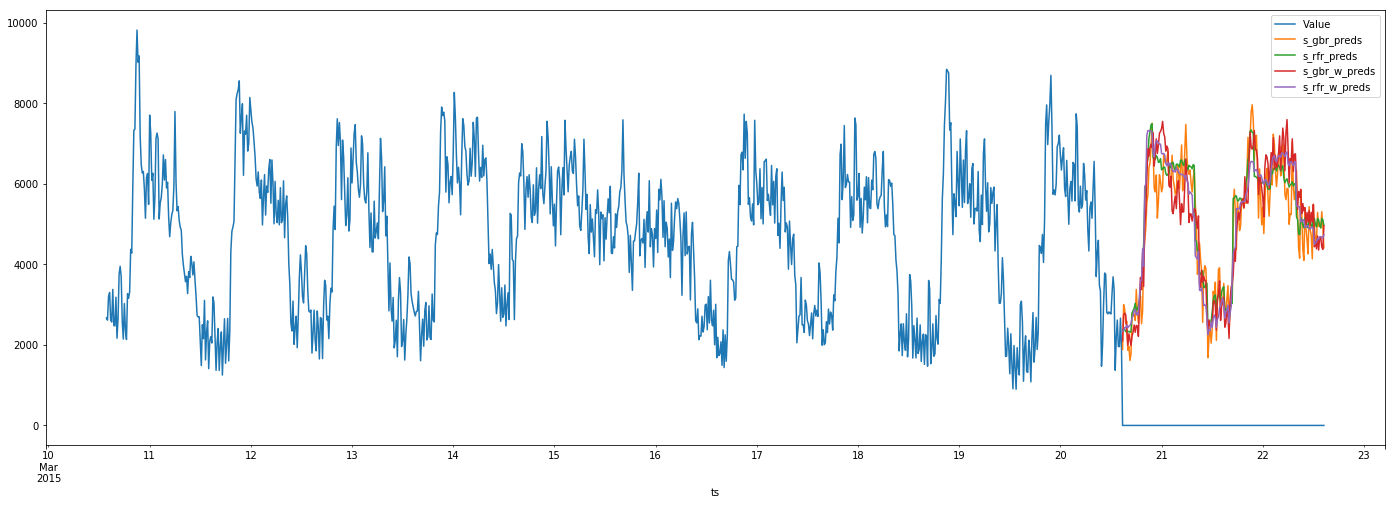

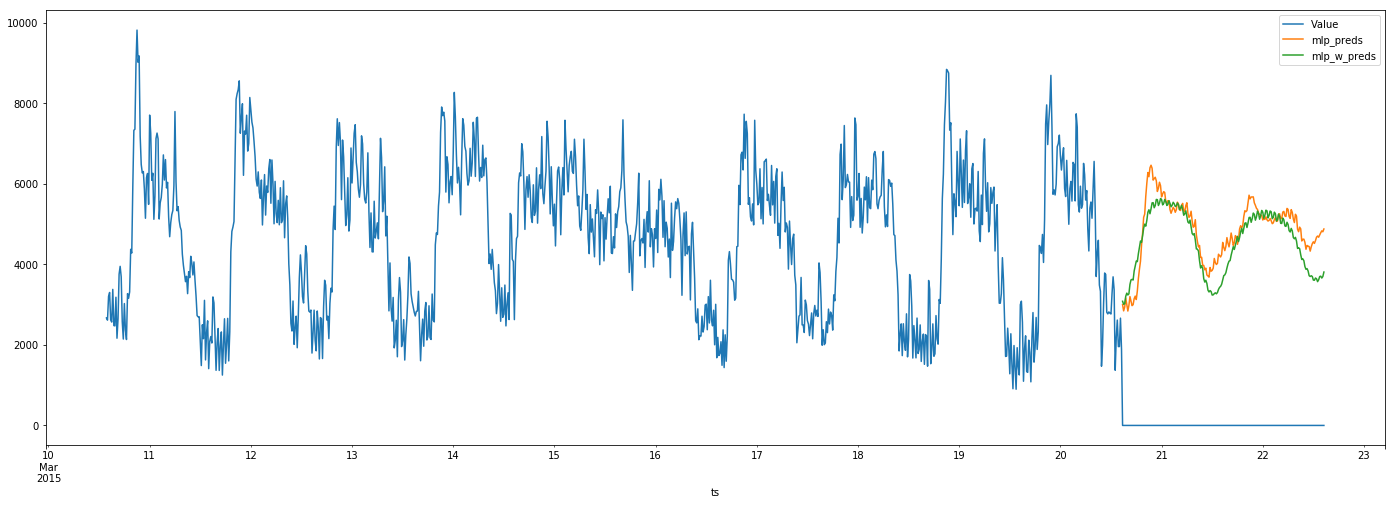

In [110]:
import matplotlib.pyplot as plt

temp_df.loc[test_ind,'cb_preds'] = cb_preds
temp_df.loc[test_ind,'lgb_preds'] = lgb_preds
temp_df.loc[test_ind,'cb_w_preds'] = cb_w_preds
temp_df.loc[test_ind,'lgb_w_preds'] = lgb_w_preds

temp_df.loc[test_ind,'s_gbr_preds'] = s_gbr_preds
temp_df.loc[test_ind,'s_rfr_preds'] = s_rfr_preds
temp_df.loc[test_ind,'s_gbr_w_preds'] = s_gbr_w_preds
temp_df.loc[test_ind,'s_rfr_w_preds'] = s_rfr_w_preds

temp_df.loc[test_ind,'mlp_preds'] = mlp_preds
temp_df.loc[test_ind,'mlp_w_preds'] = mlp_w_preds
temp_df.loc[test_ind,'average_preds'] = average_preds


cols =  ['ts','Value']

big_libraries = ['cb_preds',
        'lgb_preds',
        'cb_w_preds',
        'lgb_w_preds']

sklearn = ['s_gbr_preds',
        's_rfr_preds',
        's_gbr_w_preds',
        's_rfr_w_preds']

mlp = ['mlp_preds',
        'mlp_w_preds',]

average = ['average_preds']


temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + average].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + big_libraries].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + sklearn].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + mlp].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()



In [96]:
submission_df_3[submission_df_3.ForecastId == 500].head()

SiteId            Timestamp  ForecastId         Value
obs_id                                                        
4053038      14  2017-05-21 02:15:00         500  26434.846235
3964292      14  2017-05-21 02:30:00         500  26405.677821
6148657      14  2017-05-21 02:45:00         500  26340.350897
2077002      14  2017-05-21 03:00:00         500  26255.977200
6670983      14  2017-05-21 03:15:00         500  25705.324108

In [94]:
submission_df[submission_df.ForecastId == 500].head()

SiteId            Timestamp  ForecastId         Value
obs_id                                                        
4053038      14  2017-05-21 02:15:00         500  24371.868243
3964292      14  2017-05-21 02:30:00         500  24297.013682
6148657      14  2017-05-21 02:45:00         500  23959.166647
2077002      14  2017-05-21 03:00:00         500  25033.222558
6670983      14  2017-05-21 03:15:00         500  25255.728980

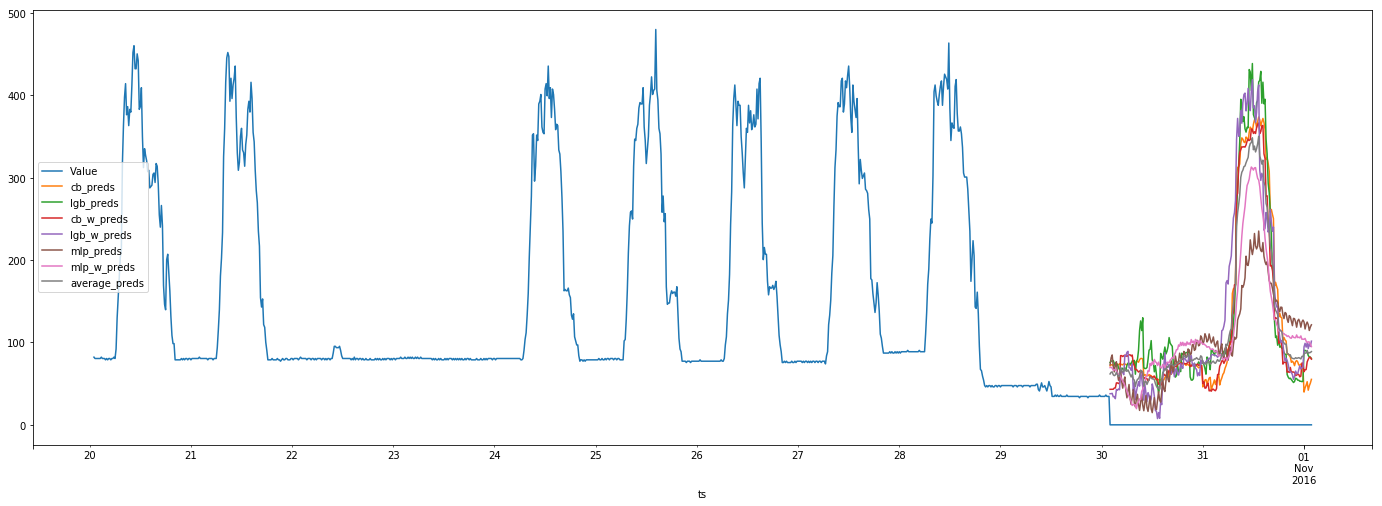

cb_r2_score_val  lgb_r2_score_val  cb_w_r2_score_val  lgb_w_r2_score_val  \
0         0.859995          0.885646           0.773933            0.841109   

   mlp_r2_score_val  mlp_w_r2_score_val  
0          0.619555            0.829982

In [99]:
import matplotlib.pyplot as plt

temp_df.loc[test_ind,'cb_preds'] = cb_preds
temp_df.loc[test_ind,'lgb_preds'] = lgb_preds
temp_df.loc[test_ind,'cb_w_preds'] = cb_w_preds
temp_df.loc[test_ind,'lgb_w_preds'] = lgb_w_preds
temp_df.loc[test_ind,'mlp_preds'] = mlp_preds
temp_df.loc[test_ind,'mlp_w_preds'] = mlp_w_preds
temp_df.loc[test_ind,'average_preds'] = average_preds

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[['ts','Value','cb_preds','lgb_preds','cb_w_preds','lgb_w_preds','mlp_preds','mlp_w_preds','average_preds']].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

cols = ['cb_r2_score_val','lgb_r2_score_val','cb_w_r2_score_val','lgb_w_r2_score_val','mlp_r2_score_val','mlp_w_r2_score_val']
stat_df_temp[cols]

In [40]:
cols = ['cb_rmse_val','lgb_rmse_val','cb_w_rmse_val','lgb_w_rmse_val','mlp_rmse_val','mlp_w_rmse_val']
stat_df_temp[cols]

cb_rmse_val  lgb_rmse_val  cb_w_rmse_val  lgb_w_rmse_val  mlp_rmse_val  \
0  7274.914489   4441.391971    6560.205027     4392.201766   8756.257929   

   mlp_w_rmse_val  
0     7894.456356

In [ ]:
stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df_2['Value'] = submission_df_2['Value'].fillna(value=0)
submission_df_3['Value'] = submission_df_3['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))

# Monster - train forests on the whole dataset, val on right 25%

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import  metrics
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

# custom utils and random forest scripts
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  slice_train_data_rf,slice_train_data_rf_weather,sk_fit_alg,\
                  slice_train_data_rf_reverse,slice_train_data_rf_weather_reverse,\
                  slice_train_data_rf_full,slice_train_data_rf_weather_full

# dummy variable list            
from holidayList import hol_list

# params for random forest baselines
from params import xgb_params,cbr_params,lgb_params,s_gbr_params,s_rfr_params

# windowed MLP baseline
from MLPPipeline import train,validate,predict_train,\
                        predict_test,slice_train_data_mlp,train_one_cnn,\
                        slice_train_data_mlp_weather

LOGNUMBER = 'super_monster_10_reverse'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

# use different set of time related features for each time span
target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))
print('SGBR params : {}'.format(s_gbr_params))
print('SRFR  params : {}'.format(s_rfr_params))

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

# store basic evaluation results
stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',
             'cb_w_rmse_train','cb_w_r2_score_train','cb_w_rmse_val','cb_w_r2_score_val','cb_w_scores',
             'lgb_w_rmse_train','lgb_w_r2_score_train','lgb_w_rmse_val','lgb_w_r2_score_val','lgb_w_scores',    
             
             's_gbr_rmse_train','s_gbr_r2_score_train','s_gbr_rmse_val','s_gbr_r2_score_val','s_gbr_scores',
             's_rfr_rmse_train','s_rfr_r2_score_train','s_rfr_rmse_val','s_rfr_r2_score_val','s_rfr_scores',
             's_gbr_w_rmse_train','s_gbr_w_r2_score_train','s_gbr_w_rmse_val','s_gbr_w_r2_score_val','s_gbr_w_scores',
             's_rfr_w_rmse_train','s_rfr_w_r2_score_train','s_rfr_w_rmse_val','s_rfr_w_r2_score_val','s_rfr_w_scores',

             'mlp_rmse_train','lmlp_r2_score_train','mlp_rmse_val','mlp_r2_score_val',  
             'mlp_w_rmse_train','lmlp_w_r2_score_train','mlp_w_rmse_val','mlp_w_r2_score_val',               
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

submission_df_2 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_2 = submission_df_2.set_index('obs_id')

submission_df_3 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_3 = submission_df_3.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 184.1466565132141
LGB params : {'n_jobs': 10, 'learning_rate': 0.1, 'random_state': 27, 'n_estimators': 700, 'boosting_type': 'gbdt', 'verbose': -1, 'num_leaves': 512, 'objective': 'regression'}
CB  params : {'learning_rate': 0.1, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 27, 'n_estimators': 700, 'thread_count': 10, 'l2_leaf_reg': 500, 'has_time': True, 'approx_on_full_history': True}
SGBR params : {'learning_rate': 0.1, 'subsample': 0.8, 'criterion': 'friedman_mse', 'verbose': 0, 'min_samples_leaf': 5, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 7}
SRFR  params : {'criterion': 'mse', 'verbose': 0, 'min_samples_leaf': 5, 'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 50}


In [13]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        forecast_id = 5
        try:
            #============ RF models ============#
            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)
            
            # first fit all models on reverse validation (train - val) to collect the metrics
            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf(df_train,
                                                                                                         df_sub,
                                                                                                         forecast_id,
                                                                                                         test_lengths)
            
            # then fit the model on the whole dataset and use the best one
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_full(df_train,
                                                             df_sub,
                                                             forecast_id,
                                                             test_lengths)
            
            start_time = time.time()

            #============ Fit CatBoost ============#
            try:
                # first collect the metrics
                cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb'] = cbr.predict(temp_df[predictors])
                cb_preds = list(temp_df.loc[test_ind].preds_cb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost fitting failed due to error : {}'.format(print(str(e))))

                cb_rmse_train = 1e9
                cb_r2_score_train = -1
                cb_rmse_val = 1e9
                cb_r2_score_val = -1
                cb_scores = []
                cb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   

            #============ Fit LightGBM ============#                
            try:
                # first collect the metrics
                lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb'] = lgb.predict(temp_df[predictors])
                lgb_preds = list(temp_df.loc[test_ind].preds_lgb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM fitting failed due to error : {}'.format(print(str(e))))
                lgb_rmse_train = 1e9
                lgb_r2_score_train = -1
                lgb_rmse_val = 1e9
                lgb_r2_score_val = -1
                lgb_scores = []
                lgb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))  

            #============ Fit Sklearn Boosted Trees ============#
            try:
                # first collect the metrics
                s_gbr_rmse_train,s_gbr_r2_score_train,s_gbr_rmse_val,s_gbr_r2_score_val,s_gbr_scores,s_gbr = sk_fit_alg(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,s_gbr = sk_fit_alg(s_gbr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr'] = s_gbr.predict(temp_df[predictors])
                s_gbr_preds = list(temp_df.loc[test_ind].preds_s_gbr)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_rmse_train = 1e9
                s_gbr_r2_score_train = -1
                s_gbr_rmse_val = 1e9
                s_gbr_r2_score_val = -1
                s_gbr_scores = []
                s_gbr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                # first collect the metrics
                s_rfr_rmse_train,s_rfr_r2_score_train,s_rfr_rmse_val,s_rfr_r2_score_val,s_rfr_scores,s_rfr = sk_fit_alg(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,s_rfr = sk_fit_alg(s_rfr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr'] = s_rfr.predict(temp_df[predictors])
                s_rfr_preds = list(temp_df.loc[test_ind].preds_s_rfr)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_rmse_train = 1e9
                s_rfr_r2_score_train = -1
                s_rfr_rmse_val = 1e9
                s_rfr_r2_score_val = -1
                s_rfr_scores = []
                s_rfr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                   
                   
            #============ RF models + future weather ============#

            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)            

            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_weather(df_train,
                                                                                                                 df_sub,
                                                                                                                 forecast_id,
                                                                                                                 test_lengths)
            
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_weather(df_train,
                                                                 df_sub,
                                                                 forecast_id,
                                                                 test_lengths)            
            
            #============ Fit CatBoost + weather ============#
            try:
                # first collect the metrics
                cb_w_rmse_train,cb_w_r2_score_train,cb_w_rmse_val,cb_w_r2_score_val,cb_w_scores,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset    
                _,_,_,_,_,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb_w'] = cbr.predict(temp_df[predictors])
                cb_w_preds = list(temp_df.loc[test_ind].preds_cb_w)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost with weather fitting failed due to error : {}'.format(print(str(e))))

                cb_w_rmse_train = 1e9
                cb_w_r2_score_train = -1
                cb_w_rmse_val = 1e9
                cb_w_r2_score_val = -1
                cb_w_scores = []
                cb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))

            #============ Fit LightGBM + weather ============#                
            try:
                # first collect the metrics
                lgb_w_rmse_train,lgb_w_r2_score_train,lgb_w_rmse_val,lgb_w_r2_score_val,lgb_w_scores,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset  
                _,_,_,_,_,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb_w'] = lgb.predict(temp_df[predictors])
                lgb_w_preds = list(temp_df.loc[test_ind].preds_lgb_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM with weather fitting failed due to error : {}'.format(print(str(e))))
                lgb_w_rmse_train = 1e9
                lgb_w_r2_score_train = -1
                lgb_w_rmse_val = 1e9
                lgb_w_r2_score_val = -1
                lgb_w_scores = []
                lgb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))            

            #============ Fit Sklearn Boosted Trees ============#
            try:
                # first collect the metrics
                s_gbr_w_rmse_train,s_gbr_w_r2_score_train,s_gbr_w_rmse_val,s_gbr_w_r2_score_val,s_gbr_w_scores,s_gbr = sk_fit_alg(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset 
                _,_,_,_,_,s_gbr = sk_fit_alg(s_gbr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr_w'] = s_gbr.predict(temp_df[predictors])
                s_gbr_w_preds = list(temp_df.loc[test_ind].preds_s_gbr_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_w_rmse_train = 1e9
                s_gbr_w_r2_score_train = -1
                s_gbr_w_rmse_val = 1e9
                s_gbr_w_r2_score_val = -1
                s_gbr_w_scores = []
                s_gbr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                # first collect the metrics
                s_rfr_w_rmse_train,s_rfr_w_r2_score_train,s_rfr_w_rmse_val,s_rfr_w_r2_score_val,s_rfr_w_scores,s_rfr = sk_fit_alg(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset 
                _,_,_,_,_,s_rfr = sk_fit_alg(s_rfr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)
                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr_w'] = s_rfr.predict(temp_df[predictors])
                s_rfr_w_preds = list(temp_df.loc[test_ind].preds_s_rfr_w)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_w_rmse_train = 1e9
                s_rfr_w_r2_score_train = -1
                s_rfr_w_rmse_val = 1e9
                s_rfr_w_r2_score_val = -1
                s_rfr_w_scores = []
                s_rfr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                                   
                
                
            #============ Train Windowed MLP models ============#
            try:
                temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data_mlp(df_train,
                                                                                                      df_sub,
                                                                                                      forecast_id,
                                                                                                      test_lengths)

                dataset_len = len(train_ind) - 1 - len(train_ind) // 3

                model,train_preds_mlp,val_preds_mlp,test_preds_mlp,mlp_rmse_train,mlp_r2_score_train,mlp_rmse_val,mlp_r2_score_val = train_one_cnn(model = None,
                                                                                                                                                     lr=1e-3,
                                                                                                                                                     start_epoch=0,
                                                                                                                                                     epochs=30,
                                                                                                                                                     cnn_type='mlp',
                                                                                                                                                     hidden_layers=512,
                                                                                                                                                     temp_df = temp_df,
                                                                                                                                                     all_hols = all_hols,
                                                                                                                                                     train_ind = train_ind,
                                                                                                                                                     test_ind = test_ind,
                                                                                                                                                     prediction_freq = prediction_freq,
                                                                                                                                                     predictors = predictors
                                                                                                                                                     )
                temp_df['preds_mlp'] = 0
                temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'preds_mlp'] = train_preds_mlp
                temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'preds_mlp'] = val_preds_mlp
                temp_df.loc[test_ind, 'preds_mlp'] = test_preds_mlp[:,0,0]
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                mlp_preds = list(temp_df.loc[test_ind].preds_mlp)
            except Exception as e:
                # in case of exception - record poor scores
                print('MLP fitting failed due to error : {}'.format(print(str(e))))
                mlp_rmse_train = 1e9
                mlp_r2_score_train = -1
                mlp_rmse_val = 1e9
                mlp_r2_score_val = -1
                mlp_preds = [0] * len(list(temp_df.loc[test_ind].obs_id))    

            #============ Train Windowed MLP models + future weather ============#
            try:
                temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data_mlp_weather(df_train,
                                                                                                      df_sub,
                                                                                                      forecast_id,
                                                                                                      test_lengths)


                dataset_len = len(train_ind) - 1 - len(train_ind) // 3

                model,train_preds_mlp_w,val_preds_mlp_w,test_preds_mlp_w,mlp_rmse_train_w,mlp_r2_score_train_w,mlp_rmse_val_w,mlp_r2_score_val_w = train_one_cnn(model = None,
                                                                                                                                                     lr=1e-3,
                                                                                                                                                     start_epoch=0,
                                                                                                                                                     epochs=30,
                                                                                                                                                     cnn_type='mlp',
                                                                                                                                                     hidden_layers=512,
                                                                                                                                                     temp_df = temp_df,
                                                                                                                                                     all_hols = all_hols,
                                                                                                                                                     train_ind = train_ind,
                                                                                                                                                     test_ind = test_ind,
                                                                                                                                                     prediction_freq = prediction_freq,
                                                                                                                                                     predictors = predictors
                                                                                                                                                     )
                temp_df['preds_mlp_w'] = 0
                temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'preds_mlp_w'] = train_preds_mlp_w
                temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'preds_mlp_w'] = val_preds_mlp_w
                temp_df.loc[test_ind, 'preds_mlp_w'] = test_preds_mlp_w[:,0,0]
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                mlp_w_preds = list(temp_df.loc[test_ind].preds_mlp_w)  
            except Exception as e:
                # in case of exception - record poor scores
                print('MLP with weather fitting failed due to error : {}'.format(print(str(e))))
                mlp_rmse_train_w = 1e9
                mlp_r2_score_train_w = -1
                mlp_rmse_val_w = 1e9
                mlp_r2_score_val_w = -1
                mlp_w_preds = [0] * len(list(temp_df.loc[test_ind].obs_id))          

            #============ Record scores ============#  
            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['cb_w_rmse_train'] = [cb_w_rmse_train]
            stat_df_temp['cb_w_r2_score_train'] = [cb_w_r2_score_train]
            stat_df_temp['cb_w_rmse_val'] = [cb_w_rmse_val]
            stat_df_temp['cb_w_r2_score_val'] = [cb_w_r2_score_val]
            stat_df_temp['cb_w_scores'] = [cb_w_scores]

            stat_df_temp['lgb_w_rmse_train'] = [lgb_w_rmse_train]
            stat_df_temp['lgb_w_r2_score_train'] = [lgb_w_r2_score_train]
            stat_df_temp['lgb_w_rmse_val'] = [lgb_w_rmse_val]
            stat_df_temp['lgb_w_r2_score_val'] = [lgb_w_r2_score_val]
            stat_df_temp['lgb_w_scores'] = [lgb_w_scores]
            
           
            stat_df_temp['s_gbr_rmse_train'] = [s_gbr_rmse_train]
            stat_df_temp['s_gbr_r2_score_train'] = [s_gbr_r2_score_train]
            stat_df_temp['s_gbr_rmse_val'] = [s_gbr_rmse_val]
            stat_df_temp['s_gbr_r2_score_val'] = [s_gbr_r2_score_val]
            stat_df_temp['s_gbr_scores'] = [s_gbr_scores]

            stat_df_temp['s_rfr_rmse_train'] = [s_rfr_rmse_train]
            stat_df_temp['s_rfr_r2_score_train'] = [s_rfr_r2_score_train]
            stat_df_temp['s_rfr_rmse_val'] = [s_rfr_rmse_val]
            stat_df_temp['s_rfr_r2_score_val'] = [s_rfr_r2_score_val]
            stat_df_temp['s_rfr_scores'] = [s_rfr_scores]

            stat_df_temp['s_gbr_w_rmse_train'] = [s_gbr_w_rmse_train]
            stat_df_temp['s_gbr_w_r2_score_train'] = [s_gbr_w_r2_score_train]
            stat_df_temp['s_gbr_w_rmse_val'] = [s_gbr_w_rmse_val]
            stat_df_temp['s_gbr_w_r2_score_val'] = [s_gbr_w_r2_score_val]
            stat_df_temp['s_gbr_w_scores'] = [s_gbr_w_scores]
            
            stat_df_temp['s_rfr_w_rmse_train'] = [s_rfr_w_rmse_train]
            stat_df_temp['s_rfr_w_r2_score_train'] = [s_rfr_w_r2_score_train]
            stat_df_temp['s_rfr_w_rmse_val'] = [s_rfr_w_rmse_val]
            stat_df_temp['s_rfr_w_r2_score_val'] = [s_rfr_w_r2_score_val]
            stat_df_temp['s_rfr_w_scores'] = [s_rfr_w_scores] 
            
           
            
            stat_df_temp['mlp_rmse_train'] = [mlp_rmse_train]
            stat_df_temp['mlp_r2_score_train'] = [mlp_r2_score_train]
            stat_df_temp['mlp_rmse_val'] = [mlp_rmse_val]
            stat_df_temp['mlp_r2_score_val'] = [mlp_r2_score_val]

            stat_df_temp['mlp_w_rmse_train'] = [mlp_rmse_train_w]
            stat_df_temp['mlp_w_r2_score_train'] = [mlp_r2_score_train_w]
            stat_df_temp['mlp_w_rmse_val'] = [mlp_rmse_val_w]
            stat_df_temp['mlp_w_r2_score_val'] = [mlp_r2_score_val_w]        

            #============ Finish recording scores ============#  
            # record scores even if they are bad
            stat_df_temp['time_taken'] = [elapsed_time]              
            stat_df = stat_df.append(stat_df_temp)     

            # log every 500 iterations
            if (i+1)%500 == 0:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
                submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
                submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)            

            #============ Choose the best model ============# 

            best_model_idx = np.asarray([cb_rmse_val,lgb_rmse_val,cb_w_rmse_val,lgb_w_rmse_val,s_gbr_rmse_val,s_rfr_rmse_val,s_gbr_w_rmse_val,s_rfr_w_rmse_val,mlp_rmse_val,mlp_rmse_val_w]).argmin() 
            best_model_r2 = np.asarray([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val,mlp_r2_score_val,mlp_r2_score_val_w]).max()
            
            if sum([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val,mlp_r2_score_val,mlp_r2_score_val_w]) == -10:
                # all the models failed / produce crap
                raise ValueError('All the models failed - submit last value to both dataframes')
            else:
                # save best result in the first dataframe anyway
                if best_model_idx == 0:
                    submission_df.loc[obs_ids,'Value'] = cb_preds
                elif best_model_idx == 1:
                    submission_df.loc[obs_ids,'Value'] = lgb_preds
                elif best_model_idx == 2:
                    submission_df.loc[obs_ids,'Value'] = cb_w_preds
                elif best_model_idx == 3:
                    submission_df.loc[obs_ids,'Value'] = lgb_w_preds

                elif best_model_idx == 4:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_preds
                elif best_model_idx == 5:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_preds
                elif best_model_idx == 6:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_w_preds
                elif best_model_idx == 7:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_w_preds
                    
                elif best_model_idx == 8:
                    submission_df.loc[obs_ids,'Value'] = mlp_preds
                elif best_model_idx == 9:
                    submission_df.loc[obs_ids,'Value'] = mlp_w_preds
                
                # if no model failed
                if -1 not in [cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val,mlp_r2_score_val,mlp_r2_score_val_w]:
                    # save averages to the third dataframe                
                    arr = np.vstack((cb_preds,lgb_preds,cb_w_preds,lgb_w_preds,s_gbr_preds,s_rfr_preds,s_gbr_w_preds,s_rfr_w_preds,mlp_preds,mlp_w_preds))
                    average_preds = list(arr.mean(axis=0))
                    submission_df_3.loc[obs_ids,'Value'] = average_preds
                else:
                    # if any of the models failed - just submit the best model instead of average
                    if best_model_idx == 0:
                        submission_df_3.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_3.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_w_preds

                    elif best_model_idx == 8:
                        submission_df_3.loc[obs_ids,'Value'] = mlp_preds
                    elif best_model_idx == 9:
                        submission_df_3.loc[obs_ids,'Value'] = mlp_w_preds
                    
                # if there is no proper model, submit the last ts value to the second dataframe
                # otherwise save proper values to the second dataframe
                if best_model_r2 < 0:
                    try:
                        train_mean = temp_df.Value.iloc[-1]
                    except:
                        print('Bad train data sample, submitting 0')
                        train_mean = 0
                    submission_df_2.loc[obs_ids,'Value'] = [train_mean] * len(obs_ids)
                    
                    with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                        the_file.write(str(forecast_id)+'\n')
                
                else:
                    # save the best model to the second dataframe
                    if best_model_idx == 0:
                        submission_df_2.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_2.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_w_preds

                    elif best_model_idx == 8:
                        submission_df_2.loc[obs_ids,'Value'] = mlp_preds
                    elif best_model_idx == 9:
                        submission_df_2.loc[obs_ids,'Value'] = mlp_w_preds           
              
        except Exception as e:
            
            with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
                        
                        
            # if model fitting and prediction fails, then just submit average values            
            print('Error {}. Forecast_id {}, submitting mean'.format(str(e),forecast_id))
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            
            # save last value or 0 to both dataframes
            submission_df.loc[obs_ids,'Value'] = predictions
            submission_df_2.loc[obs_ids,'Value'] = predictions
            submission_df_3.loc[obs_ids,'Value'] = predictions

        break

  0%|          | 1/6974 [00:23<46:05:01, 23.79s/it]


In [16]:
cols = ['cb_rmse_val',
        'lgb_rmse_val',
        'cb_w_rmse_val',
        'lgb_w_rmse_val',
        's_gbr_rmse_val',
        's_rfr_rmse_val',
        's_gbr_w_rmse_val',
        's_rfr_w_rmse_val',
        'mlp_rmse_val',
        'mlp_w_rmse_val']

stat_df_temp[cols]

cb_rmse_val  lgb_rmse_val  cb_w_rmse_val  lgb_w_rmse_val  s_gbr_rmse_val  \
0  90588.882084  73689.855345   78768.857713    69967.654968    93520.079595   

   s_rfr_rmse_val  s_gbr_w_rmse_val  s_rfr_w_rmse_val  mlp_rmse_val  \
0     95204.75117      86861.726075      79157.665086  34844.122979   

   mlp_w_rmse_val  
0    38328.546413

In [15]:
cols = ['cb_r2_score_val',
        'lgb_r2_score_val',
        'cb_w_r2_score_val',
        'lgb_w_r2_score_val',
        's_gbr_r2_score_val',
        's_rfr_r2_score_val',
        's_gbr_w_r2_score_val',
        's_rfr_w_r2_score_val',
        'mlp_r2_score_val',
        'mlp_w_r2_score_val']

stat_df_temp[cols]

cb_r2_score_val  lgb_r2_score_val  cb_w_r2_score_val  lgb_w_r2_score_val  \
0       -36.728303        -23.965075          -27.52506          -21.506715   

   s_gbr_r2_score_val  s_rfr_r2_score_val  s_gbr_w_r2_score_val  \
0          -39.209364          -40.671076             -33.68761   

   s_rfr_w_r2_score_val  mlp_r2_score_val  mlp_w_r2_score_val  
0            -27.807357          0.807338            0.766879

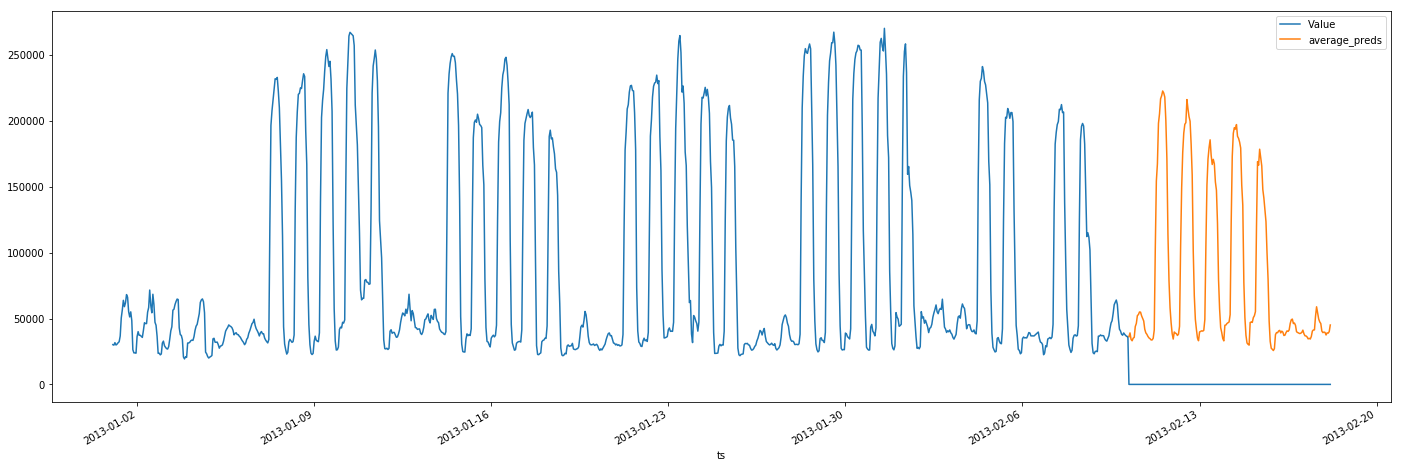

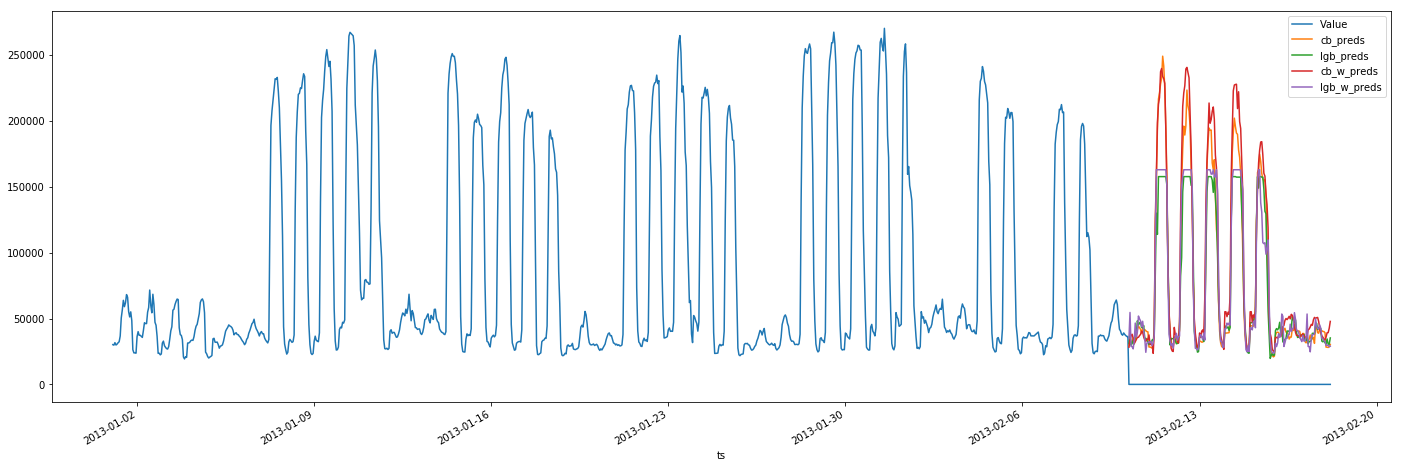

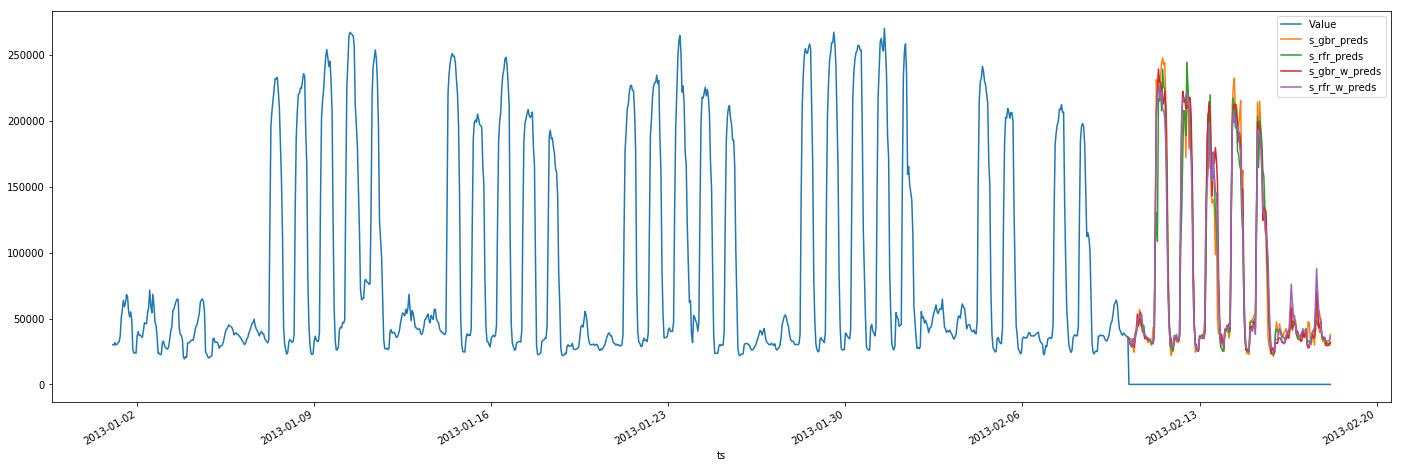

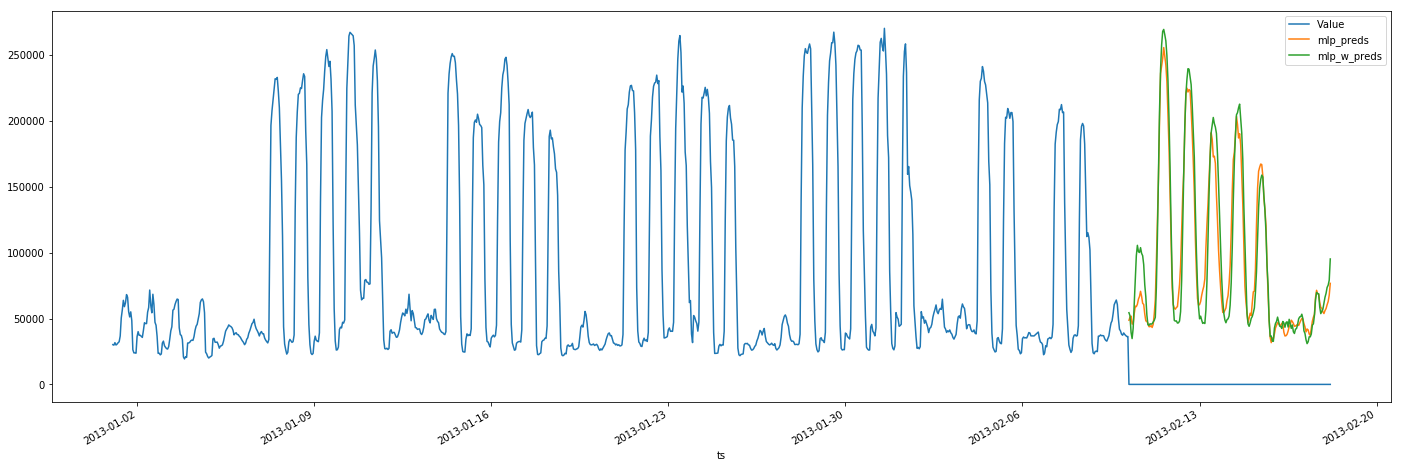

In [14]:
import matplotlib.pyplot as plt

temp_df.loc[test_ind,'cb_preds'] = cb_preds
temp_df.loc[test_ind,'lgb_preds'] = lgb_preds
temp_df.loc[test_ind,'cb_w_preds'] = cb_w_preds
temp_df.loc[test_ind,'lgb_w_preds'] = lgb_w_preds

temp_df.loc[test_ind,'s_gbr_preds'] = s_gbr_preds
temp_df.loc[test_ind,'s_rfr_preds'] = s_rfr_preds
temp_df.loc[test_ind,'s_gbr_w_preds'] = s_gbr_w_preds
temp_df.loc[test_ind,'s_rfr_w_preds'] = s_rfr_w_preds

temp_df.loc[test_ind,'mlp_preds'] = mlp_preds
temp_df.loc[test_ind,'mlp_w_preds'] = mlp_w_preds
temp_df.loc[test_ind,'average_preds'] = average_preds


cols =  ['ts','Value']

big_libraries = ['cb_preds',
        'lgb_preds',
        'cb_w_preds',
        'lgb_w_preds']

sklearn = ['s_gbr_preds',
        's_rfr_preds',
        's_gbr_w_preds',
        's_rfr_w_preds']

mlp = ['mlp_preds',
        'mlp_w_preds',]

average = ['average_preds']


temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + average].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + big_libraries].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + sklearn].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + mlp].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

# Monster model, val on right using WRMSE, record WRMSE

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import  metrics
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

# custom utils and random forest scripts
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  slice_train_data_rf,slice_train_data_rf_weather,sk_fit_alg,\
                  slice_train_data_rf_reverse,slice_train_data_rf_weather_reverse,\
                  slice_train_data_rf_full,slice_train_data_rf_weather_full,\
                  sk_fit_alg_wrmse,cb_fit_log_alg_wrmse,lgb_fit_log_alg_wrmse                    

# dummy variable list            
from holidayList import hol_list

# params for random forest baselines
from params import xgb_params,cbr_params,lgb_params,s_gbr_params,s_rfr_params

# windowed MLP baseline
from MLPPipeline import train,validate,predict_train,\
                        predict_test,slice_train_data_mlp,train_one_cnn,\
                        slice_train_data_mlp_weather

LOGNUMBER = 'super_monster_10_reverse_wo_mlp'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

# use different set of time related features for each time span
target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))
print('SGBR params : {}'.format(s_gbr_params))
print('SRFR  params : {}'.format(s_rfr_params))

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

# store basic evaluation results
stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',
             'cb_w_rmse_train','cb_w_r2_score_train','cb_w_rmse_val','cb_w_r2_score_val','cb_w_scores',
             'lgb_w_rmse_train','lgb_w_r2_score_train','lgb_w_rmse_val','lgb_w_r2_score_val','lgb_w_scores',    
             
             's_gbr_rmse_train','s_gbr_r2_score_train','s_gbr_rmse_val','s_gbr_r2_score_val','s_gbr_scores',
             's_rfr_rmse_train','s_rfr_r2_score_train','s_rfr_rmse_val','s_rfr_r2_score_val','s_rfr_scores',
             's_gbr_w_rmse_train','s_gbr_w_r2_score_train','s_gbr_w_rmse_val','s_gbr_w_r2_score_val','s_gbr_w_scores',
             's_rfr_w_rmse_train','s_rfr_w_r2_score_train','s_rfr_w_rmse_val','s_rfr_w_r2_score_val','s_rfr_w_scores',

             'model_chosen'               
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

submission_df_2 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_2 = submission_df_2.set_index('obs_id')

submission_df_3 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_3 = submission_df_3.set_index('obs_id')

         

Starting the ETL process
Time taken to complete the ETL process 164.2713544368744
LGB params : {'boosting_type': 'gbdt', 'n_jobs': 10, 'verbose': -1, 'learning_rate': 0.1, 'n_estimators': 700, 'num_leaves': 512, 'random_state': 27, 'objective': 'regression'}
CB  params : {'random_state': 27, 'has_time': True, 'verbose': False, 'learning_rate': 0.1, 'approx_on_full_history': True, 'l2_leaf_reg': 500, 'n_estimators': 700, 'thread_count': 10, 'loss_function': 'RMSE'}
SGBR params : {'criterion': 'friedman_mse', 'min_samples_split': 2, 'min_samples_leaf': 5, 'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
SRFR  params : {'criterion': 'mse', 'min_samples_split': 2, 'min_samples_leaf': 5, 'verbose': 0, 'max_depth': 100, 'n_estimators': 50}


In [3]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        forecast_id = 2938
        try:
            #============ RF models ============#
            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)
            
            # first fit all models on reverse validation (train - val) to collect the metrics
            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_reverse(df_train,
                                                                                                         df_sub,
                                                                                                         forecast_id,
                                                                                                         test_lengths)
            
            # then fit the model on the whole dataset and use the best one
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_full(df_train,
                                                             df_sub,
                                                             forecast_id,
                                                             test_lengths)
            
            start_time = time.time()

            #============ Fit CatBoost ============#
            try:
                # first collect the metrics
                cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg_wrmse(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,cbr = cb_fit_log_alg_wrmse(cbr,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb'] = cbr.predict(temp_df[predictors])
                cb_preds = list(temp_df.loc[test_ind].preds_cb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost fitting failed due to error : {}'.format(print(str(e))))

                cb_rmse_train = 1e9
                cb_r2_score_train = -1
                cb_rmse_val = 1e9
                cb_r2_score_val = -1
                cb_scores = []
                cb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   

            #============ Fit LightGBM ============#                
            try:
                # first collect the metrics
                lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg_wrmse(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb'] = lgb.predict(temp_df[predictors])
                lgb_preds = list(temp_df.loc[test_ind].preds_lgb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM fitting failed due to error : {}'.format(print(str(e))))
                lgb_rmse_train = 1e9
                lgb_r2_score_train = -1
                lgb_rmse_val = 1e9
                lgb_r2_score_val = -1
                lgb_scores = []
                lgb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))  

            #============ Fit Sklearn Boosted Trees ============#
            try:
                # first collect the metrics
                s_gbr_rmse_train,s_gbr_r2_score_train,s_gbr_rmse_val,s_gbr_r2_score_val,s_gbr_scores,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr'] = s_gbr.predict(temp_df[predictors])
                s_gbr_preds = list(temp_df.loc[test_ind].preds_s_gbr)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_rmse_train = 1e9
                s_gbr_r2_score_train = -1
                s_gbr_rmse_val = 1e9
                s_gbr_r2_score_val = -1
                s_gbr_scores = []
                s_gbr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                # first collect the metrics
                s_rfr_rmse_train,s_rfr_r2_score_train,s_rfr_rmse_val,s_rfr_r2_score_val,s_rfr_scores,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr'] = s_rfr.predict(temp_df[predictors])
                s_rfr_preds = list(temp_df.loc[test_ind].preds_s_rfr)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_rmse_train = 1e9
                s_rfr_r2_score_train = -1
                s_rfr_rmse_val = 1e9
                s_rfr_r2_score_val = -1
                s_rfr_scores = []
                s_rfr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                   
                   
            #============ RF models + future weather ============#

            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)            

            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_weather_reverse(df_train,
                                                                                                                 df_sub,
                                                                                                                 forecast_id,
                                                                                                                 test_lengths)
            
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_weather_full(df_train,
                                                                 df_sub,
                                                                 forecast_id,
                                                                 test_lengths)            
            
            #============ Fit CatBoost + weather ============#
            try:
                # first collect the metrics
                cb_w_rmse_train,cb_w_r2_score_train,cb_w_rmse_val,cb_w_r2_score_val,cb_w_scores,cbr = cb_fit_log_alg_wrmse(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset    
                _,_,_,_,_,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb_w'] = cbr.predict(temp_df[predictors])
                cb_w_preds = list(temp_df.loc[test_ind].preds_cb_w)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost with weather fitting failed due to error : {}'.format(print(str(e))))

                cb_w_rmse_train = 1e9
                cb_w_r2_score_train = -1
                cb_w_rmse_val = 1e9
                cb_w_r2_score_val = -1
                cb_w_scores = []
                cb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))

            #============ Fit LightGBM + weather ============#                
            try:
                # first collect the metrics
                lgb_w_rmse_train,lgb_w_r2_score_train,lgb_w_rmse_val,lgb_w_r2_score_val,lgb_w_scores,lgb = lgb_fit_log_alg_wrmse(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset  
                _,_,_,_,_,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb_w'] = lgb.predict(temp_df[predictors])
                lgb_w_preds = list(temp_df.loc[test_ind].preds_lgb_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM with weather fitting failed due to error : {}'.format(print(str(e))))
                lgb_w_rmse_train = 1e9
                lgb_w_r2_score_train = -1
                lgb_w_rmse_val = 1e9
                lgb_w_r2_score_val = -1
                lgb_w_scores = []
                lgb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))            

            #============ Fit Sklearn Boosted Trees ============#
            try:
                # first collect the metrics
                s_gbr_w_rmse_train,s_gbr_w_r2_score_train,s_gbr_w_rmse_val,s_gbr_w_r2_score_val,s_gbr_w_scores,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset 
                _,_,_,_,_,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr_w'] = s_gbr.predict(temp_df[predictors])
                s_gbr_w_preds = list(temp_df.loc[test_ind].preds_s_gbr_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_w_rmse_train = 1e9
                s_gbr_w_r2_score_train = -1
                s_gbr_w_rmse_val = 1e9
                s_gbr_w_r2_score_val = -1
                s_gbr_w_scores = []
                s_gbr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                # first collect the metrics
                s_rfr_w_rmse_train,s_rfr_w_r2_score_train,s_rfr_w_rmse_val,s_rfr_w_r2_score_val,s_rfr_w_scores,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset 
                _,_,_,_,_,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)
                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr_w'] = s_rfr.predict(temp_df[predictors])
                s_rfr_w_preds = list(temp_df.loc[test_ind].preds_s_rfr_w)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_w_rmse_train = 1e9
                s_rfr_w_r2_score_train = -1
                s_rfr_w_rmse_val = 1e9
                s_rfr_w_r2_score_val = -1
                s_rfr_w_scores = []
                s_rfr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                                   
               

            #============ Record scores ============#  
            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['cb_w_rmse_train'] = [cb_w_rmse_train]
            stat_df_temp['cb_w_r2_score_train'] = [cb_w_r2_score_train]
            stat_df_temp['cb_w_rmse_val'] = [cb_w_rmse_val]
            stat_df_temp['cb_w_r2_score_val'] = [cb_w_r2_score_val]
            stat_df_temp['cb_w_scores'] = [cb_w_scores]

            stat_df_temp['lgb_w_rmse_train'] = [lgb_w_rmse_train]
            stat_df_temp['lgb_w_r2_score_train'] = [lgb_w_r2_score_train]
            stat_df_temp['lgb_w_rmse_val'] = [lgb_w_rmse_val]
            stat_df_temp['lgb_w_r2_score_val'] = [lgb_w_r2_score_val]
            stat_df_temp['lgb_w_scores'] = [lgb_w_scores]
            
           
            stat_df_temp['s_gbr_rmse_train'] = [s_gbr_rmse_train]
            stat_df_temp['s_gbr_r2_score_train'] = [s_gbr_r2_score_train]
            stat_df_temp['s_gbr_rmse_val'] = [s_gbr_rmse_val]
            stat_df_temp['s_gbr_r2_score_val'] = [s_gbr_r2_score_val]
            stat_df_temp['s_gbr_scores'] = [s_gbr_scores]

            stat_df_temp['s_rfr_rmse_train'] = [s_rfr_rmse_train]
            stat_df_temp['s_rfr_r2_score_train'] = [s_rfr_r2_score_train]
            stat_df_temp['s_rfr_rmse_val'] = [s_rfr_rmse_val]
            stat_df_temp['s_rfr_r2_score_val'] = [s_rfr_r2_score_val]
            stat_df_temp['s_rfr_scores'] = [s_rfr_scores]

            stat_df_temp['s_gbr_w_rmse_train'] = [s_gbr_w_rmse_train]
            stat_df_temp['s_gbr_w_r2_score_train'] = [s_gbr_w_r2_score_train]
            stat_df_temp['s_gbr_w_rmse_val'] = [s_gbr_w_rmse_val]
            stat_df_temp['s_gbr_w_r2_score_val'] = [s_gbr_w_r2_score_val]
            stat_df_temp['s_gbr_w_scores'] = [s_gbr_w_scores]
            
            stat_df_temp['s_rfr_w_rmse_train'] = [s_rfr_w_rmse_train]
            stat_df_temp['s_rfr_w_r2_score_train'] = [s_rfr_w_r2_score_train]
            stat_df_temp['s_rfr_w_rmse_val'] = [s_rfr_w_rmse_val]
            stat_df_temp['s_rfr_w_r2_score_val'] = [s_rfr_w_r2_score_val]
            stat_df_temp['s_rfr_w_scores'] = [s_rfr_w_scores] 
           
            best_model_idx = np.asarray([cb_rmse_val,lgb_rmse_val,cb_w_rmse_val,lgb_w_rmse_val,s_gbr_rmse_val,s_rfr_rmse_val,s_gbr_w_rmse_val,s_rfr_w_rmse_val]).argmin() 
            if best_model_idx == 0:
                stat_df_temp['model_chosen'] = ['cb']  
            elif best_model_idx == 1:
                stat_df_temp['model_chosen'] = ['lgb'] 
            elif best_model_idx == 2:
                stat_df_temp['model_chosen'] = ['cb_w']
            elif best_model_idx == 3:
                stat_df_temp['model_chosen'] = ['lgb_w']
            elif best_model_idx == 4:
                stat_df_temp['model_chosen'] = ['s_gbr']
            elif best_model_idx == 5:
                stat_df_temp['model_chosen'] = ['s_rfr']
            elif best_model_idx == 6:
                stat_df_temp['model_chosen'] = ['s_gbr_w']
            elif best_model_idx == 7:
                stat_df_temp['model_chosen'] = ['s_rfr_w']             
            

            #============ Finish recording scores ============#  
            # record scores even if they are bad
            stat_df_temp['time_taken'] = [elapsed_time]              
            stat_df = stat_df.append(stat_df_temp)     

            # log every 500 iterations
            if (i+1)%500 == 0:
                stat_df.to_csv('forest_stats_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
                submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
                submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)            

            #============ Choose the best model ============# 

            best_model_r2 = np.asarray([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val]).max()
            
            if sum([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val]) == -8:
                # all the models failed / produce crap
                raise ValueError('All the models failed - submit last value to both dataframes')
            else:
                # save best result in the first dataframe anyway
                if best_model_idx == 0:
                    submission_df.loc[obs_ids,'Value'] = cb_preds
                elif best_model_idx == 1:
                    submission_df.loc[obs_ids,'Value'] = lgb_preds
                elif best_model_idx == 2:
                    submission_df.loc[obs_ids,'Value'] = cb_w_preds
                elif best_model_idx == 3:
                    submission_df.loc[obs_ids,'Value'] = lgb_w_preds

                elif best_model_idx == 4:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_preds
                elif best_model_idx == 5:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_preds
                elif best_model_idx == 6:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_w_preds
                elif best_model_idx == 7:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_w_preds

                # if no model failed
                if -1 not in [cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val]:
                    # save averages to the third dataframe                
                    arr = np.vstack((cb_preds,lgb_preds,cb_w_preds,lgb_w_preds,s_gbr_preds,s_rfr_preds,s_gbr_w_preds,s_rfr_w_preds))
                    average_preds = list(arr.mean(axis=0))
                    submission_df_3.loc[obs_ids,'Value'] = average_preds
                else:
                    # if any of the models failed - just submit the best model instead of average
                    if best_model_idx == 0:
                        submission_df_3.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_3.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_w_preds

                    
                # if there is no proper model, submit the last ts value to the second dataframe
                # otherwise save proper values to the second dataframe
                if best_model_r2 < 0:
                    try:
                        train_mean = temp_df.Value.iloc[-1]
                    except:
                        print('Bad train data sample, submitting 0')
                        train_mean = 0
                    submission_df_2.loc[obs_ids,'Value'] = [train_mean] * len(obs_ids)
                    
                    with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                        the_file.write(str(forecast_id)+'\n')
                
                else:
                    # save the best model to the second dataframe
                    if best_model_idx == 0:
                        submission_df_2.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_2.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_w_preds
        
              
        except Exception as e:
            
            with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
                        
                        
            # if model fitting and prediction fails, then just submit average values            
            print('Error {}. Forecast_id {}, submitting mean'.format(str(e),forecast_id))
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            
            # save last value or 0 to both dataframes
            submission_df.loc[obs_ids,'Value'] = predictions
            submission_df_2.loc[obs_ids,'Value'] = predictions
            submission_df_3.loc[obs_ids,'Value'] = predictions
            
        break

  0%|          | 1/6974 [00:03<7:05:49,  3.66s/it]


In [ ]:
temp_df['preds_s_rfr_w'] = s_rfr.predict(temp_df[predictors])

In [4]:
temp_df[predictors]

temp_diff  Temperature  is_day_off  dow  hour        TF1        TF5  \
0          -2.0         20.0           1    6    21  18.000000  18.000000   
1           0.0         18.0           1    6    22  18.000000  18.000000   
2          19.0         18.0           1    6    23  18.000000  18.000000   
3          19.0         18.0           0    0     0  18.000000  18.000000   
4          19.0         18.0           0    0     1  18.000000  18.000000   
5          19.0         18.0           0    0     2  18.000000  18.000000   
6          19.0         18.0           0    0     3  18.000000  19.000000   
7          19.0         18.0           0    0     4  18.000000  20.000000   
8          19.0         18.0           0    0     5  18.000000  22.000000   
9          19.0         18.0           0    0     6  18.000000  24.000000   
10          0.0         18.0           0    0     7  19.000000  26.000000   
11         -1.0         19.0           0    0     8  20.000000  27.000000   
12         -2.0         20.0           0    0     9  22.000000  29.000000   
13         -4.0         22.0           0    0    10  24.000000  29.000000   
14         -6.0         24.0           0    0    11  26.000000  28.000000   
15         -8.0         26.0           0    0    12  27.000000  28.000000   
16         -9.0         27.0           0    0    13  29.000000  27.000000   
17        -11.0         29.0           0    0    14  29.000000  26.000000   
18        -11.0         29.0           0    0    15  28.000000  24.000000   
19        -10.0         28.0           0    0    16  28.000000  21.000000   
20        -10.0         28.0           0    0    17  27.000000  20.000000   
21         -9.0         27.0           0    0    18  26.000000  20.000000   
22         -8.0         26.0           0    0    19  24.000000  20.000000   
23         -6.0         24.0           0    0    20  21.000000  20.000000   
24         -3.0         21.0           0    0    21  20.000000  20.000000   
25         -2.0         20.0           0    0    22  20.000000  20.000000   
26         19.0         20.0           0    0    23  20.000000  20.000000   
27         19.0         20.0           0    1     0  20.000000  20.000000   
28         19.0         20.0           0    1     1  20.000000  20.000000   
29         19.0         20.0           0    1     2  20.000000  20.500000   
...         ...          ...         ...  ...   ...        ...        ...   
1126       -8.0         26.0           0    4    19  25.000000  23.000000   
1127       -7.0         25.0           0    4    20  24.000000  23.000000   
1128       -6.0         24.0           0    4    21  23.000000  23.000000   
1129       -5.0         23.0           0    4    22  23.000000  23.000000   
1130       19.0         23.0           0    4    23  23.000000  23.000000   
1131       19.0         23.0           1    5     0  23.000000  23.000000   
1132       19.0         23.0           1    5     1  23.000000  23.000000   
1133       19.0         23.0           1    5     2  23.000000  19.500000   
1134       19.0         23.0           1    5     3  23.000000  20.000000   
1135       19.0         23.0           1    5     4  23.000000  22.000000   
1136       19.0         23.0           1    5     5  23.000000  23.000000   
1137       19.0         23.0           1    5     6  19.500000  24.000000   
1138       -1.5         19.5           1    5     7  20.000000  25.000000   
1139       -2.0         20.0           1    5     8  22.000000  23.000000   
1140       -4.0         22.0           1    5     9  23.000000  21.000000   
1141       -5.0         23.0           1    5    10  24.000000  21.000000   
1142       -6.0         24.0           1    5    11  25.000000  21.000000   
1143       -7.0         25.0           1    5    12  23.000000  21.000000   
1144       -5.0         23.0           1    5    13  21.000000  22.000000   
1145       -3.0         21.0           1    5    14  21.000000  20.000000   
11

In [14]:
temp_df[pd.isnull(temp_df.Value) ].filter(items=train_ind,axis=0)

Empty DataFrame
Columns: [index, obs_id, SiteId, Timestamp, ForecastId, Value, ts, year, month, day, hour, minute, second, dow, ForecastId_type, ts_trend, Surface, BaseTemperature, is_day_off, Temperature, hol_All Saints Day, hol_Annunciation, hol_Armistice Day, hol_Armistice of 1918, hol_Ascension Thursday, hol_Assumption of Mary to Heaven, hol_Assunção de Nossa Senhora, hol_Bastille Day, hol_Berchtold's Day, hol_Birthday of Martin Luther King, Jr., hol_Boxing Day, hol_Cesar Chavez Day, hol_Christmas Day, hol_Christmas Day (Observed), hol_Christmas Day substitute, hol_Christmas Eve, hol_Christmas Eve (Observed), hol_Christmas Eve shift, hol_Clean Monday, hol_Columbus Day, hol_Columbus Day / Fraternal Day / American Indian Heritage Day, hol_Confederate Heroes Day, hol_Confederate Heroes Day (Observed), hol_Confederate Memorial Day, hol_Corpus Christi, hol_Day After Christmas, hol_Day After Christmas (Observed), hol_Day of Blessed Virgin Mary, patron saint of Slovakia, hol_Day of good will, hol_Day of reconcilation, hol_Day of the Constitution of the Slovak Republic, hol_Day of the Establishment of the Slovak Republic, hol_Dia da Liberdade, hol_Dia de Portugal, hol_Dia do Trabalhador, hol_Día de la Constitución Española, hol_Día del trabajador, hol_Easter Monday, hol_Easter Sunday, hol_Election Day, hol_Election Day / Susan B. Anthony Day, hol_Emancipation Day in Texas, hol_Emancipation Day in Texas (Observed), hol_Entrudo, hol_Epiphany, hol_Family Day, hol_Fiesta nacional de España, hol_Freedom Day, hol_Freedom Day substitute, hol_General Election Day, hol_George Washington/Thomas Jefferson Birthday, hol_Glorifying Mother of God, hol_Good Friday, hol_Heritage Day, hol_Heritage Day substitute, hol_Human Rights Day, hol_Imaculada Conceição, hol_Immaculate Conception, hol_Independence Day, hol_Independence Day (Observed), hol_International Workers' Day, hol_Jefferson Davis Birthday, hol_Labor Day, hol_Labour Day, hol_Liberation Day, hol_Lincoln's Birthday, hol_Local Elections, hol_Lyndon B. Jonhson Day, hol_Lyndon B. Jonhson Day (Observed), hol_Mardi Gras, hol_Memorial Day, hol_National Day, hol_National Elections, hol_National Holiday, hol_National Women Day, hol_National Women Day substitute, hol_New Years Eve, hol_New Years Eve (Observed), hol_New Years Eve Shift, hol_New year, ...]
Index: []

[0 rows x 147 columns]

In [4]:
cols1 = ['cb_r2_score_val','cb_w_r2_score_val','lgb_r2_score_val','lgb_w_r2_score_val','s_gbr_r2_score_val','s_rfr_r2_score_val','s_rfr_w_r2_score_val','s_rfr_w_r2_score_val']
cols2 = ['cb_rmse_val','cb_w_rmse_val','lgb_rmse_val','lgb_w_rmse_val','s_gbr_rmse_val','s_rfr_rmse_val','s_gbr_w_rmse_val','s_rfr_w_rmse_val']

In [33]:
stat_df_temp['model_chosen']

0    s_gbr
Name: model_chosen, dtype: object

In [31]:
stat_df_temp[cols2]

cb_rmse_val  cb_w_rmse_val  lgb_rmse_val  lgb_w_rmse_val  s_gbr_rmse_val  \
0     0.110428       0.157478      0.041435        0.060849        0.037969   

   s_rfr_rmse_val  s_gbr_w_rmse_val  s_rfr_w_rmse_val  
0        0.040326          0.056738          0.047091

In [32]:
stat_df_temp[cols1]

cb_r2_score_val  cb_w_r2_score_val  lgb_r2_score_val  lgb_w_r2_score_val  \
0         0.873142           0.717304          0.988081            0.972698   

   s_gbr_r2_score_val  s_rfr_r2_score_val  s_rfr_w_r2_score_val  \
0            0.989688            0.987363              0.979651   

   s_rfr_w_r2_score_val  
0              0.979651

In [6]:
Tn = len(temp_df)
Tn

1156

In [8]:
t = np.arange(1, Tn+1)
t

array([   1,    2,    3, ..., 1154, 1155, 1156])

In [9]:
W = (3*Tn - 2*t + 1)/(2*Tn**2)

In [ ]:
def WRMSE(y, pred_y):
    sq_err = np.square(y - pred_y)
    Tn = len(y)
    t = np.arange(1, Tn+1)
    W = (3*Tn - 2*t + 1)/(2*Tn**2)
    mu = y.mean()+1e-15
    return np.sqrt(np.sum(W*sq_err))/mu

In [ ]:
stat_df.to_csv('forest_stats_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df_2['Value'] = submission_df_2['Value'].fillna(value=0)
submission_df_3['Value'] = submission_df_3['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))   

# Implement CNN with validation on the right part of the dataset + WRMSE loss

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import  metrics
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

# custom utils and random forest scripts
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  slice_train_data_rf,slice_train_data_rf_weather,sk_fit_alg,\
                  slice_train_data_rf_reverse,slice_train_data_rf_weather_reverse,\
                  slice_train_data_rf_full,slice_train_data_rf_weather_full,\
                  sk_fit_alg_wrmse,cb_fit_log_alg_wrmse,lgb_fit_log_alg_wrmse                    

# dummy variable list            
from holidayList import hol_list

# params for random forest baselines
from params import xgb_params,cbr_params,lgb_params,s_gbr_params,s_rfr_params

# windowed MLP baseline
from MLPPipeline import train,validate,predict_train,\
                        predict_test,slice_train_data_mlp,train_one_cnn,\
                        slice_train_data_mlp_weather

LOGNUMBER = 'super_monster_10_reverse_wo_mlp'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

# use different set of time related features for each time span
target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

forecast_ids = list(test_lengths.keys())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))
print('SGBR params : {}'.format(s_gbr_params))
print('SRFR  params : {}'.format(s_rfr_params))

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

# store basic evaluation results
stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',
             'cb_w_rmse_train','cb_w_r2_score_train','cb_w_rmse_val','cb_w_r2_score_val','cb_w_scores',
             'lgb_w_rmse_train','lgb_w_r2_score_train','lgb_w_rmse_val','lgb_w_r2_score_val','lgb_w_scores',    
             
             's_gbr_rmse_train','s_gbr_r2_score_train','s_gbr_rmse_val','s_gbr_r2_score_val','s_gbr_scores',
             's_rfr_rmse_train','s_rfr_r2_score_train','s_rfr_rmse_val','s_rfr_r2_score_val','s_rfr_scores',
             's_gbr_w_rmse_train','s_gbr_w_r2_score_train','s_gbr_w_rmse_val','s_gbr_w_r2_score_val','s_gbr_w_scores',
             's_rfr_w_rmse_train','s_rfr_w_r2_score_train','s_rfr_w_rmse_val','s_rfr_w_r2_score_val','s_rfr_w_scores',

             'model_chosen'               
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

submission_df_2 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_2 = submission_df_2.set_index('obs_id')

submission_df_3 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_3 = submission_df_3.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 217.27952933311462
LGB params : {'verbose': -1, 'objective': 'regression', 'random_state': 27, 'boosting_type': 'gbdt', 'num_leaves': 512, 'learning_rate': 0.1, 'n_jobs': 10, 'n_estimators': 700}
CB  params : {'verbose': False, 'random_state': 27, 'thread_count': 10, 'learning_rate': 0.1, 'n_estimators': 700, 'loss_function': 'RMSE', 'approx_on_full_history': True, 'has_time': True, 'l2_leaf_reg': 500}
SGBR params : {'verbose': 0, 'subsample': 0.8, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'min_samples_leaf': 5, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}
SRFR  params : {'verbose': 0, 'min_samples_leaf': 5, 'criterion': 'mse', 'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 50}


In [49]:
# store basic evaluation results
stat_cols = ['forecast_id',
             'mlp_wrmse_train','lmlp_r2_score_train','mlp_wrmse_val','mlp_r2_score_val',  
             'mlp_w_wrmse_train','lmlp_w_r2_score_train','mlp_w_wrmse_val','mlp_w_r2_score_val',               
            ]
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

submission_df_2 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_2 = submission_df_2.set_index('obs_id')

submission_df_3 = pd.read_csv('../data/forecast/submission_format.csv')
submission_df_3 = submission_df_3.set_index('obs_id')

In [ ]:
    train_dataset = EDataset(df = temp_df,
                             in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             target = 'Value',
                             predictors = predictors,
                             train_index = train_ind,
                             test_index = test_ind,
                             mode = 'train',
                             split_mode = 'right')

In [16]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,MultiStepLR
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn import Sigmoid, MSELoss

# custom classes
from EDataset import EDataset
from WindowCNN import MLPWindow,LSTMWindow,GRUWindow,MLPWindowWoBnorm

import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
from holidayList import hol_list

import numpy as np
from math import sqrt

def train_one_cnn_wrmse(model = None,
                 lr=1e-4,
                 start_epoch=0,
                 epochs=100,
                 cnn_type='mlp',
                 hidden_layers=256,
                 temp_df = None,
                 all_hols = [],
                 train_ind = [],
                 test_ind = [],
                 prediction_freq = '',
                 predictors = []
                 ):
    
    if model is None:
        if cnn_type=='mlp':
            model = MLPWindow(in_sequence_len = len(train_ind) // 3,
                              out_sequence_len = 1,
                              features_len = len(predictors) + 1,
                              hidden_layer_length = hidden_layers)
        elif cnn_type=='mlp_wobnorm':
            model = MLPWindowWoBnorm(in_sequence_len = len(train_ind) // 3,
                              out_sequence_len = 1,
                              features_len = len(predictors) + 1,
                              hidden_layer_length = hidden_layers)            
        elif cnn_type=='gru':
            model = GRUWindow(in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             features_len = len(predictors) + 1,
                             hidden_size = hidden_layers,
                             num_layers = 2,
                             lstm_dropout = 0.5,
                             use_bnorm = False
                             )
        elif cnn_type=='lstm':
            model = LSTMWindow(in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             features_len = len(predictors) + 1,
                             hidden_size = hidden_layers,
                             num_layers = 2,
                             lstm_dropout = 0.5,
                             use_bnorm = False
                             )
        else:
            print('Model not supported')
            
        model = model.cuda()
    else:
        pass

    
    train_dataset = EDataset(df = temp_df,
                             in_sequence_len = len(train_ind) // 3,
                             out_sequence_len = 1,
                             target = 'Value',
                             predictors = predictors,
                             train_index = train_ind,
                             test_index = test_ind,
                             mode = 'train',
                             split_mode = 'right')

    val_dataset = EDataset(df = temp_df,
                         in_sequence_len = len(train_ind) // 3,
                         out_sequence_len = 1,
                         target = 'Value',
                         predictors = predictors,
                         train_index = train_ind,
                         test_index = test_ind,
                         mode = 'val',
                         split_mode = 'right')
    
    predict_dataset = EDataset(df = temp_df,
                         in_sequence_len = len(train_ind) // 3,
                         out_sequence_len = 1,
                         target = 'Value',
                         predictors = predictors,
                         train_index = train_ind,
                         test_index = test_ind,
                         mode = 'test',
                         split_mode = 'right')    

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2000,        
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        drop_last=False)

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=2000,        
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        drop_last=False)
    
    criterion = MSELoss().cuda()
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr = lr)
    
    scheduler = ReduceLROnPlateau(optimizer = optimizer,
                                              mode = 'min',
                                              factor = 0.1,
                                              patience = 4,
                                              verbose = True,
                                              threshold = 1e-3,
                                              min_lr = 1e-7
                                              )    
    
    with tqdm.tqdm(total=epochs) as pbar:
        for epoch in range(start_epoch, epochs):
            # train for one epoch
            train_loss = train(train_loader, model, criterion, optimizer, epoch)
            # evaluate on validation set
            val_loss = validate(val_loader, model, criterion)
            scheduler.step(val_loss)
            pbar.set_description('Epoch [{0}/{1}]'.format(str(epoch).zfill(3),str(epochs).zfill(3)), refresh=False)
            pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, refresh=False)
            pbar.update(1)
    
    train_preds =  predict_train(model,
                                 train_dataset)
    
    val_preds =  predict_train(model,
                                 val_dataset)  
        
    print(train_preds.shape)
    print(train_dataset.__len__())
    train_predicts_idx = list(range(len(train_ind) // 3 + 1, len(train_ind) - train_dataset.dataset_len // 4 - 1))
    val_predicts_idx = list(range(len(train_ind) - train_dataset.dataset_len // 4 - 1, len(train_ind)))
        
    # evaluate metrics on the train dataset
    true_train_values = temp_df.loc[train_predicts_idx, 'Value'].values
    
    rmse_train = WRMSE(true_train_values, train_preds)
    r2_score_train = metrics.r2_score(true_train_values, train_preds)
    
    # evaluate metrics on the val dataset
    true_val_values = temp_df.loc[val_predicts_idx, 'Value'].values
    
    # print(true_val_values.shape)
    # print(val_preds.shape)
    
    rmse_val = WRMSE(true_val_values, val_preds)
    r2_score_val = metrics.r2_score(true_val_values, val_preds)
    
    test_preds = predict_test(model,predict_dataset)
    
    return model,train_preds,val_preds,test_preds,rmse_train,r2_score_train,rmse_val,r2_score_val

class WMSELoss(nn.Module):
    def __init__(self):
        super(WMSELoss, self).__init__()
    def forward(self, input, target):
        sq_err = (input - target) ** 2
        Tn = len(target)
        t = torch.arange(1, Tn+1)
        W = (3*Tn - 2*t + 1)/(2*Tn**2)
        mu = target.mean()+1e-15

        W = torch.autograd.Variable(W).cuda()
        
        return ((torch.sum(W*sq_err)) ** 0.5)/mu
    
def WRMSE(y, pred_y):
    sq_err = np.square(y - pred_y)
    Tn = len(y)
    t = np.arange(1, Tn+1)
    W = (3*Tn - 2*t + 1)/(2*Tn**2)
    mu = y.mean()+1e-15
    return np.sqrt(np.sum(W*sq_err))/mu    

In [25]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        forecast_id = 3500
        # try:
        #============ Train Windowed MLP models ============#
        # try:
        temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data_mlp_weather(df_train,
                                                                                              df_sub,
                                                                                              forecast_id,
                                                                                              test_lengths)

        dataset_len = len(train_ind) - 1 - len(train_ind) // 3

        model,train_preds_mlp,val_preds_mlp,test_preds_mlp,mlp_rmse_train,mlp_r2_score_train,mlp_rmse_val,mlp_r2_score_val = train_one_cnn_wrmse(model = None,
                                                                                                                                             lr=1e-3,
                                                                                                                                             start_epoch=0,
                                                                                                                                             epochs=30,
                                                                                                                                             cnn_type='mlp',
                                                                                                                                             hidden_layers=256,
                                                                                                                                             temp_df = temp_df,
                                                                                                                                             all_hols = all_hols,
                                                                                                                                             train_ind = train_ind,
                                                                                                                                             test_ind = test_ind,
                                                                                                                                             prediction_freq = prediction_freq,
                                                                                                                                             predictors = predictors
                                                                                                                                             )
        temp_df['preds_mlp'] = 0

        train_predicts_idx = list(range(len(train_ind) // 3 + 1, len(train_ind) - dataset_len // 4 - 1))
        val_predicts_idx = list(range(len(train_ind) - dataset_len // 4 - 1, len(train_ind)))

        # print(train_predicts_idx)
        # print(val_predicts_idx)

        temp_df.loc[train_predicts_idx, 'preds_mlp'] = train_preds_mlp
        temp_df.loc[val_predicts_idx, 'preds_mlp'] = val_preds_mlp
        temp_df.loc[test_ind, 'preds_mlp'] = test_preds_mlp[:,0,0]
        obs_ids = list(temp_df.loc[test_ind].obs_id)
        mlp_preds = list(temp_df.loc[test_ind].preds_mlp)
        """
        except Exception as e:
            # in case of exception - record poor scores
            print('MLP fitting failed due to error : {}'.format(print(str(e))))
            mlp_rmse_train = 1e9
            mlp_r2_score_train = -1
            mlp_rmse_val = 1e9
            mlp_r2_score_val = -1
            mlp_preds = [0] * len(list(temp_df.loc[test_ind].obs_id))    
        """
        #============ Train Windowed MLP models + future weather ============#
        """
        try:
            temp_df,all_hols,train_ind,test_ind,prediction_freq,predictors = slice_train_data_mlp_weather(df_train,
                                                                                                  df_sub,
                                                                                                  forecast_id,
                                                                                                  test_lengths)


            dataset_len = len(train_ind) - 1 - len(train_ind) // 3

            model,train_preds_mlp_w,val_preds_mlp_w,test_preds_mlp_w,mlp_rmse_train_w,mlp_r2_score_train_w,mlp_rmse_val_w,mlp_r2_score_val_w = train_one_cnn(model = None,
                                                                                                                                                 lr=1e-3,
                                                                                                                                                 start_epoch=0,
                                                                                                                                                 epochs=30,
                                                                                                                                                 cnn_type='mlp',
                                                                                                                                                 hidden_layers=512,
                                                                                                                                                 temp_df = temp_df,
                                                                                                                                                 all_hols = all_hols,
                                                                                                                                                 train_ind = train_ind,
                                                                                                                                                 test_ind = test_ind,
                                                                                                                                                 prediction_freq = prediction_freq,
                                                                                                                                                 predictors = predictors
                                                                                                                                                 )
            temp_df['preds_mlp_w'] = 0
            temp_df.loc[list(range(len(train_ind) // 3 + 1 + dataset_len // 4, len(train_ind) )), 'preds_mlp_w'] = train_preds_mlp_w
            temp_df.loc[list(range(len(train_ind) // 3 + 1, len(train_ind) // 3 + 1 + dataset_len // 4)), 'preds_mlp_w'] = val_preds_mlp_w
            temp_df.loc[test_ind, 'preds_mlp_w'] = test_preds_mlp_w[:,0,0]
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            mlp_w_preds = list(temp_df.loc[test_ind].preds_mlp_w)  
        except Exception as e:
            # in case of exception - record poor scores
            print('MLP with weather fitting failed due to error : {}'.format(print(str(e))))
            mlp_rmse_train_w = 1e9
            mlp_r2_score_train_w = -1
            mlp_rmse_val_w = 1e9
            mlp_r2_score_val_w = -1
            mlp_w_preds = [0] * len(list(temp_df.loc[test_ind].obs_id))          
        """

        # in case of exception - record poor scores

        mlp_rmse_train_w = 1e9
        mlp_r2_score_train_w = -1
        mlp_rmse_val_w = 1e9
        mlp_r2_score_val_w = -1
        mlp_w_preds = [0] * len(list(temp_df.loc[test_ind].obs_id))                

        #============ Record scores ============#  
        elapsed_time = time.time() - start_time 

        stat_df_temp = pd.DataFrame(columns=stat_cols)
        stat_df_temp['forecast_id'] = [forecast_id]

        stat_df_temp['mlp_rmse_train'] = [mlp_rmse_train]
        stat_df_temp['mlp_r2_score_train'] = [mlp_r2_score_train]
        stat_df_temp['mlp_rmse_val'] = [mlp_rmse_val]
        stat_df_temp['mlp_r2_score_val'] = [mlp_r2_score_val]

        stat_df_temp['mlp_w_rmse_train'] = [mlp_rmse_train_w]
        stat_df_temp['mlp_w_r2_score_train'] = [mlp_r2_score_train_w]
        stat_df_temp['mlp_w_rmse_val'] = [mlp_rmse_val_w]
        stat_df_temp['mlp_w_r2_score_val'] = [mlp_r2_score_val_w]        

        #============ Finish recording scores ============#  
        # record scores even if they are bad
        stat_df_temp['time_taken'] = [elapsed_time]              
        stat_df = stat_df.append(stat_df_temp)     

        # log every 500 iterations
        if (i+1)%500 == 0:
            stat_df.to_csv('forest_stats_{}.csv'.format(LOGNUMBER))
            submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
            submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
            submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))
            print('Iteration {}, logs saved'.format(i))
        pbar.update(1)            

        #============ Choose the best model ============# 

        best_model_idx = np.asarray([mlp_rmse_val,mlp_rmse_val_w]).argmin() 
        best_model_r2 = np.asarray([mlp_r2_score_val,mlp_r2_score_val_w]).max()
       
        """       
        except Exception as e:
            
            # with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
            #    the_file.write(str(forecast_id)+'\n')
                        
                        
            # if model fitting and prediction fails, then just submit average values            
            print('Error {}. Forecast_id {}, submitting mean'.format(str(e),forecast_id))
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            
            # save last value or 0 to both dataframes
            submission_df.loc[obs_ids,'Value'] = predictions
            submission_df_2.loc[obs_ids,'Value'] = predictions
            submission_df_3.loc[obs_ids,'Value'] = predictions
            
        """            
        break

Epoch [008/030]:  30%|███       | 9/30 [00:03<00:07,  2.81it/s, train_loss=0.31, val_loss=0.322] 

Epoch     8: reducing learning rate of group 0 to 1.0000e-04.



Epoch [013/030]:  47%|████▋     | 14/30 [00:04<00:04,  3.25it/s, train_loss=0.323, val_loss=0.327]

Epoch    13: reducing learning rate of group 0 to 1.0000e-05.



Epoch [018/030]:  63%|██████▎   | 19/30 [00:06<00:03,  3.45it/s, train_loss=0.324, val_loss=0.299]

Epoch    18: reducing learning rate of group 0 to 1.0000e-06.



Epoch [023/030]:  80%|████████  | 24/30 [00:07<00:01,  3.07it/s, train_loss=0.307, val_loss=0.27] 

Epoch    23: reducing learning rate of group 0 to 1.0000e-07.



Epoch [029/030]: 100%|██████████| 30/30 [00:10<00:00,  2.64it/s, train_loss=0.338, val_loss=0.246]


(278,)
278


  0%|          | 1/6974 [00:11<21:25:54, 11.06s/it]


In [26]:
stat_df_temp

forecast_id cb_rmse_train cb_r2_score_train cb_rmse_val cb_r2_score_val  \
0         3500           NaN               NaN         NaN             NaN   

  cb_scores lgb_rmse_train lgb_r2_score_train lgb_rmse_val lgb_r2_score_val  \
0       NaN            NaN                NaN          NaN              NaN   

      ...      model_chosen mlp_rmse_train mlp_r2_score_train mlp_rmse_val  \
0     ...               NaN       0.143428           0.661352     0.147408   

  mlp_r2_score_val mlp_w_rmse_train mlp_w_r2_score_train mlp_w_rmse_val  \
0          0.66381     1.000000e+09                   -1   1.000000e+09   

  mlp_w_r2_score_val   time_taken  
0                 -1  1344.872696  

[1 rows x 51 columns]

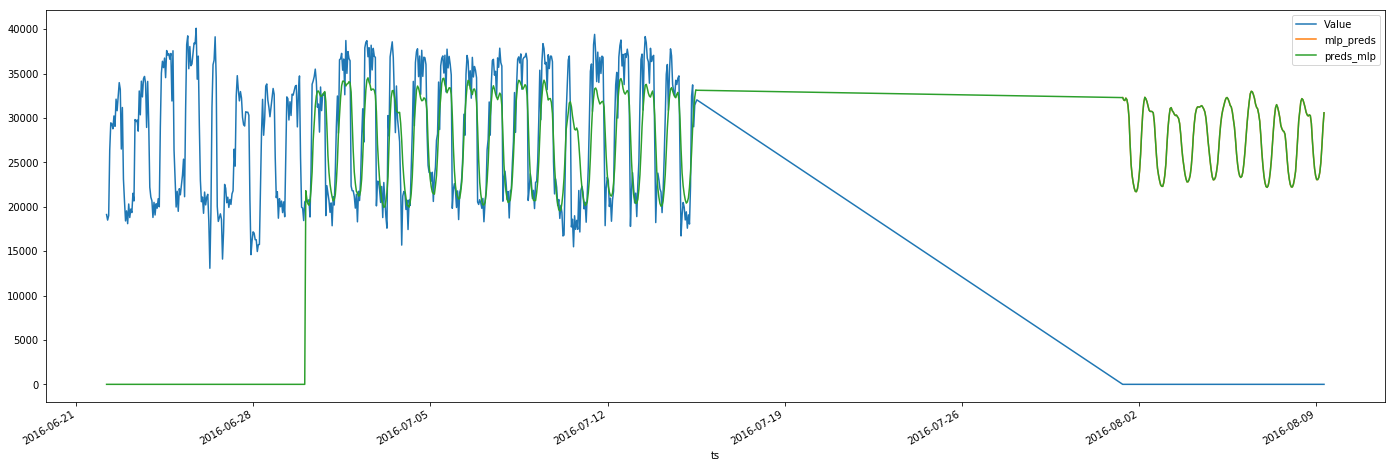

In [27]:
import matplotlib.pyplot as plt


temp_df.loc[test_ind,'mlp_preds'] = mlp_preds

cols =  ['ts','Value']

mlp = ['mlp_preds','preds_mlp']

temp_df.iloc[:][pd.notnull(temp_df.Value)].sort_values(by='ts',ascending=True)[cols + mlp].plot(x = 'ts',figsize=(24, 8 * 1))
plt.show()

In [ ]:
stat_df.to_csv('forest_stats_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df_2['Value'] = submission_df_2['Value'].fillna(value=0)
submission_df_3['Value'] = submission_df_3['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))

# Train on whole site_ids

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import  metrics
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

# custom utils and random forest scripts
from Utils import parse_date,date_to_int,clean_ids,process_categorical_features,add_forecast_id_type,\
                  process_days_off,convert_to_dummies,ETL,count_test_period,xgb_fit_log,produce_ar_features,\
                  cb_fit_log,cb_fit_log_alg,lgb_fit_log_alg,produce_ar_step,cb_predict_test,lgb_predict_test,\
                  slice_train_data_rf,slice_train_data_rf_weather,sk_fit_alg,\
                  slice_train_data_rf_reverse,slice_train_data_rf_weather_reverse,\
                  slice_train_data_rf_full,slice_train_data_rf_weather_full,\
                  sk_fit_alg_wrmse,cb_fit_log_alg_wrmse,lgb_fit_log_alg_wrmse                    

# dummy variable list            
from holidayList import hol_list

# params for random forest baselines
from params import xgb_params,cbr_params,lgb_params,s_gbr_params,s_rfr_params

# windowed MLP baseline
from MLPPipeline import train,validate,predict_train,\
                        predict_test,slice_train_data_mlp,train_one_cnn,\
                        slice_train_data_mlp_weather

LOGNUMBER = 'super_monster_10_reverse_wo_mlp'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

# use different set of time related features for each time span
target = 'Value'
numeric_features = ['temp_diff','Temperature','is_day_off']
time_features_day = ['dow']
time_features_hour = ['dow','hour']
time_features_15min = ['dow','hour','minute']

forecast_ids = list(test_lengths.keys())
site_ids = list(df_sub.SiteId.unique())

print('LGB params : {}'.format(lgb_params))
print('CB  params : {}'.format(cbr_params))
print('SGBR params : {}'.format(s_gbr_params))
print('SRFR  params : {}'.format(s_rfr_params))

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

# store basic evaluation results
stat_cols = ['forecast_id','wrmse_val','r2_val','model']
stat_df = pd.DataFrame(columns=stat_cols)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

Starting the ETL process
Time taken to complete the ETL process 181.47520780563354
LGB params : {'learning_rate': 0.1, 'verbose': -1, 'n_estimators': 700, 'random_state': 27, 'boosting_type': 'gbdt', 'objective': 'regression', 'n_jobs': 10, 'num_leaves': 512}
CB  params : {'n_estimators': 700, 'l2_leaf_reg': 500, 'verbose': False, 'approx_on_full_history': True, 'random_state': 27, 'learning_rate': 0.1, 'has_time': True, 'loss_function': 'RMSE', 'thread_count': 10}
SGBR params : {'min_samples_leaf': 5, 'n_estimators': 100, 'verbose': 0, 'max_depth': 7, 'learning_rate': 0.1, 'criterion': 'friedman_mse', 'subsample': 0.8, 'min_samples_split': 2}
SRFR  params : {'min_samples_leaf': 5, 'n_estimators': 50, 'verbose': 0, 'min_samples_split': 2, 'criterion': 'mse', 'max_depth': 100}


In [49]:
site_id = 199

In [153]:
len(train_ind),len(val_ind),len(test_ind)

(765, 119, 238)

In [136]:
set(train_ind).intersection(set(test_ind))

set()

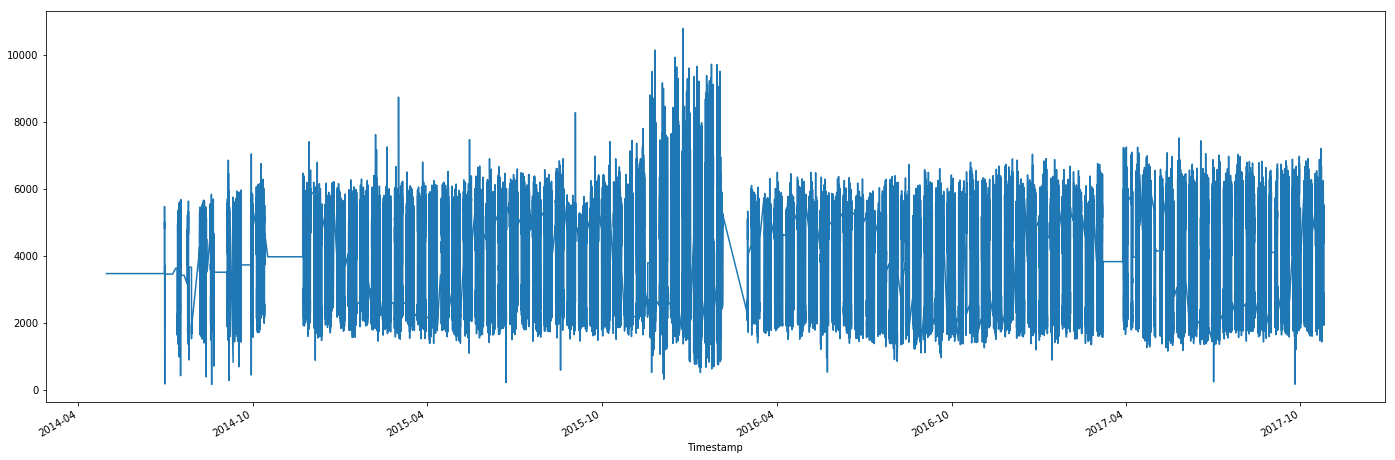

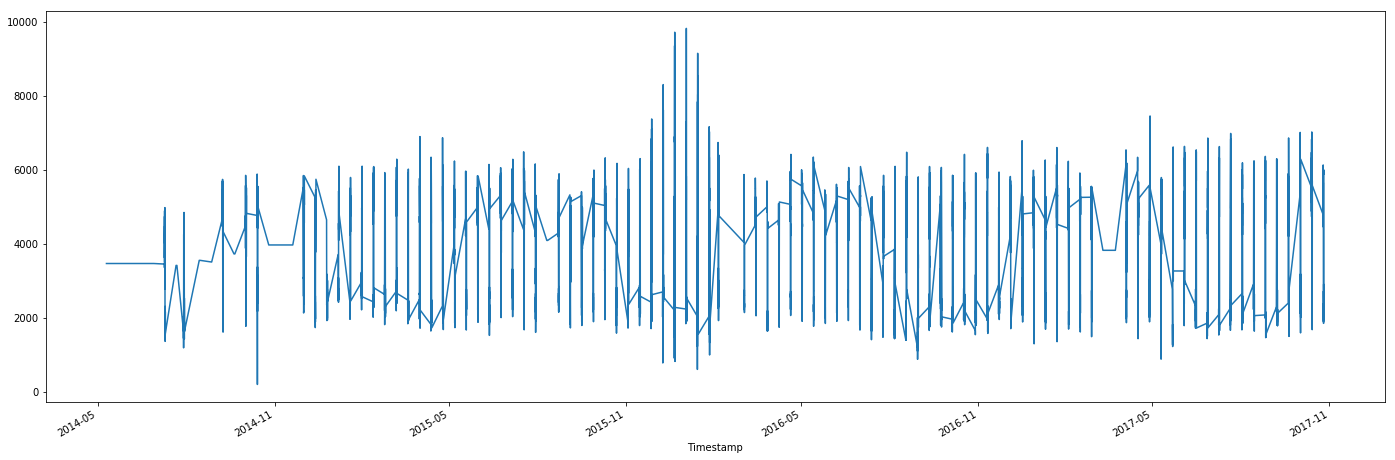

In [143]:
import matplotlib.pyplot as plt

temp_df.iloc[train_ind][['Timestamp','Value']].plot(x = 'Timestamp',figsize=(24, 8 * 1), legend=[])
plt.show()
temp_df.iloc[val_ind][['Timestamp','Value']].plot(x = 'Timestamp',figsize=(24, 8 * 1), legend=[])
plt.show()

In [70]:
temp_df.iloc[415:425].Temperature

415    27.00
416    28.00
417    29.52
418    30.00
419    30.00
420    30.58
421    30.00
422    28.98
423    28.98
424    28.00
Name: Temperature, dtype: float64

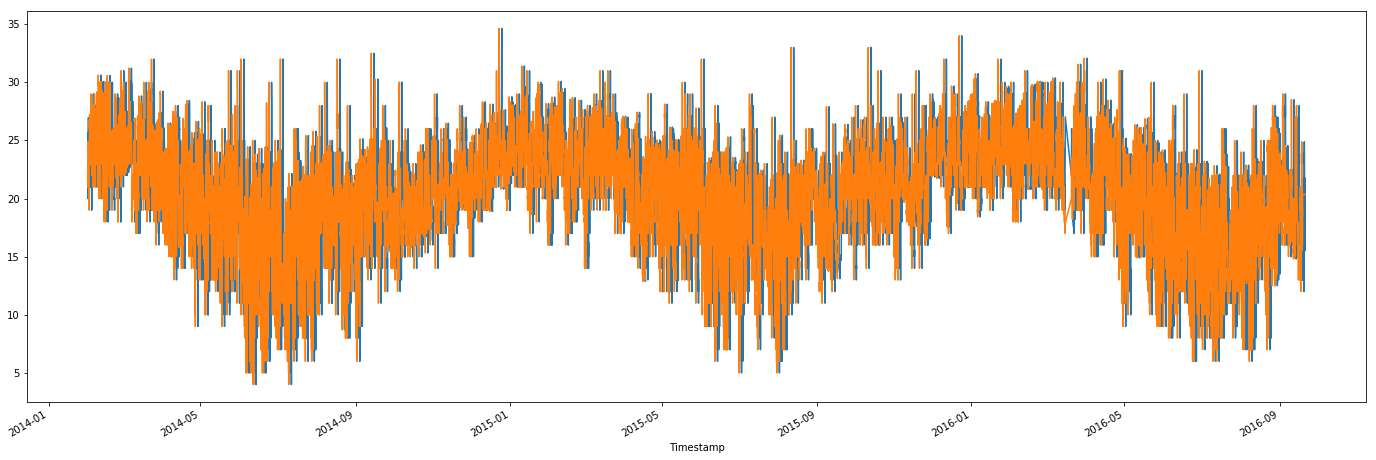

In [71]:
temp_df[['Timestamp','Temperature','TF50']].plot(x = 'Timestamp',figsize=(24, 8 * 1), legend=[])
plt.show()

In [60]:
def slice_train_data_rf_reverse_site(df_train,
                        df_sub,
                        site_id,
                        test_lengths):
    
    numeric_features = ['temp_diff','Temperature','is_day_off']
    time_features_day = ['dow','month','day']
    time_features_hour = ['dow','hour','month','day']
    time_features_15min = ['dow','hour','minute','month','day'] 

    temp_df = df_train[(df_train.SiteId == site_id)
                        &(pd.notnull(df_train.Value))]

    temp_df['is_train'] = 1

    # add test set data
    temp_df = temp_df.append(df_sub[(df_sub.SiteId == site_id)])
    # sort data to ensure consistency for producing weather time features 
    temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'] )         
    temp_df = temp_df.sort_values(by = 'Timestamp')
    local_forecast_ids = temp_df.ForecastId.unique()

    temp_df = produce_ar_features(temp_df)
    temp_df = temp_df.reset_index()

    # produce variable sets
    # only non-zero dummy variables
    all_hols = temp_df[hol_list].sum()>0
    non_zero_hols = list(all_hols.index[all_hols == True])

    prediction_freq = temp_df.ForecastId_type.values[0]
    if  prediction_freq == '1_day':
        predictors = numeric_features + non_zero_hols + time_features_day            
    elif prediction_freq == '1_hour':
        predictors = numeric_features + non_zero_hols + time_features_hour
    else: # 15_mins
        predictors = numeric_features + non_zero_hols + time_features_15min 


    train_ind = []
    val_ind = []

    for local_forcast_id in local_forecast_ids:
        local_temp_df = temp_df[temp_df.ForecastId == local_forcast_id]
        train_ind.extend(list(local_temp_df.index)[:-test_lengths[local_forcast_id]-test_lengths[local_forcast_id]//2])
        val_ind.extend(list(local_temp_df.index)[-test_lengths[local_forcast_id]-test_lengths[local_forcast_id]//2 :-test_lengths[local_forcast_id]])

    test_ind = list(temp_df[pd.isnull(temp_df.is_train)].index)              

    return temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors    
def slice_train_data_rf_reverse_site_weather(df_train,
                        df_sub,
                        site_id,
                        test_lengths):
    
    numeric_features = ['temp_diff','Temperature','is_day_off']
    time_features_day = ['dow','month','day']
    time_features_hour = ['dow','hour','month','day']
    time_features_15min = ['dow','hour','minute','month','day'] 
    weather_future_features = ['TF1','TF5','TF10','TF50']    

    temp_df = df_train[(df_train.SiteId == site_id)
                        &(pd.notnull(df_train.Value))]

    temp_df['is_train'] = 1

    # add test set data
    temp_df = temp_df.append(df_sub[(df_sub.SiteId == site_id)])
    # sort data to ensure consistency for producing weather time features 
    temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'] )         
    temp_df = temp_df.sort_values(by = 'Timestamp')
    local_forecast_ids = temp_df.ForecastId.unique()

    temp_df = produce_ar_features(temp_df)
    temp_df = produce_weather_future(temp_df)    
    temp_df = temp_df.reset_index()

    # produce variable sets
    # only non-zero dummy variables
    all_hols = temp_df[hol_list].sum()>0
    non_zero_hols = list(all_hols.index[all_hols == True])

    prediction_freq = temp_df.ForecastId_type.values[0]
    if  prediction_freq == '1_day':
        predictors = numeric_features + non_zero_hols + time_features_day + weather_future_features            
    elif prediction_freq == '1_hour':
        predictors = numeric_features + non_zero_hols + time_features_hour + weather_future_features
    else: # 15_mins
        predictors = numeric_features + non_zero_hols + time_features_15min + weather_future_features

    train_ind = []
    val_ind = []

    for local_forcast_id in local_forecast_ids:
        local_temp_df = temp_df[temp_df.ForecastId == local_forcast_id]
        train_ind.extend(list(local_temp_df.index)[:-test_lengths[local_forcast_id]-test_lengths[local_forcast_id]//2])
        val_ind.extend(list(local_temp_df.index)[-test_lengths[local_forcast_id]-test_lengths[local_forcast_id]//2 :-test_lengths[local_forcast_id]])

    test_ind = list(temp_df[pd.isnull(temp_df.is_train)].index)              

    return temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors
def slice_train_data_rf_reverse_site_full(df_train,
                        df_sub,
                        site_id,
                        test_lengths):
    
    numeric_features = ['temp_diff','Temperature','is_day_off']
    time_features_day = ['dow','month','day']
    time_features_hour = ['dow','hour','month','day']
    time_features_15min = ['dow','hour','minute','month','day'] 

    temp_df = df_train[(df_train.SiteId == site_id)
                        &(pd.notnull(df_train.Value))]

    temp_df['is_train'] = 1

    # add test set data
    temp_df = temp_df.append(df_sub[(df_sub.SiteId == site_id)])
    # sort data to ensure consistency for producing weather time features 
    temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'] )         
    temp_df = temp_df.sort_values(by = 'Timestamp')
    local_forecast_ids = temp_df.ForecastId.unique()

    temp_df = produce_ar_features(temp_df)
    temp_df = temp_df.reset_index()

    # produce variable sets
    # only non-zero dummy variables
    all_hols = temp_df[hol_list].sum()>0
    non_zero_hols = list(all_hols.index[all_hols == True])

    prediction_freq = temp_df.ForecastId_type.values[0]
    if  prediction_freq == '1_day':
        predictors = numeric_features + non_zero_hols + time_features_day            
    elif prediction_freq == '1_hour':
        predictors = numeric_features + non_zero_hols + time_features_hour
    else: # 15_mins
        predictors = numeric_features + non_zero_hols + time_features_15min 


    train_ind = []
    val_ind = []
    
    train_ind = list(temp_df[pd.notnull(temp_df.is_train)].index)         
    test_ind = list(temp_df[pd.isnull(temp_df.is_train)].index)              

    return temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors    
def slice_train_data_rf_reverse_site_weather_full(df_train,
                        df_sub,
                        site_id,
                        test_lengths):
    
    numeric_features = ['temp_diff','Temperature','is_day_off']
    time_features_day = ['dow','month','day']
    time_features_hour = ['dow','hour','month','day']
    time_features_15min = ['dow','hour','minute','month','day'] 
    weather_future_features = ['TF1','TF5','TF10','TF50']    

    temp_df = df_train[(df_train.SiteId == site_id)
                        &(pd.notnull(df_train.Value))]

    temp_df['is_train'] = 1

    # add test set data
    temp_df = temp_df.append(df_sub[(df_sub.SiteId == site_id)])
    # sort data to ensure consistency for producing weather time features 
    temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'] )         
    temp_df = temp_df.sort_values(by = 'Timestamp')
    local_forecast_ids = temp_df.ForecastId.unique()

    temp_df = produce_ar_features(temp_df)
    temp_df = produce_weather_future(temp_df)    
    temp_df = temp_df.reset_index()

    # produce variable sets
    # only non-zero dummy variables
    all_hols = temp_df[hol_list].sum()>0
    non_zero_hols = list(all_hols.index[all_hols == True])

    prediction_freq = temp_df.ForecastId_type.values[0]
    if  prediction_freq == '1_day':
        predictors = numeric_features + non_zero_hols + time_features_day + weather_future_features            
    elif prediction_freq == '1_hour':
        predictors = numeric_features + non_zero_hols + time_features_hour + weather_future_features
    else: # 15_mins
        predictors = numeric_features + non_zero_hols + time_features_15min + weather_future_features

    train_ind = []
    val_ind = []
    
    train_ind = list(temp_df[pd.notnull(temp_df.is_train)].index)         
    test_ind = list(temp_df[pd.isnull(temp_df.is_train)].index)            

    return temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors
def WRMSE(y, pred_y):
    sq_err = np.square(y - pred_y)
    Tn = len(y)
    t = np.arange(1, Tn+1)
    W = (3*Tn - 2*t + 1)/(2*Tn**2)
    mu = y.mean()+1e-15
    return np.sqrt(np.sum(W*sq_err))/mu
def produce_weather_future(df):
    # fill all the -1 with NA and then interpolate
    df.loc[df['Temperature']==-1,'Temperature'] = np.nan
    df['Temperature'] = df['Temperature'].fillna(method='ffill')
    df['Temperature'] = df['Temperature'].fillna(method='bfill')
    
    df['TF1'] = df['Temperature'].shift(-1)
    df['TF5'] = df['Temperature'].shift(-5)
    df['TF10'] = df['Temperature'].shift(-10)
    df['TF50'] = df['Temperature'].shift(-50)
    
    df['TF1'] = df['TF1'].fillna(df['TF1'].mean())
    df['TF5'] = df['TF5'].fillna(df['TF5'].mean())
    df['TF10'] = df['TF10'].fillna(df['TF10'].mean())
    df['TF50'] = df['TF50'].fillna(df['TF50'].mean())
    
    df['Temperature'] = df['Temperature'].fillna(value = -100)
    df['TF1'] = df['Temperature'].fillna(value = -100)
    df['TF5'] = df['Temperature'].fillna(value = -100)
    df['TF10'] = df['Temperature'].fillna(value = -100)
    df['TF50'] = df['Temperature'].fillna(value = -100)

    return df

In [108]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,site_id in enumerate(site_ids):
        site_id = site_ids[55]
        try:
            #============ RF models ============#
            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)        

            # first fit all models on reverse validation (train - val) to collect the metrics
            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_reverse_site(df_train,
                                                                                                         df_sub,
                                                                                                         site_id,
                                                                                                         test_lengths)

            # then fit the model on the whole dataset and use the best one
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_reverse_site_full(df_train,
                                                             df_sub,
                                                             site_id,
                                                             test_lengths)

            local_forecast_ids = temp_df.ForecastId.unique()        
            stat_df_temp = pd.DataFrame(columns=['forecast_id','wrmse_val','r2_val','model'])        

            model_preds = []
            #============ Fit all the regressors ============#
            regressor_names = ['cb','lgb','s_gbr','s_rfr',
                               'cb_w','lgb_w','s_gbr_w','s_rfr_w']

            for i,regressor in enumerate([cbr,lgb,s_gbr,s_rfr]):
                try:
                    # first collect the metrics
                    regressor = regressor.fit(temp_df.filter(items=train_ind,axis=0)[predictors],
                                  temp_df.filter(items=train_ind,axis=0)[target])

                    # predict values and calculate metrics
                    temp_df['preds_{}_metric'.format(regressor_names[i])] = regressor.predict(temp_df[predictors])

                    for local_forecast_id in local_forecast_ids:
                        y_val_pred = temp_df.iloc[val_ind][temp_df.iloc[val_ind].ForecastId == local_forecast_id]['preds_{}_metric'.format(regressor_names[i])].values
                        y_val_true = temp_df.iloc[val_ind][temp_df.iloc[val_ind].ForecastId == local_forecast_id].Value.values

                        r2_val = metrics.r2_score(y_val_true, y_val_pred)  
                        wrmse_val = WRMSE(y_val_true, y_val_pred)

                        stat_df_temp = stat_df_temp.append(pd.DataFrame(columns=['forecast_id','wrmse_val','r2_val','model'],
                                                                        data=[[local_forecast_id,wrmse_val,r2_val,regressor_names[i]]]))

                    # then fit the model on the whole dataset
                    regressor = regressor.fit(temp_df.filter(items=train_ind_full,axis=0)[predictors],
                                  temp_df.filter(items=train_ind_full,axis=0)[target])

                    obs_ids = list(temp_df.loc[test_ind].obs_id)
                    temp_df['preds_{}'.format(regressor_names[i])] = regressor.predict(temp_df[predictors])
                    model_preds.append( list(temp_df.loc[test_ind]['preds_{}'.format(regressor_names[i])]) )
                except Exception as e:
                    # in case of exception - record poor scores
                    print('{} fitting failed due to error : {}'.format(regressor_names[i], print(str(e))))
                    cb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))               
                    for local_forecast_id in local_forecast_ids:
                        stat_df_temp = stat_df_temp.append(pd.DataFrame(columns=['forecast_id','wrmse_val','r2_val','model'],
                                                                        data=[[local_forecast_id,1e9,-1,regressor_names[i]]]))            


            #============ RF models w weather ============#
            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)        

            # first fit all models on reverse validation (train - val) to collect the metrics
            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_reverse_site_weather(df_train,
                                                                                                         df_sub,
                                                                                                         site_id,
                                                                                                         test_lengths)

            # then fit the model on the whole dataset and use the best one
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_reverse_site_weather_full(df_train,
                                                             df_sub,
                                                             site_id,
                                                             test_lengths)

            local_forecast_ids = temp_df.ForecastId.unique()        


            #============ Fit all the regressors ============#
            regressor_names = ['cb_w','lgb_w','s_gbr_w','s_rfr_w']

            for i,regressor in enumerate([cbr,lgb,s_gbr,s_rfr]):
                try:
                    # first collect the metrics
                    regressor = regressor.fit(temp_df.filter(items=train_ind,axis=0)[predictors],
                                  temp_df.filter(items=train_ind,axis=0)[target])

                    # predict values and calculate metrics
                    temp_df['preds_{}_metric'.format(regressor_names[i])] = regressor.predict(temp_df[predictors])

                    for local_forecast_id in local_forecast_ids:
                        y_val_pred = temp_df.iloc[val_ind][temp_df.iloc[val_ind].ForecastId == local_forecast_id]['preds_{}_metric'.format(regressor_names[i])].values
                        y_val_true = temp_df.iloc[val_ind][temp_df.iloc[val_ind].ForecastId == local_forecast_id].Value.values

                        r2_val = metrics.r2_score(y_val_true, y_val_pred)  
                        wrmse_val = WRMSE(y_val_true, y_val_pred)

                        stat_df_temp = stat_df_temp.append(pd.DataFrame(columns=['forecast_id','wrmse_val','r2_val','model'],
                                                                        data=[[local_forecast_id,wrmse_val,r2_val,regressor_names[i]]]))

                    # then fit the model on the whole dataset
                    regressor = regressor.fit(temp_df.filter(items=train_ind_full,axis=0)[predictors],
                                  temp_df.filter(items=train_ind_full,axis=0)[target])

                    obs_ids = list(temp_df.loc[test_ind].obs_id)
                    temp_df['preds_{}'.format(regressor_names[i])] = regressor.predict(temp_df[predictors])
                    model_preds.append( list(temp_df.loc[test_ind]['preds_{}'.format(regressor_names[i])]) )
                except Exception as e:
                    # in case of exception - record poor scores
                    print('{} fitting failed due to error : {}'.format(regressor_names[i], print(str(e))))
                    cb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))               
                    for local_forecast_id in local_forecast_ids:
                        stat_df_temp = stat_df_temp.append(pd.DataFrame(columns=['forecast_id','wrmse_val','r2_val','model'],
                                                                        data=[[local_forecast_id,1e9,-1,regressor_names[i]]]))
                        
            best_model_idx = stat_df_temp.groupby(by=['model'])[['wrmse_val']].mean().values.argmin()
            submission_df.loc[obs_ids,'Value'] = model_preds[best_model_idx]
            stat_df = stat_df.append(stat_df_temp)

            # log every 500 iterations
            if (i+1)%500 == 0:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
                print('Iteration {}, logs saved'.format(i))   

            pbar.update(1)

        except Exception as e:
            
            with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
                        
                        
            # if model fitting and prediction fails, then just submit average values            
            print('Error {}. site_id {}, submitting mean'.format(str(e),site_id))
            
            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_reverse_site(df_train,
                                                                                                         df_sub,
                                                                                                         site_id,
                                                                                                         test_lengths)

            try:
                train_mean = temp_df.Value.mean()
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
                
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            submission_df.loc[obs_ids,'Value'] = train_mean
            
            pbar.update(1)
            
        break

  0%|          | 1/6974 [00:36<70:30:29, 36.40s/it]


In [ ]:
stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))

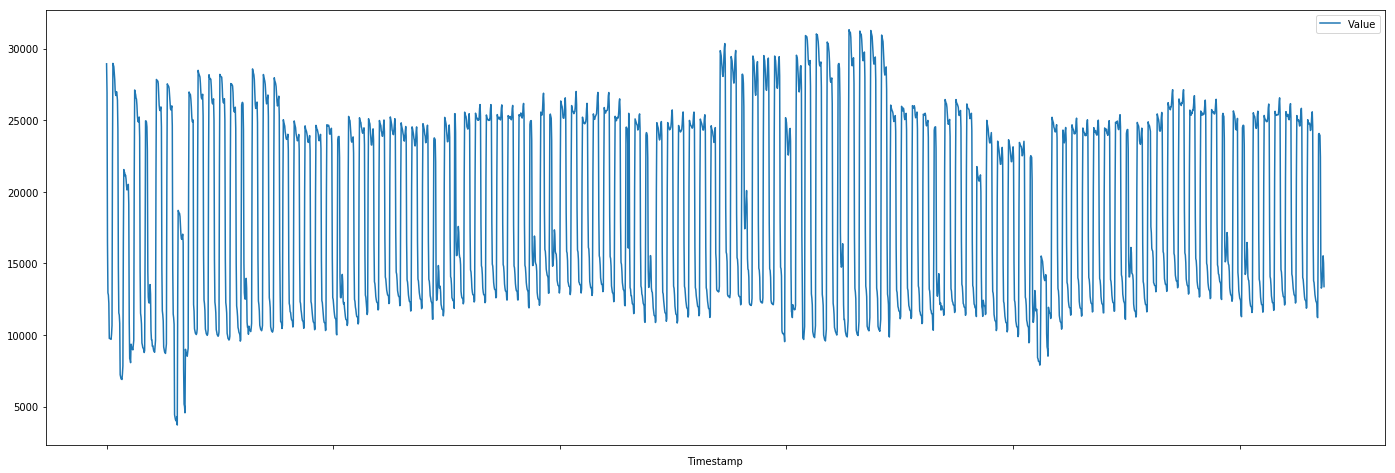

In [112]:
submission_df.loc[obs_ids][['Timestamp','Value']].plot(x = 'Timestamp',figsize=(24, 8 * 1))
plt.show()

In [109]:
submission_df.loc[obs_ids]

SiteId            Timestamp  ForecastId         Value
obs_id                                                        
5029118      66  2015-12-30 18:30:00        1515  28939.583198
2430503      66  2015-12-30 19:30:00        1515  26926.848166
4705004      66  2015-12-30 20:30:00        1515  16457.680323
6881384      66  2015-12-30 21:30:00        1515  12938.598568
680995       66  2015-12-30 22:30:00        1515  12788.809055
4613285      66  2015-12-30 23:30:00        1515  12209.599240
4454132      66  2015-12-31 00:30:00        1515   9752.971645
4060465      66  2015-12-31 01:30:00        1515   9764.245346
587626       66  2015-12-31 02:30:00        1515   9734.755222
5796495      66  2015-12-31 03:30:00        1515   9727.506708
6885324      66  2015-12-31 04:30:00        1515   9691.889922
477900       66  2015-12-31 05:30:00        1515  10061.043662
1326564      66  2015-12-31 06:30:00        1515  10664.183175
693287       66  2015-12-31 07:30:00        1515  22368.028206
5059837      66  2015-12-31 08:30:00        1515  28968.345711
4140924      66  2015-12-31 09:30:00        1515  28843.994823
1886448      66  2015-12-31 10:30:00        1515  28736.193676
2199170      66  2015-12-31 11:30:00        1515  28268.537056
6759770      66  2015-12-31 12:30:00        1515  27847.520732
6348903      66  2015-12-31 13:30:00        1515  27021.971456
277392       66  2015-12-31 14:30:00        1515  26786.903395
1155055      66  2015-12-31 15:30:00        1515  26722.858055
688623       66  2015-12-31 16:30:00        1515  26996.355270
4958762      66  2015-12-31 17:30:00        1515  26776.636605
7502612      66  2015-12-31 18:30:00        1515  26401.346097
5023281      66  2015-12-31 19:30:00        1515  24379.396962
1028581      66  2015-12-31 20:30:00        1515  14729.539687
62343        66  2015-12-31 21:30:00        1515  11537.689808
5610135      66  2015-12-31 22:30:00        1515  11387.900295
6246245      66  2015-12-31 23:30:00        1515  10810.543921
...         ...                  ...         ...           ...
3741034      66  2017-09-23 15:30:00        1528  24351.689191
6763365      66  2017-09-23 16:30:00        1528  24779.950238
1471399      66  2017-09-23 17:30:00        1528  25355.041476
6010400      66  2017-09-23 18:30:00        1528  25583.979234
1355793      66  2017-09-23 19:30:00        1528  24576.830295
4083815      66  2017-09-23 20:30:00        1528  16635.168666
1083956      66  2017-09-23 21:30:00        1528  13781.302645
5150721      66  2017-09-23 22:30:00        1528  13652.409035
4640351      66  2017-09-23 23:30:00        1528  13208.783873
6121417      66  2017-09-24 00:30:00        1528  12809.729727
2661825      66  2017-09-24 01:30:00        1528  12581.841634
5837809      66  2017-09-24 02:30:00        1528  12373.120376
4548613      66  2017-09-24 03:30:00        1528  12301.567884
992235       66  2017-09-24 04:30:00        1528  12185.194857
1520627      66  2017-09-24 05:30:00        1528  11270.210494
1363519      66  2017-09-24 06:30:00        1528  11208.436108
6132670      66  2017-09-24 07:30:00        1528  16059.863655
5165437      66  2017-09-24 08:30:00        1528  24009.071217
4736319      66  2017-09-24 09:30:00        1528  24071.450839
1325838      66  2017-09-24 10:30:00        1528  23985.775638
2324410      66  2017-09-24 11:30:00        1528  23951.963391
1619397      66  2017-09-24 12:30:00        1528  22431.586982
1919215      66  2017-09-24 13:30:00        1528  14496.673742
3038757      66  2017-09-24 14:30:00        1528  13269.259636
3028630      66  2017-09-24 15:30:00        1528  13353.729720
154735       66  2017-09-24 16:30:00        1528  13886.644695
5005942      66  2017-09-24 17:30:00        1528  14636.203209
1699044      66  2017-09-24 18:30:00        1528  15524.447735
6588876      66  2017-09-24 19:30:00        1528  15007.717993
6351736      66  2017-09-24 20:30:00        1528  13373.773007

[2687 rows x 4 columns]

In [107]:
stat_df_temp

model forecast_id  wrmse_val    r2_val
0         cb        1515   0.226805  0.794941
1         cb        1516   0.101812  0.946284
2         cb        1517   0.147726  0.868149
3         cb        1518   0.098449  0.920939
4         cb        1519   0.072781  0.926225
5         cb        1520   0.082054  0.916410
6         cb        1521   0.128506  0.877533
7         cb        1522   0.146273  0.888559
8         cb        1523   0.290097  0.746644
9         cb        1524   0.207024  0.807360
10        cb        1525   0.154216  0.870577
11        cb        1526   0.089427  0.884139
12        cb        1527   0.090706  0.848645
13        cb        1528   0.080684  0.890103
14       lgb        1515   0.234396  0.796801
15       lgb        1516   0.160848  0.870202
16       lgb        1517   0.205023  0.760318
17       lgb        1518   0.128040  0.869267
18       lgb        1519   0.103576  0.868701
19       lgb        1520   0.118446  0.832175
20       lgb        1521   0.148830  0.832666
21       lgb        1522   0.172322  0.847410
22       lgb        1523   0.305600  0.694087
23       lgb        1524   0.271145  0.727566
24       lgb        1525   0.132670  0.906535
25       lgb        1526   0.127772  0.772879
26       lgb        1527   0.121819  0.790607
27       lgb        1528   0.093999  0.862815
28     s_gbr        1515   0.211015  0.827140
29     s_gbr        1516   0.120812  0.922215
..       ...         ...        ...       ...
82     lgb_w        1527   0.121819  0.790607
83     lgb_w        1528   0.093999  0.862815
84   s_gbr_w        1515   0.190307  0.855875
85   s_gbr_w        1516   0.118746  0.930172
86   s_gbr_w        1517   0.170484  0.832956
87   s_gbr_w        1518   0.093679  0.934044
88   s_gbr_w        1519   0.084686  0.907336
89   s_gbr_w        1520   0.077046  0.925348
90   s_gbr_w        1521   0.125875  0.881545
91   s_gbr_w        1522   0.151018  0.874841
92   s_gbr_w        1523   0.280433  0.751539
93   s_gbr_w        1524   0.222858  0.810898
94   s_gbr_w        1525   0.131406  0.914510
95   s_gbr_w        1526   0.092647  0.875210
96   s_gbr_w        1527   0.087242  0.874839
97   s_gbr_w        1528   0.076259  0.904746
98   s_rfr_w        1515   0.243470  0.781732
99   s_rfr_w        1516   0.142978  0.900989
100  s_rfr_w        1517   0.190177  0.797026
101  s_rfr_w        1518   0.105521  0.916502
102  s_rfr_w        1519   0.089748  0.893310
103  s_rfr_w        1520   0.074569  0.929434
104  s_rfr_w        1521   0.137764  0.859058
105  s_rfr_w        1522   0.140785  0.892513
106  s_rfr_w        1523   0.290141  0.732661
107  s_rfr_w        1524   0.269902  0.740001
108  s_rfr_w        1525   0.137864  0.904990
109  s_rfr_w        1526   0.101438  0.852045
110  s_rfr_w        1527   0.098720  0.854148
111  s_rfr_w        1528   0.080885  0.894105

[112 rows x 4 columns]

In [92]:
stat_df_temp = stat_df_temp.set_index('model')

In [102]:
stat_df_temp = stat_df_temp.reset_index()

In [ ]:
stat_cols = ['forecast_id',
             'cb_rmse_train','cb_r2_score_train','cb_rmse_val','cb_r2_score_val','cb_scores',
             'lgb_rmse_train','lgb_r2_score_train','lgb_rmse_val','lgb_r2_score_val','lgb_scores',
             'cb_w_rmse_train','cb_w_r2_score_train','cb_w_rmse_val','cb_w_r2_score_val','cb_w_scores',
             'lgb_w_rmse_train','lgb_w_r2_score_train','lgb_w_rmse_val','lgb_w_r2_score_val','lgb_w_scores',    
             
             's_gbr_rmse_train','s_gbr_r2_score_train','s_gbr_rmse_val','s_gbr_r2_score_val','s_gbr_scores',
             's_rfr_rmse_train','s_rfr_r2_score_train','s_rfr_rmse_val','s_rfr_r2_score_val','s_rfr_scores',
             's_gbr_w_rmse_train','s_gbr_w_r2_score_train','s_gbr_w_rmse_val','s_gbr_w_r2_score_val','s_gbr_w_scores',
             's_rfr_w_rmse_train','s_rfr_w_r2_score_train','s_rfr_w_rmse_val','s_rfr_w_r2_score_val','s_rfr_w_scores',

             'model_chosen'               
            ]
stat_df = pd.DataFrame(columns=stat_cols)

0.9564784405101922

0.06055475945059536

In [50]:
model_preds[0][0]

28939.583198221524

In [51]:
model_preds[1][0]

28939.583198221524

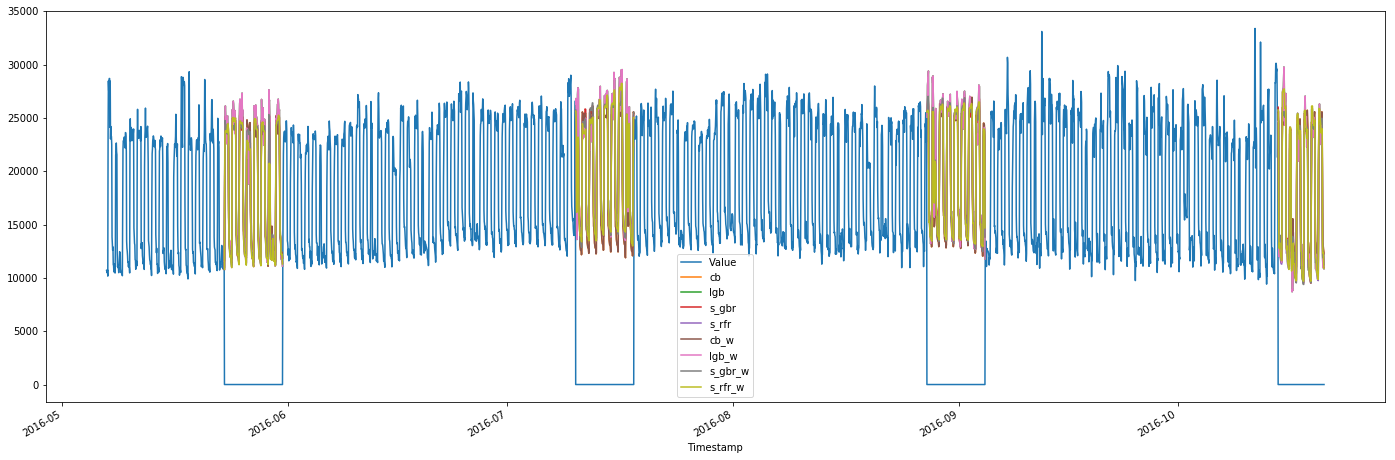

In [110]:
import matplotlib.pyplot as plt

regressor_names = ['cb','lgb','s_gbr','s_rfr',
                   'cb_w','lgb_w','s_gbr_w','s_rfr_w']

for i,preds in enumerate(model_preds):
    temp_df.loc[test_ind,regressor_names[i]] = preds

temp_df.iloc[4000:8000][['Timestamp','Value']+regressor_names].plot(x = 'Timestamp',figsize=(24, 8 * 1))
plt.show()

In [158]:
len(train_ind),len(val_ind),len(test_ind)

(765, 119, 238)

In [ ]:
with tqdm.tqdm(total=len(forecast_ids)) as pbar:
    for i,forecast_id in enumerate(forecast_ids):
        try:
            #============ RF models ============#
            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)
            
            # first fit all models on reverse validation (train - val) to collect the metrics
            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf(df_train,
                                                                                                         df_sub,
                                                                                                         forecast_id,
                                                                                                         test_lengths)
            
            # then fit the model on the whole dataset and use the best one
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_full(df_train,
                                                             df_sub,
                                                             forecast_id,
                                                             test_lengths)
            
            start_time = time.time()

            #============ Fit CatBoost ============#
            try:
                # first collect the metrics
                cb_rmse_train,cb_r2_score_train,cb_rmse_val,cb_r2_score_val,cb_scores,cbr = cb_fit_log_alg_wrmse(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,cbr = cb_fit_log_alg_wrmse(cbr,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb'] = cbr.predict(temp_df[predictors])
                cb_preds = list(temp_df.loc[test_ind].preds_cb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost fitting failed due to error : {}'.format(print(str(e))))

                cb_rmse_train = 1e9
                cb_r2_score_train = -1
                cb_rmse_val = 1e9
                cb_r2_score_val = -1
                cb_scores = []
                cb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   

            #============ Fit LightGBM ============#                
            try:
                # first collect the metrics
                lgb_rmse_train,lgb_r2_score_train,lgb_rmse_val,lgb_r2_score_val,lgb_scores,lgb = lgb_fit_log_alg_wrmse(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb'] = lgb.predict(temp_df[predictors])
                lgb_preds = list(temp_df.loc[test_ind].preds_lgb)            
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM fitting failed due to error : {}'.format(print(str(e))))
                lgb_rmse_train = 1e9
                lgb_r2_score_train = -1
                lgb_rmse_val = 1e9
                lgb_r2_score_val = -1
                lgb_scores = []
                lgb_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))  

            #============ Fit Sklearn Boosted Trees ============#
            try:
                # first collect the metrics
                s_gbr_rmse_train,s_gbr_r2_score_train,s_gbr_rmse_val,s_gbr_r2_score_val,s_gbr_scores,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr'] = s_gbr.predict(temp_df[predictors])
                s_gbr_preds = list(temp_df.loc[test_ind].preds_s_gbr)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_rmse_train = 1e9
                s_gbr_r2_score_train = -1
                s_gbr_rmse_val = 1e9
                s_gbr_r2_score_val = -1
                s_gbr_scores = []
                s_gbr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                # first collect the metrics
                s_rfr_rmse_train,s_rfr_r2_score_train,s_rfr_rmse_val,s_rfr_r2_score_val,s_rfr_scores,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset
                _,_,_,_,_,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr'] = s_rfr.predict(temp_df[predictors])
                s_rfr_preds = list(temp_df.loc[test_ind].preds_s_rfr)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_rmse_train = 1e9
                s_rfr_r2_score_train = -1
                s_rfr_rmse_val = 1e9
                s_rfr_r2_score_val = -1
                s_rfr_scores = []
                s_rfr_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                   
                   
            #============ RF models + future weather ============#

            cbr = CatBoostRegressor(**cbr_params)
            lgb = LGBMRegressor(**lgb_params)
            s_gbr = GradientBoostingRegressor(**s_gbr_params)
            s_rfr = RandomForestRegressor(**s_rfr_params)            

            temp_df,all_hols,train_ind,val_ind,test_ind,prediction_freq,predictors = slice_train_data_rf_weather(df_train,
                                                                                                                 df_sub,
                                                                                                                 forecast_id,
                                                                                                                 test_lengths)
            
            _,_,train_ind_full,_,_,_,_ = slice_train_data_rf_weather(df_train,
                                                                 df_sub,
                                                                 forecast_id,
                                                                 test_lengths)            
            
            #============ Fit CatBoost + weather ============#
            try:
                # first collect the metrics
                cb_w_rmse_train,cb_w_r2_score_train,cb_w_rmse_val,cb_w_r2_score_val,cb_w_scores,cbr = cb_fit_log_alg_wrmse(cbr,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset    
                _,_,_,_,_,cbr = cb_fit_log_alg(cbr,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_cb_w'] = cbr.predict(temp_df[predictors])
                cb_w_preds = list(temp_df.loc[test_ind].preds_cb_w)            
            except Exception as e:
                # in case of exception - record poor scores
                print('CatBoost with weather fitting failed due to error : {}'.format(print(str(e))))

                cb_w_rmse_train = 1e9
                cb_w_r2_score_train = -1
                cb_w_rmse_val = 1e9
                cb_w_r2_score_val = -1
                cb_w_scores = []
                cb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))

            #============ Fit LightGBM + weather ============#                
            try:
                # first collect the metrics
                lgb_w_rmse_train,lgb_w_r2_score_train,lgb_w_rmse_val,lgb_w_r2_score_val,lgb_w_scores,lgb = lgb_fit_log_alg_wrmse(lgb,
                         temp_df.filter(items=train_ind,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)
                # then fit the model on the whole dataset  
                _,_,_,_,_,lgb = lgb_fit_log_alg(lgb,
                         temp_df.filter(items=train_ind_full,axis=0),
                         temp_df.filter(items=val_ind,axis=0),                
                         predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_lgb_w'] = lgb.predict(temp_df[predictors])
                lgb_w_preds = list(temp_df.loc[test_ind].preds_lgb_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('LightGBM with weather fitting failed due to error : {}'.format(print(str(e))))
                lgb_w_rmse_train = 1e9
                lgb_w_r2_score_train = -1
                lgb_w_rmse_val = 1e9
                lgb_w_r2_score_val = -1
                lgb_w_scores = []
                lgb_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))            

            #============ Fit Sklearn Boosted Trees ============#
            try:
                # first collect the metrics
                s_gbr_w_rmse_train,s_gbr_w_r2_score_train,s_gbr_w_rmse_val,s_gbr_w_r2_score_val,s_gbr_w_scores,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset 
                _,_,_,_,_,s_gbr = sk_fit_alg_wrmse(s_gbr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_gbr_w'] = s_gbr.predict(temp_df[predictors])
                s_gbr_w_preds = list(temp_df.loc[test_ind].preds_s_gbr_w)
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn boosted trees fitting failed due to error : {}'.format(print(str(e))))

                s_gbr_w_rmse_train = 1e9
                s_gbr_w_r2_score_train = -1
                s_gbr_w_rmse_val = 1e9
                s_gbr_w_r2_score_val = -1
                s_gbr_w_scores = []
                s_gbr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))   
                
            #============ Fit Sklearn Random Forest ============#
            try:
                # first collect the metrics
                s_rfr_w_rmse_train,s_rfr_w_r2_score_train,s_rfr_w_rmse_val,s_rfr_w_r2_score_val,s_rfr_w_scores,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                                                                                             temp_df.filter(items=train_ind,axis=0),
                                                                                                             temp_df.filter(items=val_ind,axis=0),                
                                                                                                             predictors)
                # then fit the model on the whole dataset 
                _,_,_,_,_,s_rfr = sk_fit_alg_wrmse(s_rfr,
                                             temp_df.filter(items=train_ind_full,axis=0),
                                             temp_df.filter(items=val_ind,axis=0),                
                                             predictors)
                
                obs_ids = list(temp_df.loc[test_ind].obs_id)
                temp_df['preds_s_rfr_w'] = s_rfr.predict(temp_df[predictors])
                s_rfr_w_preds = list(temp_df.loc[test_ind].preds_s_rfr_w)  
            except Exception as e:
                # in case of exception - record poor scores
                print('Sklearn Random forest fitting failed due to error : {}'.format(print(str(e))))

                s_rfr_w_rmse_train = 1e9
                s_rfr_w_r2_score_train = -1
                s_rfr_w_rmse_val = 1e9
                s_rfr_w_r2_score_val = -1
                s_rfr_w_scores = []
                s_rfr_w_preds  = [0] * len(list(temp_df.loc[test_ind].obs_id))                                   
               

            #============ Record scores ============#  
            elapsed_time = time.time() - start_time 

            stat_df_temp = pd.DataFrame(columns=stat_cols)
            stat_df_temp['forecast_id'] = [forecast_id]

            stat_df_temp['cb_rmse_train'] = [cb_rmse_train]
            stat_df_temp['cb_r2_score_train'] = [cb_r2_score_train]
            stat_df_temp['cb_rmse_val'] = [cb_rmse_val]
            stat_df_temp['cb_r2_score_val'] = [cb_r2_score_val]
            stat_df_temp['cb_scores'] = [cb_scores]

            stat_df_temp['lgb_rmse_train'] = [lgb_rmse_train]
            stat_df_temp['lgb_r2_score_train'] = [lgb_r2_score_train]
            stat_df_temp['lgb_rmse_val'] = [lgb_rmse_val]
            stat_df_temp['lgb_r2_score_val'] = [lgb_r2_score_val]
            stat_df_temp['lgb_scores'] = [lgb_scores]

            stat_df_temp['cb_w_rmse_train'] = [cb_w_rmse_train]
            stat_df_temp['cb_w_r2_score_train'] = [cb_w_r2_score_train]
            stat_df_temp['cb_w_rmse_val'] = [cb_w_rmse_val]
            stat_df_temp['cb_w_r2_score_val'] = [cb_w_r2_score_val]
            stat_df_temp['cb_w_scores'] = [cb_w_scores]

            stat_df_temp['lgb_w_rmse_train'] = [lgb_w_rmse_train]
            stat_df_temp['lgb_w_r2_score_train'] = [lgb_w_r2_score_train]
            stat_df_temp['lgb_w_rmse_val'] = [lgb_w_rmse_val]
            stat_df_temp['lgb_w_r2_score_val'] = [lgb_w_r2_score_val]
            stat_df_temp['lgb_w_scores'] = [lgb_w_scores]
            
           
            stat_df_temp['s_gbr_rmse_train'] = [s_gbr_rmse_train]
            stat_df_temp['s_gbr_r2_score_train'] = [s_gbr_r2_score_train]
            stat_df_temp['s_gbr_rmse_val'] = [s_gbr_rmse_val]
            stat_df_temp['s_gbr_r2_score_val'] = [s_gbr_r2_score_val]
            stat_df_temp['s_gbr_scores'] = [s_gbr_scores]

            stat_df_temp['s_rfr_rmse_train'] = [s_rfr_rmse_train]
            stat_df_temp['s_rfr_r2_score_train'] = [s_rfr_r2_score_train]
            stat_df_temp['s_rfr_rmse_val'] = [s_rfr_rmse_val]
            stat_df_temp['s_rfr_r2_score_val'] = [s_rfr_r2_score_val]
            stat_df_temp['s_rfr_scores'] = [s_rfr_scores]

            stat_df_temp['s_gbr_w_rmse_train'] = [s_gbr_w_rmse_train]
            stat_df_temp['s_gbr_w_r2_score_train'] = [s_gbr_w_r2_score_train]
            stat_df_temp['s_gbr_w_rmse_val'] = [s_gbr_w_rmse_val]
            stat_df_temp['s_gbr_w_r2_score_val'] = [s_gbr_w_r2_score_val]
            stat_df_temp['s_gbr_w_scores'] = [s_gbr_w_scores]
            
            stat_df_temp['s_rfr_w_rmse_train'] = [s_rfr_w_rmse_train]
            stat_df_temp['s_rfr_w_r2_score_train'] = [s_rfr_w_r2_score_train]
            stat_df_temp['s_rfr_w_rmse_val'] = [s_rfr_w_rmse_val]
            stat_df_temp['s_rfr_w_r2_score_val'] = [s_rfr_w_r2_score_val]
            stat_df_temp['s_rfr_w_scores'] = [s_rfr_w_scores] 
           
            best_model_idx = np.asarray([cb_rmse_val,lgb_rmse_val,cb_w_rmse_val,lgb_w_rmse_val,s_gbr_rmse_val,s_rfr_rmse_val,s_gbr_w_rmse_val,s_rfr_w_rmse_val]).argmin() 
            if best_model_idx == 0:
                stat_df_temp['model_chosen'] = ['cb']  
            elif best_model_idx == 1:
                stat_df_temp['model_chosen'] = ['lgb'] 
            elif best_model_idx == 2:
                stat_df_temp['model_chosen'] = ['cb_w']
            elif best_model_idx == 3:
                stat_df_temp['model_chosen'] = ['lgb_w']
            elif best_model_idx == 4:
                stat_df_temp['model_chosen'] = ['s_gbr']
            elif best_model_idx == 5:
                stat_df_temp['model_chosen'] = ['s_rfr']
            elif best_model_idx == 6:
                stat_df_temp['model_chosen'] = ['s_gbr_w']
            elif best_model_idx == 7:
                stat_df_temp['model_chosen'] = ['s_rfr_w']             
            

            #============ Finish recording scores ============#  
            # record scores even if they are bad
            stat_df_temp['time_taken'] = [elapsed_time]              
            stat_df = stat_df.append(stat_df_temp)     

            # log every 500 iterations
            if (i+1)%500 == 0:
                stat_df.to_csv('forest_stats_cb_{}.csv'.format(LOGNUMBER))
                submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
                submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
                submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))
                print('Iteration {}, logs saved'.format(i))
            pbar.update(1)            

            #============ Choose the best model ============# 

            best_model_r2 = np.asarray([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val]).max()
            
            if sum([cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val]) == -8:
                # all the models failed / produce crap
                raise ValueError('All the models failed - submit last value to both dataframes')
            else:
                # save best result in the first dataframe anyway
                if best_model_idx == 0:
                    submission_df.loc[obs_ids,'Value'] = cb_preds
                elif best_model_idx == 1:
                    submission_df.loc[obs_ids,'Value'] = lgb_preds
                elif best_model_idx == 2:
                    submission_df.loc[obs_ids,'Value'] = cb_w_preds
                elif best_model_idx == 3:
                    submission_df.loc[obs_ids,'Value'] = lgb_w_preds

                elif best_model_idx == 4:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_preds
                elif best_model_idx == 5:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_preds
                elif best_model_idx == 6:
                    submission_df.loc[obs_ids,'Value'] = s_gbr_w_preds
                elif best_model_idx == 7:
                    submission_df.loc[obs_ids,'Value'] = s_rfr_w_preds

                # if no model failed
                if -1 not in [cb_r2_score_val,lgb_r2_score_val,cb_w_r2_score_val,lgb_w_r2_score_val,s_gbr_r2_score_val,s_rfr_r2_score_val,s_gbr_w_r2_score_val,s_rfr_w_r2_score_val]:
                    # save averages to the third dataframe                
                    arr = np.vstack((cb_preds,lgb_preds,cb_w_preds,lgb_w_preds,s_gbr_preds,s_rfr_preds,s_gbr_w_preds,s_rfr_w_preds))
                    average_preds = list(arr.mean(axis=0))
                    submission_df_3.loc[obs_ids,'Value'] = average_preds
                else:
                    # if any of the models failed - just submit the best model instead of average
                    if best_model_idx == 0:
                        submission_df_3.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_3.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_3.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_3.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_3.loc[obs_ids,'Value'] = s_rfr_w_preds

                    
                # if there is no proper model, submit the last ts value to the second dataframe
                # otherwise save proper values to the second dataframe
                if best_model_r2 < 0:
                    try:
                        train_mean = temp_df.Value.iloc[-1]
                    except:
                        print('Bad train data sample, submitting 0')
                        train_mean = 0
                    submission_df_2.loc[obs_ids,'Value'] = [train_mean] * len(obs_ids)
                    
                    with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                        the_file.write(str(forecast_id)+'\n')
                
                else:
                    # save the best model to the second dataframe
                    if best_model_idx == 0:
                        submission_df_2.loc[obs_ids,'Value'] = cb_preds
                    elif best_model_idx == 1:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_preds
                    elif best_model_idx == 2:
                        submission_df_2.loc[obs_ids,'Value'] = cb_w_preds
                    elif best_model_idx == 3:
                        submission_df_2.loc[obs_ids,'Value'] = lgb_w_preds

                    elif best_model_idx == 4:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_preds
                    elif best_model_idx == 5:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_preds
                    elif best_model_idx == 6:
                        submission_df_2.loc[obs_ids,'Value'] = s_gbr_w_preds
                    elif best_model_idx == 7:
                        submission_df_2.loc[obs_ids,'Value'] = s_rfr_w_preds
        
              
        except Exception as e:
            
            with open('last_value_submits_{}.csv'.format(LOGNUMBER), 'a') as the_file:
                the_file.write(str(forecast_id)+'\n')
                        
                        
            # if model fitting and prediction fails, then just submit average values            
            print('Error {}. Forecast_id {}, submitting mean'.format(str(e),forecast_id))
            
            temp_df = df_train[(df_train.ForecastId == forecast_id)
                                &(pd.notnull(df_train.Value))]
            
            try:
                train_mean = temp_df.Value.iloc[-1]
            except:
                print('Bad train data sample, submitting 0')
                train_mean = 0
             
            temp_df = temp_df.append(df_sub[(df_sub.ForecastId == forecast_id)])            
            temp_df = temp_df.reset_index()
            
            temp_df['pred'] = train_mean
            
            test_ind = list(temp_df.index)[-test_lengths[forecast_id]:]            

            # set the predictions in the prediction df
            obs_ids = list(temp_df.loc[test_ind].obs_id)
            predictions = list(temp_df.loc[test_ind].pred)
            
            # save last value or 0 to both dataframes
            submission_df.loc[obs_ids,'Value'] = predictions
            submission_df_2.loc[obs_ids,'Value'] = predictions
            submission_df_3.loc[obs_ids,'Value'] = predictions

stat_df.to_csv('forest_stats_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df_2['Value'] = submission_df_2['Value'].fillna(value=0)
submission_df_3['Value'] = submission_df_3['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_always_best_model'))
submission_df_2.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_last_if_bad'))
submission_df_3.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER+'_average_or_last'))   

# E2E CNN approach

## Load data

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import  metrics
 
# custom utils and random forest scripts
from Utils import ETL_emb, count_test_period

# dummy variable list            
from holidayList import hol_list

LOGNUMBER = 'e2e_seq2seq'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL_emb()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

forecast_ids = list(test_lengths.keys())
site_ids = list(df_sub.SiteId.unique())

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

def preprocess_seq2seq(df_train,df_sub):
    # add train / test marker
    df_train['is_train'] = 1
    df_sub['is_train'] = 0

    # merge dataframes together
    data_df = df_train.append(df_sub)
    del df_train,df_sub
    
    # sort dataframe by site_id and timestamp 
    # so that we could easily use ar features 
    # and do indexing
    data_df['Timestamp'] = pd.to_datetime(data_df['Timestamp'] )
    data_df = data_df.sort_values(by = ['SiteId','Timestamp'])
    
    # replace non-existent temperature with base temperature
    data_df.loc[(data_df.Temperature == -1),'Temperature'] = data_df.loc[(data_df.Temperature == -1),'BaseTemperature']    
    
    
    # produce future features for temperature
    """
    print('Producing shifted future temperature features ...')
    with tqdm.tqdm(total=len(site_ids)) as pbar:
        for site_id in site_ids:
            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-1)
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-5)
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-10)
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-50)

            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'FT1'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'FT5'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'FT10'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'FT50'].fillna(method='ffill')

            pbar.update(1)
    """
    
    # remove very drastic outliers 
    print('Removing drastic outliers ... ')
    with tqdm.tqdm(total=len([1964, 1968, 1969, 4325, 5276, 5536])) as pbar:
        for forecast_id in [1964, 1968, 1969, 4325, 5276, 5536]:
            data_df.loc[(data_df.ForecastId == forecast_id)
                        &(data_df.Value>10**8), 'Value'] = np.nan

            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='ffill')
            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='bfill')

            pbar.update(1)
            
    return data_df

data_df = preprocess_seq2seq(df_train,df_sub)
# reset index to make sure we do not have double indexes and for easier indexing
data_df = data_df.reset_index()
del data_df['index']

# leave only the first holiday
data_df = data_df[(data_df['obs_id'].shift(+1) != data_df['obs_id'])]
data_df = data_df.reset_index()
del data_df['index']
# fill days wo holidays with -1
data_df['Holiday'] = data_df['Holiday'].fillna(value=-1)

Starting the ETL process
Time taken to complete the ETL process 158.68517208099365


 17%|█▋        | 1/6 [00:00<00:00,  7.98it/s]

Removing drastic outliers ... 


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


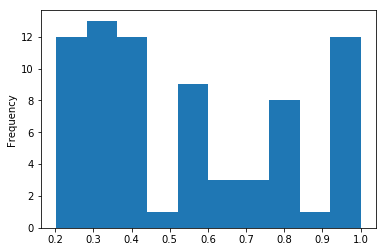

In [4]:
# interpolation pipeline

data_df['is_null'] = 0
data_df.loc[pd.isnull(data_df.Value),'is_null'] = 1

# find normal time series
null_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].sum()
count_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].count()
stat_df = pd.DataFrame()
stat_df['null_count'] = null_df
stat_df['count'] = count_df
stat_df['percent_null'] = stat_df['null_count']/stat_df['count']
# stat_df[stat_df.percent_null>0].percent_null.plot(kind='hist')
normal_forecast_ids = list(stat_df[(stat_df.percent_null==0)].index.values)

# all non-normal series
# that have all the train dataset values equal to NAs
submit_zeroes = list(stat_df[(stat_df.percent_null==1)].index)
# that have the majority of values equal to NAs
submit_averages = list(stat_df[(stat_df.percent_null>0.5)
                               &(stat_df.percent_null<1)].index)
# use linear interpolation for values between 0 and 0.2
linear_interpolation = list(stat_df[(stat_df.percent_null>0)
                               &(stat_df.percent_null<0.2)].index)

data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'] = data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'].interpolate(method='linear')

try_truncating = list(stat_df[(stat_df.percent_null>0.2)
                               &(stat_df.percent_null<0.5)].index)

use_last_window = []

for forecast_id in try_truncating:
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]
    
    last_window = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==1)].iloc[-test_len:]
    
    non_blank_last_window = last_window[pd.notnull(last_window.Value)].shape[0] / last_window.shape[0]
    
    if (non_blank_last_window == 1):
        use_last_window.append(forecast_id)
    else:
        submit_averages.append(forecast_id)
        
# drop non-last values for these forecast_ids
for forecast_id in use_last_window:
    
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]

    drop_index = data_df[data_df.ForecastId == forecast_id].index[:-test_len * 2]

    data_df.drop(index=drop_index,inplace=True,axis=0)        
    
train_forecast_ids = list(normal_forecast_ids) + list(linear_interpolation) + list(last_window)

In [5]:
len(normal_forecast_ids) + len(submit_zeroes) + len(submit_averages) + len(linear_interpolation) + len(use_last_window)

6974

In [6]:
data_df[pd.isnull(data_df['Holiday'])].shape

(0, 23)

## Analyze ts length

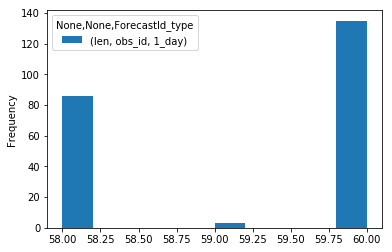

In [21]:
import numpy as np

pt = pd.pivot_table(data_df[(data_df.ForecastId_type == '1_day')
                             & (data_df.is_train == 0)],
               index=['ForecastId'],
               columns=['ForecastId_type'],
               values=['obs_id'],
               aggfunc=[len],
               fill_value=0)

pt.plot(kind='hist')
plt.show()

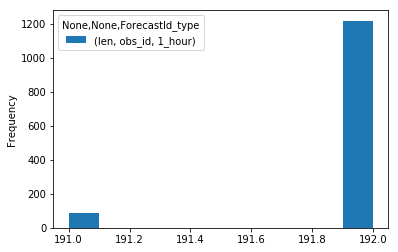

In [22]:
import numpy as np

pt = pd.pivot_table(data_df[(data_df.ForecastId_type == '1_hour')
                           & (data_df.is_train == 0)],
               index=['ForecastId'],
               columns=['ForecastId_type'],
               values=['obs_id'],
               aggfunc=[len],
               fill_value=0)

pt.plot(kind='hist')
plt.show()

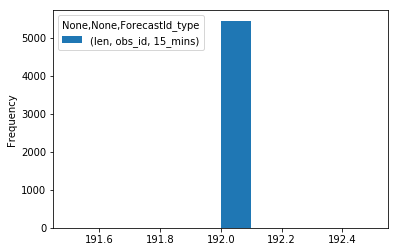

In [23]:
import numpy as np

pt = pd.pivot_table(data_df[(data_df.ForecastId_type == '15_mins')
                           & (data_df.is_train == 0)],
               index=['ForecastId'],
               columns=['ForecastId_type'],
               values=['obs_id'],
               aggfunc=[len],
               fill_value=0)

pt.plot(kind='hist')
plt.show()

## Embedding models

In [73]:
(12+2)//3

4

In [ ]:
temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']

predictors = temp_features + hol_emb_features + time_emb_features

((580, 192, 1), (580, 384, 8), (580, 192, 1))

In [74]:
X_sequences_ar.shape,X_sequences_meta.shape,y_sequences.shape

((580, 192, 1), (580, 384, 9), (580, 192, 1))

In [ ]:
X_sequences_ar,X_sequences_meta,y_sequences

In [125]:
X_sequences_meta[:,:,].size()

torch.Size([10, 580, 384, 8])

In [129]:
X_sequences_meta.size()

torch.Size([5800, 384, 8])

In [212]:
X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),X_sequences_ar.size(3))
X_sequences_temp = X_sequences_meta[:,:,0:1].float()
X_sequences_meta = X_sequences_meta[:,:,1:].long()

In [213]:
X_sequences_ar = X_sequences_ar.float()

In [214]:
X_sequences_meta.size(),X_sequences_temp.size(),X_sequences_ar.size()

(torch.Size([580, 384, 7]),
 torch.Size([580, 384, 1]),
 torch.Size([580, 192, 1]))

In [215]:
X_sequences_meta.type(),X_sequences_temp.type(),X_sequences_ar.type()

('torch.LongTensor', 'torch.FloatTensor', 'torch.FloatTensor')

In [117]:
X_sequences_temp.size()

torch.Size([5800, 384, 1])

In [239]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def create_emb(cat_size = 7,
               max_emb_size = 50,
               output_size = 10,
               non_trainable=False):

    emb_size = min([(cat_size+2)//3, max_emb_size])    
    emb = nn.Embedding(output_size, emb_size)

    if non_trainable:
        for param in emb.parameters(): 
            param.requires_grad = False
    return emb, emb_size, output_size

class MLPWindowEmb(nn.Module):
    def __init__(self,
                 in_sequence_len = 192,
                 out_sequence_len = 192,
                 features_meta_total = 72,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 256,
                 ar_hidden_layer_length = 128,
                 meta_hidden_layers = 2,
                 ar_hidden_layers = 1,
                 lstm_dropout = 0.5):
        
        super(MLPWindowEmb, self).__init__()

        self.meta_hidden_layer_length = meta_hidden_layer_length
        self.ar_hidden_layer_length = ar_hidden_layer_length
        self.meta_hidden_layers = meta_hidden_layers
        self.ar_hidden_layers = ar_hidden_layers      
        
        # create an embedding for each categorical feature
        self.hol_emb, emb_size, output_size = create_emb(cat_size = 66,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)
        
        self.year_emb, emb_size, output_size = create_emb(cat_size = 8,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len) 
        
        self.month_emb, emb_size, output_size = create_emb(cat_size = 12,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)  
        
        self.day_emb, emb_size, output_size = create_emb(cat_size = 31,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)  
        
        self.hour_emb, emb_size, output_size = create_emb(cat_size = 24,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)
        
        self.min_emb, emb_size, output_size = create_emb(cat_size = 60,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)
        
        self.dow_emb, emb_size, output_size = create_emb(cat_size = 7,
                                                       max_emb_size = 50,
                                                       output_size = in_sequence_len+out_sequence_len)        
        
   
        self.lstm_meta = nn.LSTM(features_meta_total,
                            meta_hidden_layer_length,
                            meta_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)
        
        self.lstm_ar = nn.LSTM(features_ar_total,
                            ar_hidden_layer_length,
                            ar_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)  


        self.classifier = nn.Sequential(
            nn.Linear(in_sequence_len + out_sequence_len, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, out_sequence_len),
        )


    
    def forward(self,
                x_temp,
                x_meta,
                x_ar):
        
        # embed and extract various features
        x_hol = self.hol_emb(x_meta[:,:,0])
        x_year = self.year_emb(x_meta[:,:,1])
        x_month = self.month_emb(x_meta[:,:,2])
        x_day = self.day_emb(x_meta[:,:,3])
        x_hour = self.hour_emb(x_meta[:,:,4])
        x_min = self.min_emb(x_meta[:,:,5])
        x_dow = self.dow_emb(x_meta[:,:,6])

        x_meta = torch.cat([x_temp,x_hol,x_year,x_month,x_day,x_hour,x_min,x_dow],dim=2)
        
        # initial values for LSTMs
        h0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length)) # .cuda()) 
        c0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length)) #.cuda())
        
        h0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length)) #.cuda()) 
        c0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length)) #.cuda())         
        
        # Forward propagate LSTMs
        out_meta, _ = self.lstm_meta(x_meta, (h0_meta, c0_meta))  
        out_meta = out_meta[:, -1, :]
        
        out_ar, _ = self.lstm_ar(x_ar, (h0_ar, c0_ar))  
        out_ar = out_ar[:, -1, :]    
        
        out = torch.cat([out_meta,out_ar],dim=1)
        out = self.classifier(out)

        return out


In [240]:
model = MLPWindowEmb(in_sequence_len = 192,
                 out_sequence_len = 192)

In [241]:
model

MLPWindowEmb(
  (hol_emb): Embedding(384, 22)
  (year_emb): Embedding(384, 3)
  (month_emb): Embedding(384, 4)
  (day_emb): Embedding(384, 11)
  (hour_emb): Embedding(384, 8)
  (min_emb): Embedding(384, 20)
  (dow_emb): Embedding(384, 3)
  (lstm_meta): LSTM(72, 256, num_layers=2, batch_first=True, dropout=0.5)
  (lstm_ar): LSTM(1, 128, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=512)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=512, out_features=512)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU(inplace)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=512, out_features=192)
  )
)

In [229]:
import torch.autograd.variable
X_sequences_temp_var = torch.autograd.Variable(X_sequences_temp)
X_sequences_meta_var = torch.autograd.Variable(X_sequences_meta)
X_sequences_ar_var = torch.autograd.Variable(X_sequences_ar)


In [ ]:
X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),X_sequences_ar.size(3))
X_sequences_temp = X_sequences_meta[:,:,0:1].float()
X_sequences_meta = X_sequences_meta[:,:,1:].long()

X_sequences_temp_var = torch.autograd.Variable(X_sequences_temp)
X_sequences_meta_var = torch.autograd.Variable(X_sequences_meta)
X_sequences_ar_var = torch.autograd.Variable(X_sequences_ar)


In [242]:
model(X_sequences_temp_var,X_sequences_meta_var,X_sequences_ar_var)

torch.Size([580, 256])
torch.Size([580, 128])
torch.Size([580, 192])


1

In [ ]:
class LSTMWindow(nn.Module):
    def __init__(self,
                 in_sequence_len,
                 out_sequence_len,
                 features_len,
                 hidden_size,
                 num_layers,
                 lstm_dropout,
                 use_bnorm
                 ):
        
        super(LSTMWindow, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bnorm = nn.BatchNorm1d(features_len)
        self.use_bnorm = use_bnorm

        self.lstm = nn.LSTM(features_len,
                            hidden_size,
                            num_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)
        
        self.fc = nn.Linear(hidden_size, out_sequence_len)
    
    def forward(self, x):
        # Set initial states 
        
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()) 
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda())
        
        if self.use_bnorm:
            x = x.permute(0,2,1).contiguous()
            x = self.bnorm(x)
            x = x.permute(0,2,1)

        # Forward propagate RNN
        out, _ = self.lstm(x, (h0, c0))  
        out = out[:, -1, :]
        # weights = Variable(torch.from_numpy( np.array( [(i/self.sequence_length) for i in range(1,self.sequence_length+1)] )).float().cuda(),requires_grad=False)           
        # out = torch.stack ( [torch.matmul(weights.view(1,-1), video).view(out.size(2) ) for video in out] )
        out = self.fc(out)

        return out

## Generator for full scale MLP and seq2seq

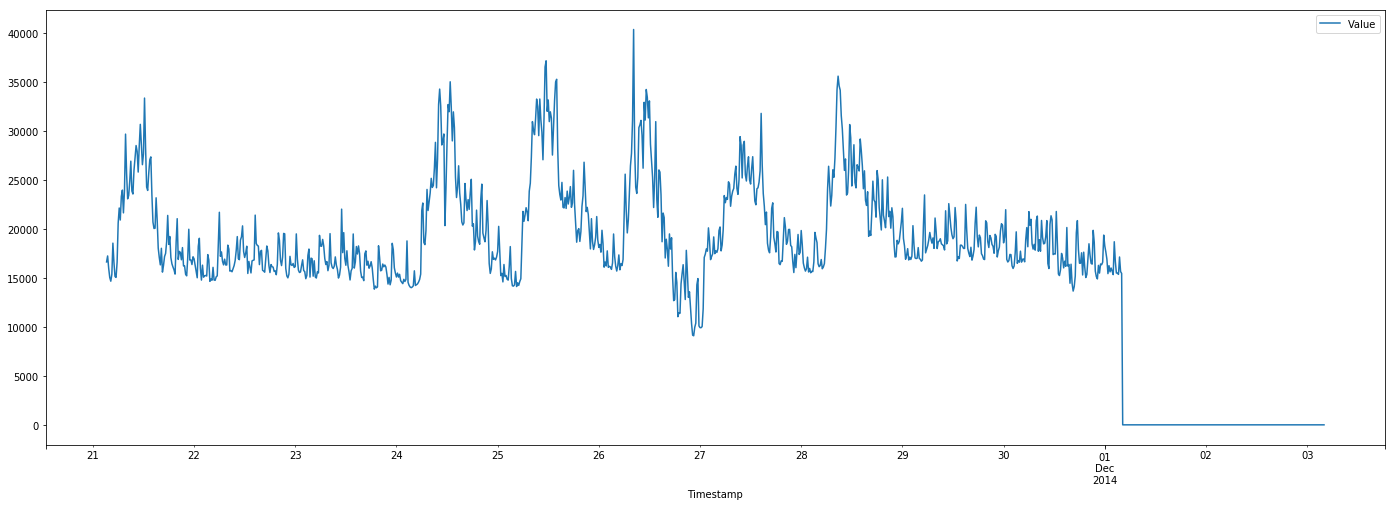

In [17]:
import matplotlib.pyplot as plt

data_df[(data_df.ForecastId == stat_df[(stat_df.percent_null<0.2)&((stat_df.percent_null<1))].sample(n=1).index.values[0])][['Timestamp','Value']].plot(x = 'Timestamp',figsize=(24, 8 * 1))
plt.show()

In [45]:
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from multiprocessing import Pool
from Utils import process_categorical_features

class S2VDataset(data.Dataset):
    def __init__(self,
                 ):
        pass

class S2SDataset(data.Dataset):
    def __init__(self,
                 df = None,
                 series_type =  '15_mins', # '1_hour' '1_day'
                 in_sequence_len = 192,
                 out_sequence_len = 192,
                 target = 'Value',
                 mode = 'train', # train, val or test
                 split_mode = 'random', # random or left or right
                 predictors = []
                 ):
        
        
        print('Creating dataset object ...')
        self.mode = mode
        # select only one type of series
        self.df = df[df.ForecastId_type == series_type]
        
        # factorize features even further
        self.df = process_categorical_features(self.df,['Holiday','year', 'month', 'day', 'hour', 'minute','dow'])
        
        # copy of the df for faster indexing
        
        # order of predictors is important for CNNs
        self.predictors = predictors
        self.in_sequence_len = in_sequence_len
        self.out_sequence_len = out_sequence_len
        self.target = target
        self.mode = mode
        self.split_mode = split_mode
        
        # store the selected time series' site_ids and forecast_ids
        self.forecast_ids = list(self.df.ForecastId.unique())
        
        # do simple train test split based on forecast_ids
        self.train_f_ids, self.val_f_ids = train_test_split(self.forecast_ids,
                                                 test_size = 0.25,
                                                 random_state = 42,
                                                 )
        
        self.site_ids = list(self.df.SiteId.unique())
        
        # store the averages and std of series in dictionaries
        self.mean_dict = {}
        self.std_dict = {}

        self.__normalize__()
        
        
    def __produce_idx_one__(self,
                            forecast_id):

        slice_df = self.df[self.df.ForecastId == forecast_id]
        slice_df = slice_df.reset_index()

        # how many training data we have
        trainval_len = slice_df[slice_df.is_train == 1].shape[0]
        # calculate how many rolling windows we have
        trainval_window_count =  trainval_len - self.in_sequence_len - self.out_sequence_len

        slice_df_predictors = slice_df[predictors].values
        slice_df_targets = slice_df[target].values

        # idx of the trainval subset
        trainval_idx = list(slice_df[(slice_df.is_train == 1)].index)
        # idx of the test subset
        test_idx = list(slice_df[(slice_df.is_train == 0)].index)

        # we always have enough data for several rolling windows for trainval
        trainval_X_sequences_ar = np.asarray( [(slice_df_targets[trainval_idx[window:window+self.in_sequence_len]]) for window in range(0,trainval_window_count)] )
        trainval_X_sequences_meta = np.asarray( [(slice_df_predictors[trainval_idx[window : window+self.in_sequence_len+self.out_sequence_len]]) for window in range(0,trainval_window_count)] ) 
        trainval_y_sequences = np.asarray( [(slice_df_targets[trainval_idx[window+self.in_sequence_len : window+self.in_sequence_len+self.out_sequence_len]]) for window in range(0,trainval_window_count)] )

        len_diff = len(test_idx) - self.out_sequence_len
        # if the test set has standard length
        if len(test_idx) == self.out_sequence_len:
            test_X_sequences_meta = slice_df_predictors[trainval_idx[-self.in_sequence_len:] + test_idx]
            test_X_sequences_ar = slice_df_targets[trainval_idx[-self.in_sequence_len:]]
        # otherwise add several points from the train dataset
        else:
            test_X_sequences_meta = slice_df_predictors[trainval_idx[- self.out_sequence_len - len_diff:] + test_idx]
            test_X_sequences_ar = slice_df_targets[trainval_idx[- self.out_sequence_len - len_diff:]]         

        return trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,test_X_sequences_meta,test_X_sequences_ar,len_diff
    
    def __normalize__(self):
        # normalize all series, store their means and stds
        print('Normalizing features ...')
        
        self.mean_dict = self.df[self.df.is_train==1].groupby(by=['ForecastId'])['Value'].mean().to_dict()
        self.std_dict = self.df[self.df.is_train==1].groupby(by=['ForecastId'])['Value'].std().to_dict()
        
        # isolate series where all values are equal to one value
        # preprocess them separately
        flat_forecast_ids = [(k) for k, v in self.std_dict.items() if v == 0]
        
        # insert means for all series
        self.df['mean'] = self.df.ForecastId.apply(lambda x: self.mean_dict[x])
        # insert stds only for series with non-zero std
        self.df.loc[~self.df['ForecastId'].isin(flat_forecast_ids),'std'] = self.df[~self.df['ForecastId'].isin(flat_forecast_ids)].ForecastId.apply(lambda x: self.std_dict[x])
        # std for zero-std series is 1        
        
        self.df['Value'] = (self.df['Value'] - self.df['mean']) / self.df['std']
        
        # set test set values back to 0
        self.df.loc[self.df.is_train==0,'Value'] = 0
            
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_f_ids)
        elif self.mode == 'val':
            return len(self.val_f_ids)
        elif self.mode == 'test':
            # test set length is equal to the number of forecast ids
            return len(self.forecast_ids)

    def __getitem__(self, idx):
        if self.split_mode in ['random']:
            if self.mode == 'train':
                trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = self.__produce_idx_one__(self.train_f_ids[idx])
                return trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences
            
            elif self.mode == 'val':
                trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = self.__produce_idx_one__(self.val_f_ids[idx])
                return trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences
            elif self.mode == 'test':
                _,_,_,test_X_sequences_meta,test_X_sequences_ar,len_diff = self.__produce_idx_one__(self.forecast_ids[idx])
                X_sequences_ar = np.asarray( [(self.df.loc[idx][self.target].values) for idx in test_X_sequences_ar ] )
                X_sequences_meta = np.asarray( [(self.df.loc[idx][self.predictors].values) for idx in test_X_sequences_meta ] )
                return test_X_sequences_meta,test_X_sequences_ar,len_diff
        else:
            raise ValueError('getitem method not implemented for this split mode {}'.format(self.split_mode))

In [24]:
temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']

predictors = temp_features + hol_emb_features + time_emb_features


In [71]:
X_sequences_ar.shape,X_sequences_meta.shape,y_sequences.shape

((580, 192, 1), (580, 384, 9), (580, 192, 1))

In [35]:
optimizer.param_groups

[{'betas': (0.9, 0.999),
  'eps': 1e-08,
  'lr': 5,
  'params': [Parameter containing:
    0.8918
   -0.7768
   -0.7180
   -0.9381
   [torch.FloatTensor of size 4x1], Parameter containing:
    0.9844
    0.3730
   -0.4250
   -0.4804
   [torch.FloatTensor of size 4x1], Parameter containing:
    0.8404
    0.6965
    0.4301
   -0.8711
   [torch.FloatTensor of size 4], Parameter containing:
   -0.3084
    0.8442
    0.2962
    0.2201
   [torch.FloatTensor of size 4]],
  'weight_decay': 0}]

In [107]:
temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']

predictors = temp_features + hol_emb_features + time_emb_features

dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '15_mins',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'train',
                     split_mode = 'random',
                     predictors = predictors)

Creating dataset object ...
Normalizing features ...


In [211]:
import torch

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,        
    shuffle=True,
    num_workers=1,
    pin_memory=False,
    drop_last=False)

for i,(X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(train_loader):
    break

In [51]:
dataset.df.year.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [115]:
dataset.df[pd.isnull(dataset.df.Holiday)].shape

(6054202, 25)

In [67]:
X_sequences_ar.size()

torch.Size([10, 580, 192, 1])

In [114]:
X_sequences_meta[0,0,:]

array([5.000e-01,       nan, 2.016e+03, 1.000e+00, 1.800e+01, 0.000e+00,
       3.000e+01, 0.000e+00])

In [103]:
start_time = time.time()
X_sequences_ar,X_sequences_meta,y_sequences = dataset.__getitem__(1)
print(time.time() - start_time)

0.09079432487487793


In [83]:
X_sequences_ar.shape,X_sequences_meta.shape,y_sequences.shape

((580, 192, 1), (580, 384, 8), (580, 192, 1))

In [2]:
import numpy as np
A = np.random.randint(5, size=((580, 192, 1)))
idx = np.random.randint(A.shape[0], size=2)


In [9]:
A[idx].shape

(2, 192, 1)

In [6]:
idx

array([ 76, 226])

In [55]:
y_sequences[0,:,0].shape

(192,)

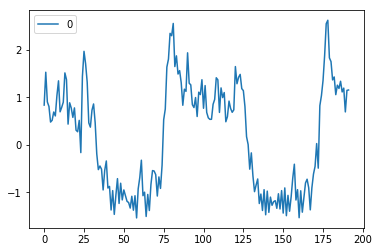

In [63]:
pd.DataFrame(data=y_sequences[-1,:,0]).plot()

In [ ]:
pd.DataFrame(data=y_sequences[0,:,0]).plot()

In [53]:
y_sequences.shape

(580, 192, 1)

In [10]:
a = np.random.randint(1,size=(1, 384, 8))

In [24]:
import torch

model = torch.nn.LSTM(input_size=1,hidden_size=1)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr = 5)

In [36]:
optimizer.state_dict()

{'param_groups': [{'betas': (0.9, 0.999),
   'eps': 1e-08,
   'lr': 5,
   'params': [139809880595416,
    139809883826600,
    139809883904984,
    139809880690920],
   'weight_decay': 0}],
 'state': {}}

In [34]:
current_lr = optimizer.state_dict()['param_groups'][0]['lr']


In [33]:
current_lr

5

In [29]:
optimizer.state_dict()['param_groups']['lr']

5

In [25]:
current_lr 
for param_group in optimizer.state_dict()['param_groups']:
    print(param_group['lr'])

5


In [23]:
from ELstm import E2ELSTM

model = E2ELSTM(in_sequence_len = 1,
                 out_sequence_len = 1,
                 features_meta_total = 1,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 1,
                 ar_hidden_layer_length = 1,
                 meta_hidden_layers = 1,
                 ar_hidden_layers = 1,
                 lstm_dropout = 1,
                 classifier_hidden_length = 1)

In [20]:
optimizer.state_dict()['param_groups']

[{'betas': (0.9, 0.999),
  'eps': 1e-08,
  'lr': 5,
  'params': [139809886721432,
   139809883826680,
   139809883826840,
   139809883826920],
  'weight_decay': 0}]

In [11]:
np.vstack([a] * 16).shape

(16, 384, 8)

In [52]:
X_sequences_meta.shape

(580, 384, 9)

In [50]:
X_sequences_ar.shape

(580, 192, 1)

In [ ]:
class S2SDatasetOld(data.Dataset):
    def __init__(self,
                 df = None,
                 series_type =  '15_mins', # '1_hour' '1_day'
                 in_sequence_len = 192,
                 out_sequence_len = 192,
                 target = 'Value',
                 mode = 'train', # train, val or test
                 split_mode = 'random', # random or left or right
                 predictors = []
                 ):
        
        
        print('Creating dataset object ...')
        self.mode = mode
        # select only one type of series
        self.df = df[df.ForecastId_type == series_type]
        # copy of the df for faster indexing
        self.df_idx = self.df[['ForecastId','is_train']]
        
        # order of predictors is important for CNNs
        self.predictors = predictors
        self.in_sequence_len = in_sequence_len
        self.out_sequence_len = out_sequence_len
        self.target = target
        self.mode = mode
        self.split_mode = split_mode
        
        # store the selected time series' site_ids and forecast_ids
        self.forecast_ids = list(self.df.ForecastId.unique())
        
        # do simple train test split based on forecast_ids
        self.train_f_ids, self.val_f_ids = train_test_split(self.forecast_ids,
                                                 test_size = 0.25,
                                                 random_state = 42,
                                                 )
        
        self.site_ids = list(self.df.SiteId.unique())
        
        # store the averages and std of series in dictionaries
        self.mean_dict = {}
        self.std_dict = {}

        self.__normalize__()
        
        """
        self.trainval_X_sequences_ar = []
        self.trainval_X_sequences_meta = []
        self.trainval_y_sequences = []
        self.test_X_sequences_meta = []
        self.test_X_sequences_ar = []
        

        self.__produce_idx__()
        """
        
    def __produce_idx_one__(self,
                            forecast_id):

        # produce lists of indexes for trainval and test datasets

        # how many training data we have
        trainval_len = self.df_idx[(self.df_idx.ForecastId == forecast_id)
                                  &(self.df_idx.is_train == 1)].shape[0]
        
        # calculate how many rolling windows we have
        trainval_window_count =  trainval_len - self.in_sequence_len - self.out_sequence_len

        # idx of the trainval subset
        trainval_idx = list(self.df_idx[(self.df_idx.ForecastId == forecast_id)
                                       &(self.df_idx.is_train == 1)].index)
        # idx of the test subset
        test_idx = list(self.df_idx[(self.df_idx.ForecastId == forecast_id)
                                   &(self.df_idx.is_train == 0)].index)

        all_idx = trainval_idx + test_idx

        # we always have enough data for several rolling windows for trainval
        trainval_X_sequences_ar = [(trainval_idx[window:window+self.in_sequence_len]) for window in range(0,trainval_window_count)]
        trainval_X_sequences_meta = [(trainval_idx[window:window+self.in_sequence_len+self.out_sequence_len]) for window in range(0,trainval_window_count)]
        trainval_y_sequences = [(trainval_idx[window+self.in_sequence_len:window+self.in_sequence_len+self.out_sequence_len]) for window in range(0,trainval_window_count)]

        # if the test set has standard length
        if len(test_idx) == self.out_sequence_len:
            test_X_sequences_meta = [trainval_idx[-self.in_sequence_len:] + test_idx]
            test_X_sequences_ar = [trainval_idx[-self.in_sequence_len:]]
        # otherwise add several points from the train dataset
        else:
            len_diff = len(test_idx) - self.out_sequence_len
            test_X_sequences_meta = [trainval_idx[- self.out_sequence_len - len_diff:] + test_idx]
            test_X_sequences_ar = [trainval_idx[- self.out_sequence_len - len_diff:]]          

        return trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,test_X_sequences_meta,test_X_sequences_ar,len(test_idx) - self.out_sequence_len
    
    # if we store all indexes as variables
    # it takes too much RAM
    def __produce_idx__(self):
       
        # print('Producing train / test indices ...')
        # with Pool(4) as p:
        #     self.idx_data = list(tqdm.tqdm(p.imap(self.__produce_idx_one__, self.forecast_ids), total=len(self.forecast_ids)))        
        

        with tqdm.tqdm(total=len(self.forecast_ids)) as pbar:        
            # for each time series
            for forecast_id in self.forecast_ids:
                
                idx_data = self.__produce_idx_one__(forecast_id)
                
                self.trainval_X_sequences_ar.append(idx_data[0])
                self.trainval_X_sequences_meta.append(idx_data[1])
                self.trainval_y_sequences.append(idx_data[2])
                self.test_X_sequences_meta.append(idx_data[3])
                self.test_X_sequences_ar.append(idx_data[4])
                
                pbar.update(1)
     
    def __normalize__(self):
        # normalize all series, store their means and stds
        print('Normalizing features ...')
        
        self.mean_dict = self.df[self.df.is_train==1].groupby(by=['ForecastId'])['Value'].mean().to_dict()
        self.std_dict = self.df[self.df.is_train==1].groupby(by=['ForecastId'])['Value'].std().to_dict()
        
        # isolate series where all values are equal to one value
        # preprocess them separately
        flat_forecast_ids = [(k) for k, v in self.std_dict.items() if v == 0]
        
        # insert means for all series
        self.df['mean'] = self.df.ForecastId.apply(lambda x: self.mean_dict[x])
        # insert stds only for series with non-zero std
        self.df.loc[~self.df['ForecastId'].isin(flat_forecast_ids),'std'] = self.df[~self.df['ForecastId'].isin(flat_forecast_ids)].ForecastId.apply(lambda x: self.std_dict[x])
        # std for zero-std series is 1        
        
        self.df['Value'] = (self.df['Value'] - self.df['mean']) / self.df['std']
        
        # set test set values back to 0
        self.df.loc[self.df.is_train==0,'Value'] = 0
            
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_f_ids)
        elif self.mode == 'val':
            return len(self.val_f_ids)
        elif self.mode == 'test':
            # test set length is equal to the number of forecast ids
            return len(self.forecast_ids)

    def __getitem__(self, idx):
        if self.split_mode in ['random']:
            if self.mode == 'train':
               
                start_time = time.time()
                trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = self.__produce_idx_one__(self.train_f_ids[idx])
                df_slice = self.df[self.df.ForecastId == self.train_f_ids[idx] ]
                
                print(time.time() - start_time)
                
                X_sequences_ar = np.asarray( [(df_slice.loc[idx][self.target].values) for idx in trainval_X_sequences_ar ] )
                print(time.time() - start_time)
                X_sequences_meta = np.asarray( [(df_slice.loc[idx][self.predictors].values) for idx in trainval_X_sequences_meta ] )
                print(time.time() - start_time)
                y_sequences = np.asarray( [(df_slice.loc[idx][self.target].values) for idx in trainval_y_sequences ] )
                print(time.time() - start_time)
                
                return X_sequences_ar,X_sequences_meta,y_sequences
            
            elif self.mode == 'val':
                trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = self.__produce_idx_one__(self.val_f_ids[idx])
                
                X_sequences_ar = np.asarray( [(self.df.loc[idx][self.target].values) for idx in trainval_X_sequences_ar ] )
                X_sequences_meta = np.asarray( [(self.df.loc[idx][self.predictors].values) for idx in trainval_X_sequences_meta ] )
                y_sequences = np.asarray( [(self.df.loc[idx][self.target].values) for idx in trainval_y_sequences ] )
                
                return X_sequences_ar,X_sequences_meta,y_sequences
            elif self.mode == 'test':
                _,_,_,test_X_sequences_meta,test_X_sequences_ar,len_diff = self.__produce_idx_one__(self.val_f_ids[idx])
                
                X_sequences_ar = np.asarray( [(self.df.loc[idx][self.target].values) for idx in test_X_sequences_ar ] )
                X_sequences_meta = np.asarray( [(self.df.loc[idx][self.predictors].values) for idx in test_X_sequences_meta ] )
                
                return X_sequences_ar,X_sequences_meta,len_diff
        else:
            raise ValueError('getitem method not implemented for this split mode {}'.format(self.split_mode))

# LSTM end-to-end only model

In [2]:
import pickle 
import pandas as pd

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

# read all pre-calculated objects
data_df = pd.read_feather('../data/forecast/data_df_feather')
with open('train_forecast_ids.pkl', 'rb') as input:
    train_forecast_ids = pickle.load(input)
with open('normal_forecast_ids.pkl', 'rb') as input:
    normal_forecast_ids = pickle.load(input)
with open('linear_interpolation.pkl', 'rb') as input:
    linear_interpolation = pickle.load(input)
with open('last_window.pkl', 'rb') as input:
    last_window = pickle.load(input)
with open('submit_zeroes.pkl', 'rb') as input:
    submit_zeroes = pickle.load(input)
with open('submit_averages.pkl', 'rb') as input:
    submit_averages = pickle.load(input)  

In [3]:
trainable_df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))]

In [ ]:


model = E2ELSTM(in_sequence_len = args.inp_seq,
                 out_sequence_len = args.out_seq,
                 features_meta_total = args.features_meta,
                 features_ar_total = args.features_ar,
                 meta_hidden_layer_length = args.lstm_meta_hid_feat,
                 ar_hidden_layer_length = args.lstm_ar_hid_feat,
                 meta_hidden_layers = args.lstm_meta_hid_lyr,
                 ar_hidden_layers = args.lstm_ar_hid_lyr,
                 lstm_dropout = args.lstm_dropout,
                 classifier_hidden_length = args.mlp_hid_lyr)

In [ ]:
from SDataset import S2SDataset
import torch

temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']
predictors = temp_features + hol_emb_features + time_emb_features

train_dataset = S2SDataset(df = trainable_df,
                     series_type = '15_mins',
                     in_sequence_len = 700,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'train',
                     split_mode = 'random',
                     predictors = predictors)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,        
    shuffle=True,
    num_workers=1,
    pin_memory=False,
    drop_last=False)

In [ ]:
    for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(train_loader):
        
        # measure data loading time
        data_time.update(time.time() - end)        
        
        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
        X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),1).float()
        y_sequences = y_sequences.view(-1,y_sequences.size(2)).float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(X_sequences_temp.cuda(async=True))
        x_meta_var = torch.autograd.Variable(X_sequences_meta.cuda(async=True))
        x_ar_var = torch.autograd.Variable(X_sequences_ar.cuda(async=True))
        y_var = torch.autograd.Variable(y_sequences.cuda(async=True))

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def create_emb(cat_size = 7,
               max_emb_size = 50,
               output_size = 10,
               non_trainable=False):

    emb_size = min([(cat_size+2)//3, max_emb_size])    
    emb = nn.Embedding(output_size, emb_size)

    if non_trainable:
        for param in emb.parameters(): 
            param.requires_grad = False
    return emb, emb_size, output_size

class E2ELSTM_day(nn.Module):
    def __init__(self,
                 in_sequence_len = 30,
                 out_sequence_len = 30,
                 features_meta_total = 44,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 30,
                 ar_hidden_layer_length = 30,
                 meta_hidden_layers = 2,
                 ar_hidden_layers = 1,
                 lstm_dropout = 0.5,
                 classifier_hidden_length = 256):
        
        super(E2ELSTM_day, self).__init__()

        self.meta_hidden_layer_length = meta_hidden_layer_length
        self.ar_hidden_layer_length = ar_hidden_layer_length
        self.meta_hidden_layers = meta_hidden_layers
        self.ar_hidden_layers = ar_hidden_layers      
        
        # create an embedding for each categorical feature
        self.hol_emb, emb_size, output_size = create_emb(cat_size = 72,
                                                       max_emb_size = 50,
                                                       output_size = 100)
        
        self.month_emb, emb_size, output_size = create_emb(cat_size = 12,
                                                       max_emb_size = 50,
                                                       output_size = 100)  
        
        self.day_emb, emb_size, output_size = create_emb(cat_size = 31,
                                                       max_emb_size = 50,
                                                       output_size = 100)
        
        self.dow_emb, emb_size, output_size = create_emb(cat_size = 7,
                                                       max_emb_size = 50,
                                                       output_size = 100)          
   
        self.lstm_meta = nn.LSTM(features_meta_total,
                            meta_hidden_layer_length,
                            meta_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)
        
        self.lstm_ar = nn.LSTM(features_ar_total,
                            ar_hidden_layer_length,
                            ar_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)  


        self.classifier = nn.Sequential(
            nn.Linear(meta_hidden_layer_length + ar_hidden_layer_length, classifier_hidden_length),
            nn.BatchNorm2d(classifier_hidden_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(classifier_hidden_length, classifier_hidden_length),
            nn.BatchNorm2d(classifier_hidden_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(classifier_hidden_length, out_sequence_len),
        )
        
        """ 
        self.classifier = nn.Sequential(
            nn.Linear(meta_hidden_layer_length + ar_hidden_layer_length, classifier_hidden_length),
            nn.ReLU(True),
            nn.Linear(classifier_hidden_length, classifier_hidden_length),
            nn.ReLU(True),
            nn.Linear(classifier_hidden_length, out_sequence_len),
            nn.ReLU(True)
        ) 
        """


    
    def forward(self,
                x_temp,
                x_meta,
                x_ar):
        
        # embed and extract various features
        x_hol = self.hol_emb(x_meta[:,:,0])
        x_month = self.month_emb(x_meta[:,:,1])
        x_day = self.day_emb(x_meta[:,:,2])
        x_dow = self.dow_emb(x_meta[:,:,3])        

        x_meta = torch.cat([x_temp,x_hol,x_month,x_day,x_dow],dim=2)
        
        # initial values for LSTMs
        h0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length).cuda()) 
        c0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length).cuda())
        
        h0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length).cuda()) 
        c0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length).cuda())         
        
        # Forward propagate LSTMs
        out_meta, _ = self.lstm_meta(x_meta, (h0_meta, c0_meta))  
        out_meta = out_meta[:, -1, :]
        
        out_ar, _ = self.lstm_ar(x_ar, (h0_ar, c0_ar))  
        out_ar = out_ar[:, -1, :]    
        
        out = torch.cat([out_meta,out_ar],dim=1)
       
        out = self.classifier(out)

        return out

class E2ELSTM(nn.Module):
    def __init__(self,
                 in_sequence_len = 192,
                 out_sequence_len = 192,
                 features_meta_total = 72,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 192,
                 ar_hidden_layer_length = 192,
                 meta_hidden_layers = 2,
                 ar_hidden_layers = 1,
                 lstm_dropout = 0.5,
                 classifier_hidden_length = 192 * 2):
        
        super(E2ELSTM, self).__init__()

        self.meta_hidden_layer_length = meta_hidden_layer_length
        self.ar_hidden_layer_length = ar_hidden_layer_length
        self.meta_hidden_layers = meta_hidden_layers
        self.ar_hidden_layers = ar_hidden_layers      
        
        # create an embedding for each categorical feature
        self.hol_emb, emb_size, output_size = create_emb(cat_size = 66,
                                                       max_emb_size = 50,
                                                       output_size = 100)
        
        self.year_emb, emb_size, output_size = create_emb(cat_size = 8,
                                                       max_emb_size = 50,
                                                       output_size = 100) 
        
        self.month_emb, emb_size, output_size = create_emb(cat_size = 12,
                                                       max_emb_size = 50,
                                                       output_size = 100)  
        
        self.day_emb, emb_size, output_size = create_emb(cat_size = 31,
                                                       max_emb_size = 50,
                                                       output_size = 100)  
        
        self.hour_emb, emb_size, output_size = create_emb(cat_size = 24,
                                                       max_emb_size = 50,
                                                       output_size = 100)
        
        self.min_emb, emb_size, output_size = create_emb(cat_size = 60,
                                                       max_emb_size = 50,
                                                       output_size = 100)
        
        self.dow_emb, emb_size, output_size = create_emb(cat_size = 7,
                                                       max_emb_size = 50,
                                                       output_size = 100)        
        
   
        self.lstm_meta = nn.LSTM(features_meta_total,
                            meta_hidden_layer_length,
                            meta_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)
        
        self.lstm_ar = nn.LSTM(features_ar_total,
                            ar_hidden_layer_length,
                            ar_hidden_layers,
                            batch_first=True,
                            dropout=lstm_dropout,
                            bidirectional=False)  


        self.classifier = nn.Sequential(
            nn.Linear(meta_hidden_layer_length + ar_hidden_layer_length, classifier_hidden_length),
            nn.BatchNorm2d(classifier_hidden_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(classifier_hidden_length, classifier_hidden_length),
            nn.BatchNorm2d(classifier_hidden_length),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(classifier_hidden_length, out_sequence_len),
        )
        
        """ 
        self.classifier = nn.Sequential(
            nn.Linear(meta_hidden_layer_length + ar_hidden_layer_length, classifier_hidden_length),
            nn.ReLU(True),
            nn.Linear(classifier_hidden_length, classifier_hidden_length),
            nn.ReLU(True),
            nn.Linear(classifier_hidden_length, out_sequence_len),
            nn.ReLU(True)
        ) 
        """


    
    def forward(self,
                x_temp,
                x_meta,
                x_ar):
        
        # embed and extract various features
        x_hol = self.hol_emb(x_meta[:,:,0])
        x_year = self.year_emb(x_meta[:,:,1])
        x_month = self.month_emb(x_meta[:,:,2])
        x_day = self.day_emb(x_meta[:,:,3])
        x_hour = self.hour_emb(x_meta[:,:,4])
        x_min = self.min_emb(x_meta[:,:,5])
        x_dow = self.dow_emb(x_meta[:,:,6])

        x_meta = torch.cat([x_temp,x_hol,x_year,x_month,x_day,x_hour,x_min,x_dow],dim=2)
        
        # initial values for LSTMs
        h0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length).cuda()) 
        c0_meta = Variable(torch.zeros(self.meta_hidden_layers, x_meta.size(0), self.meta_hidden_layer_length).cuda())
        
        h0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length).cuda()) 
        c0_ar = Variable(torch.zeros(self.ar_hidden_layers, x_ar.size(0), self.ar_hidden_layer_length).cuda())         
        
        # Forward propagate LSTMs
        out_meta, _ = self.lstm_meta(x_meta, (h0_meta, c0_meta))  
        out_meta = out_meta[:, -1, :]
        
        out_ar, _ = self.lstm_ar(x_ar, (h0_ar, c0_ar))  
        out_ar = out_ar[:, -1, :]    
        
        out = torch.cat([out_meta,out_ar],dim=1)
       
        out = self.classifier(out)

        return out